In [1]:
from itertools import chain
import pandas as pd
import time
import matplotlib.pyplot as plt
max_it = 10
from misc import vectorSchRepresentation, feasible_pairs, feasible_recharge, visualizeResult, visualizeSolution, drawBusTrips
from chs import constructiveScheduler
from sa import annealing, get_total_gap

In [2]:
cs_ids = ["CS1", "CS1a", "CS2c"]

def concat_str(x):
    return ','.join(x)

def countRecharge(x):
    trips = x.to_list()
    return len(list(filter(lambda x: x in cs_ids,trips)))

def countTrips(x):
    print(x.to_list())
    trips = x.to_list()
    return len(set(trips) - set(cs_ids))

# EXAMPLE DATA SET, DEPARTURE AND ARRIVAL TIMES IN MINUTES
trips = {
    0: {'name': 'DEPOT', 'type': 'depot', 'duration': 0, 'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    1: {'name': 'AC1', 'type': 'trip', 'duration': 140,  'dep_time': 555, 'arr_time': 695, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    2: {'name': 'AC2', 'type': 'trip', 'duration': 140, 'dep_time': 675, 'arr_time': 815, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    3: {'name': 'AC3', 'type': 'trip', 'duration': 140,  'dep_time': 795, 'arr_time': 935, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    4: {'name': 'AC4', 'type': 'trip', 'duration': 140,  'dep_time': 1155, 'arr_time': 1295, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    5: {'name': 'AC5', 'type': 'trip', 'duration': 140,  'dep_time': 1215, 'arr_time': 1355, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    6: {'name': 'CA1', 'type': 'trip', 'duration': 140,  'dep_time': 570, 'arr_time': 710, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    7: {'name': 'CA2', 'type': 'trip', 'duration': 140,  'dep_time': 740, 'arr_time': 880, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    8: {'name': 'CA3', 'type': 'trip', 'duration': 140,  'dep_time': 860, 'arr_time': 1000, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    9: {'name': 'CA4', 'type': 'trip', 'duration': 140,  'dep_time': 920, 'arr_time': 1060, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    10: {'name': 'CA5', 'type': 'trip', 'duration': 140,  'dep_time': 1040, 'arr_time': 1180, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
}
charging_station = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
}

charging_stations1 = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    len(trips)+1: {'name': 'CS1a', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal A', 'arr_term': 'Terminal A'},
}

charging_stations2 = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    len(trips)+1: {'name': 'CS1a', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal A', 'arr_term': 'Terminal A'},
    len(trips)+2: {'name': 'CS2c', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal C', 'arr_term': 'Terminal C'},
}

# TERMINALS AND MINIMUM INTERVALS BETWEEN TRIPS
terminals = {
    'Terminal A': {'max_interval': 15},
    'Terminal C': {'max_interval': 15},
}
### Add extra parameter that allows e-Bus to complete schedule that is not continuous (aka the start node does not have to be the end node of the previous)
## Defining the deadhead parameter from Terminals
cs_deadheads = {
    'Terminal A': {'CS1': 30, 'CS1a': 10, 'CS2c': 75},
    'Terminal C': {'CS1': 30, 'CS1a': 75, 'CS2c': 10},
}

D_MAX = 350
CHARGING_TIME = 100
trips_df = pd.DataFrame.from_dict(trips, orient='index')
print(trips_df)
## Creating Gamma and Delta
arcs = feasible_pairs(trips_df, terminals)
print(charging_station)

     name   type  duration  dep_time  arr_time    dep_term    arr_term
0   DEPOT  depot         0         0      1440           -           -
1     AC1   trip       140       555       695  Terminal A  Terminal C
2     AC2   trip       140       675       815  Terminal A  Terminal C
3     AC3   trip       140       795       935  Terminal A  Terminal C
4     AC4   trip       140      1155      1295  Terminal A  Terminal C
5     AC5   trip       140      1215      1355  Terminal A  Terminal C
6     CA1   trip       140       570       710  Terminal C  Terminal A
7     CA2   trip       140       740       880  Terminal C  Terminal A
8     CA3   trip       140       860      1000  Terminal C  Terminal A
9     CA4   trip       140       920      1060  Terminal C  Terminal A
10    CA5   trip       140      1040      1180  Terminal C  Terminal A
    trip_id   name   type  duration  dep_time  arr_time    dep_term  \
0         0  DEPOT  depot         0         0      1440           -   
1     

In [20]:
######################################################## 1CS #####################################################################
recharge_1cs_arcs = feasible_recharge(trips_df, cs_deadheads, recharge=charging_station, terminals=terminals)
cs_ids = set(list(charging_station.keys()))
all_schedules_1cs = {**trips, **charging_station}
all_schs_1cs = pd.DataFrame.from_dict(all_schedules_1cs, orient='index')
all_schs_1cs['ID'] = range(len(all_schs_1cs))
durations_1cs = {idx: {'duration': all_schs_1cs.loc[idx, 'duration']} for idx in all_schs_1cs.index if idx != 0}

################################################################### CHS-SA ###########################################################################################
####### CHS
import time
start_time = time.time()
print(f"{time.ctime()}")
schedules_tab, schedules_10_1 = constructiveScheduler(all_schs_1cs, arcs, recharge_1cs_arcs, cs_ids)
solution = vectorSchRepresentation(schedules_10_1)
end_time = time.time()
print(f"{time.ctime()}\nTime elapse to compute the solution = {(end_time - start_time)} seconds")
print(f"number of buses = {len(schedules_10_1)}")
print(schedules_10_1)
g_T10CS1_time = end_time-start_time

####### SA
print('-'*100)
print("starting simulated annealing....")
start_time = time.time()
# test_new_schedule, test_cost, test_cost_diffs, test_temp, test_it, test_costs, test_solutionspaces, test_best
new_schedule_10_1, cost_10_1, cost_diffs_10_1, temp_10_1, it_10_1, costs_10_1, solution_spaces_10_1, best_costs_10_1 = annealing(solution, all_schs_1cs, arcs, recharge_1cs_arcs)
end_time = time.time()
T10CS1_time = (end_time-start_time) + g_T10CS1_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(end_time - start_time)} seconds")
print(f"prev_schedule = {solution} with number of buses = {len(solution)}... \nnext_schedule = {new_schedule_10_1} with number of buses = {len(new_schedule_10_1)}")
print(f"Number of buses previous = {len(schedules_10_1)}... new = {len(new_schedule_10_1)} ")
print(f"Prev: {vectorSchRepresentation(schedules_10_1)}\nNew: {new_schedule_10_1}")
print(f"Total Gap among buses=> prev = {get_total_gap(solution, all_schs_1cs, recharge_1cs_arcs)}... new = {get_total_gap(new_schedule_10_1, all_schs_1cs, recharge_1cs_arcs)}")

Fri Feb 28 11:29:16 2025
Fri Feb 28 11:29:16 2025
Time elapse to compute the solution = 0.09743666648864746 seconds
number of buses = 3
[[(0, 1), (1, 3), (3, 10, 11), (10, 5), (5, 0)], [(0, 6), (6, 7), (7, 9), (9, 4, 11), (4, 0)], [(0, 2), (2, 8), (8, 0)]]
----------------------------------------------------------------------------------------------------
starting simulated annealing....
Iteration 1...
swapping recharging task...
proposed solution = [[1, 3, 0], [6, 7, 9, 11, 4, 0], [2, 8, 11, 5, 0], [10, 0]]
----------------------------------------------------------------------------------------------------
Iteration 2...
insertion...
proposed solution = [[1, 3, 0], [2, 8, 11, 5, 0], [10, 0], [6, 7, 9, 11, 4, 0]]
----------------------------------------------------------------------------------------------------
Iteration 3...
swapping other CS...
proposed solution = [[1, 3, 0], [10, 0], [2, 8, 11, 5, 0], [6, 7, 9, 11, 4, 0]]
------------------------------------------------------------

     name   type  duration  dep_time  arr_time    dep_term    arr_term  ID
0   DEPOT  depot         0         0      1440           -           -   0
1     AC1   trip       140       555       695  Terminal A  Terminal C   1
2     AC2   trip       140       675       815  Terminal A  Terminal C   2
3     AC3   trip       140       795       935  Terminal A  Terminal C   3
4     AC4   trip       140      1155      1295  Terminal A  Terminal C   4
5     AC5   trip       140      1215      1355  Terminal A  Terminal C   5
6     CA1   trip       140       570       710  Terminal C  Terminal A   6
7     CA2   trip       140       740       880  Terminal C  Terminal A   7
8     CA3   trip       140       860      1000  Terminal C  Terminal A   8
9     CA4   trip       140       920      1060  Terminal C  Terminal A   9
10    CA5   trip       140      1040      1180  Terminal C  Terminal A  10
11    CS1     cs        50         0      1440           -           -  11
     name   type  duratio

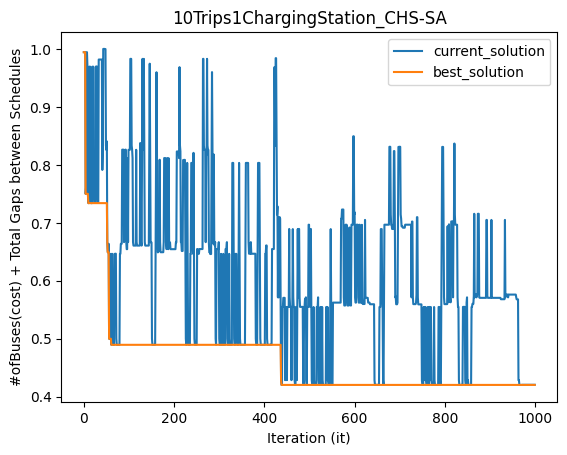

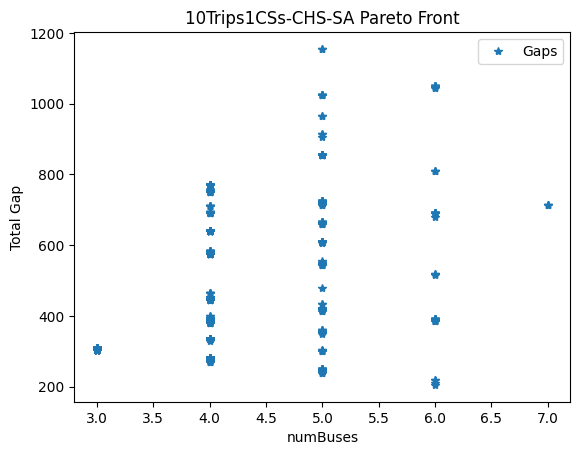

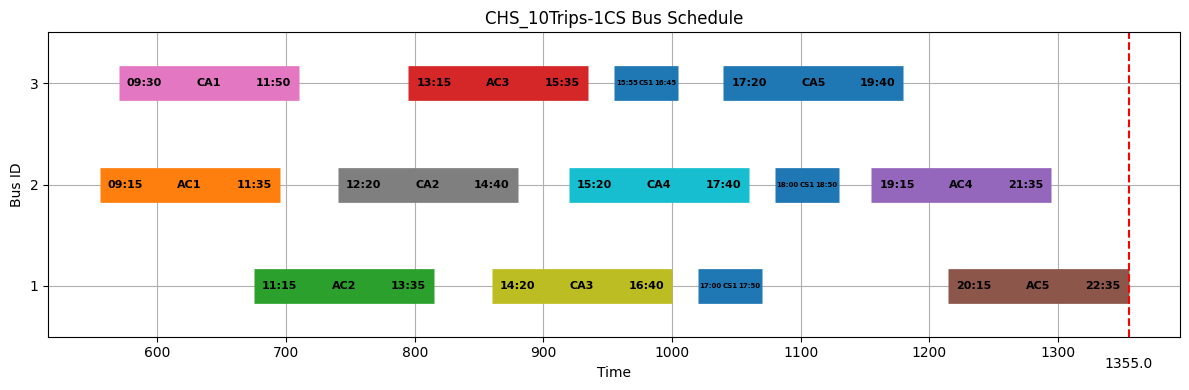

In [21]:
plt.plot(range(it_10_1), costs_10_1, label="current_solution")
plt.plot(range(it_10_1), best_costs_10_1, label="best_solution")
plt.xlabel("Iteration (it)")
# plt.ylabel("[weighted_sum] #ofBuses + Total Gap Time (cost)")
plt.ylabel("#ofBuses(cost) + Total Gaps between Schedules")
plt.title("10Trips1ChargingStation_CHS-SA")
plt.legend(loc="upper right")
# plt.savefig("10Trips1CS.png")

TenTrips_1cs_df = visualizeSolution(solution_spaces_10_1[1:], "10Trips1CSs-CHS-SA Pareto Front", all_schs_1cs, recharge_1cs_arcs)
newdf_10_1cs = visualizeResult(new_schedule_10_1, all_schs_1cs, "CHS_10Trips-1CS")
trips10_df_1cs = newdf_10_1cs.copy(deep=True)
trips10_df_1cs['next_dep'] = trips10_df_1cs.groupby('bus_id')['dep_time'].shift(-1).fillna(0)
trips10_df_1cs['difference'] = trips10_df_1cs['next_dep'] - trips10_df_1cs['arr_time']
trips10_df_1cs['difference'] = trips10_df_1cs['difference'].apply(lambda x: 0 if x < 0 else x)
trips10_1cs = trips10_df_1cs.groupby(['bus_id']).agg({'trip_id':concat_str, 'dep_time': 'first', 'arr_time': 'last', 'dep_terminal': 'first', 'arr_terminal': 'last', 'difference': 'sum'})
trips10_1cs.sort_values(by=['difference'], ascending=False)

# trips10_df.to_csv("10Trips1CS.csv")
chs_10Trips1cs_IDLE_soln = trips10_df_1cs.groupby(['bus_id']).agg(
    trips=('trip_id', concat_str),
    numRecharge=('trip_id',countRecharge),
    numTrips=('trip_id', countTrips),
    gapTime=('difference', 'sum')
)

In [22]:
################################################################### 2CS #############################################################################################
recharge_2cs_arcs = feasible_recharge(trips_df, cs_deadheads, recharge=charging_stations1, terminals=terminals)
cs_ids = set(list(charging_stations1.keys()))
all_schedules_2cs = {**trips, **charging_stations1}
all_schs_2cs = pd.DataFrame.from_dict(all_schedules_2cs, orient='index')
all_schs_2cs['ID'] = range(len(all_schs_2cs))
durations_2cs = {idx: {'duration': all_schs_2cs.loc[idx, 'duration']} for idx in all_schs_2cs.index if idx != 0}

####### CHS
import time
start_time = time.time()
print(f"{time.ctime()}")
test_schedules_tab, schedules_10_2 = constructiveScheduler(all_schs_2cs, arcs, recharge_2cs_arcs, set(cs_ids))
test_solution = vectorSchRepresentation(schedules_10_2)
end_time = time.time()
g_T10CS2_time = end_time - start_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {g_T10CS2_time} seconds")
print(f"number of buses = {len(schedules_10_2)}")
print(schedules_10_2)
print('-'*100)
print("starting simulated annealing....")
start_time = time.time()
new_schedule_10_2, cost_10_2, cost_diffs_10_2, temp_10_2, it_10_2, costs_10_2, solutionspaces_10_2, best_10_2 = annealing(test_solution, all_schs_2cs, arcs, recharge_2cs_arcs)
end_time = time.time()
T10CS2_time = (end_time-start_time)+g_T10CS2_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(T10CS2_time)} seconds")
print(f"prev_schedule = {test_solution} with number of buses = {len(test_solution)}... \nnext_schedule = {new_schedule_10_2} with number of buses = {len(new_schedule_10_2)}")


Fri Feb 28 11:32:58 2025
Fri Feb 28 11:32:58 2025
Time elapse to compute the solution = 0.0026841163635253906 seconds
number of buses = 3
[[(0, 1), (1, 3), (3, 10, 11), (10, 5), (5, 0)], [(0, 6), (6, 7), (7, 9), (9, 4, 11), (4, 0)], [(0, 2), (2, 8), (8, 0)]]
----------------------------------------------------------------------------------------------------
starting simulated annealing....
Iteration 1...
insertion...
proposed solution = [[1, 3, 11, 10, 5, 0], [6, 7, 9, 11, 4, 0], [2, 8, 0]]
----------------------------------------------------------------------------------------------------
Iteration 2...
insertion...
proposed solution = [[1, 3, 11, 10, 5, 0], [6, 7, 9, 11, 4, 0], [2, 8, 0]]
----------------------------------------------------------------------------------------------------
Iteration 3...
swapping other CS...
proposed solution = [[2, 8, 0], [1, 3, 11, 10, 5, 0], [6, 7, 9, 12, 4, 0]]
----------------------------------------------------------------------------------------

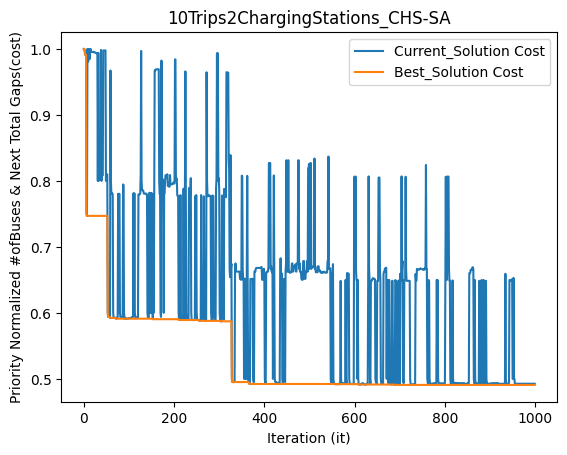

In [23]:
plt.plot(range(it_10_2), costs_10_2, label="Current_Solution Cost")
plt.plot(range(it_10_2), best_10_2, label="Best_Solution Cost")
plt.xlabel("Iteration (it)")
plt.ylabel("Priority Normalized #ofBuses & Next Total Gaps(cost)")
plt.title("10Trips2ChargingStations_CHS-SA")
plt.legend(loc="upper right")

     name   type  duration  dep_time  arr_time    dep_term    arr_term  ID
0   DEPOT  depot         0         0      1440           -           -   0
1     AC1   trip       140       555       695  Terminal A  Terminal C   1
2     AC2   trip       140       675       815  Terminal A  Terminal C   2
3     AC3   trip       140       795       935  Terminal A  Terminal C   3
4     AC4   trip       140      1155      1295  Terminal A  Terminal C   4
5     AC5   trip       140      1215      1355  Terminal A  Terminal C   5
6     CA1   trip       140       570       710  Terminal C  Terminal A   6
7     CA2   trip       140       740       880  Terminal C  Terminal A   7
8     CA3   trip       140       860      1000  Terminal C  Terminal A   8
9     CA4   trip       140       920      1060  Terminal C  Terminal A   9
10    CA5   trip       140      1040      1180  Terminal C  Terminal A  10
11    CS1     cs        50         0      1440           -           -  11
12   CS1a     cs        5

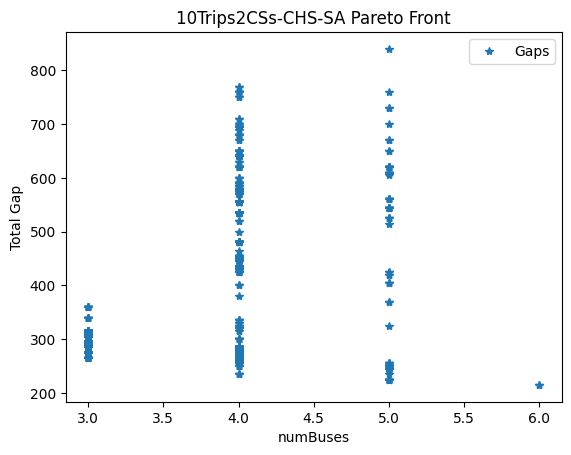

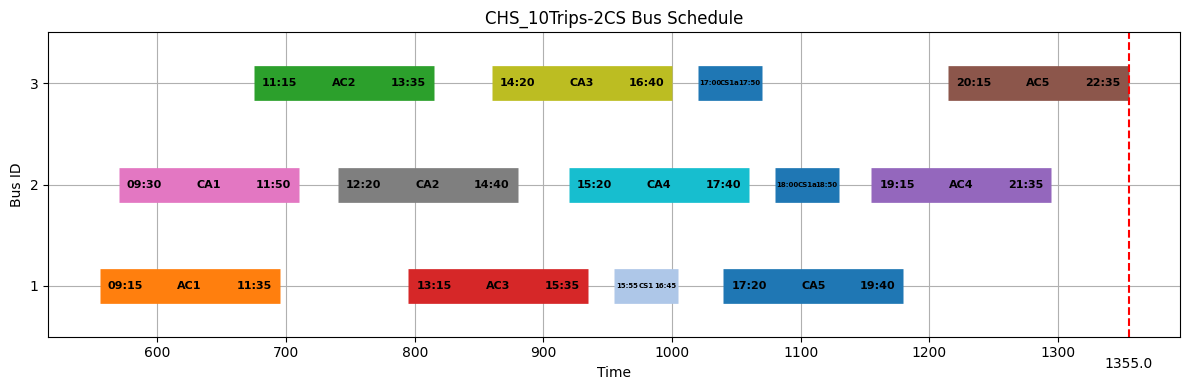

In [24]:
TenTrips_2cs_df = visualizeSolution(solutionspaces_10_2[1:], "10Trips2CSs-CHS-SA Pareto Front", all_schs_2cs, recharge_2cs_arcs)
newdf_10_2cs = visualizeResult(new_schedule_10_2, all_schs_2cs, "CHS_10Trips-2CS")
trips10_df_2cs = newdf_10_2cs.copy(deep=True)
trips10_df_2cs['next_dep'] = trips10_df_2cs.groupby('bus_id')['dep_time'].shift(-1).fillna(0)
trips10_df_2cs['difference'] = trips10_df_2cs['next_dep'] - trips10_df_2cs['arr_time']
trips10_df_2cs['difference'] = trips10_df_2cs['difference'].apply(lambda x: 0 if x < 0 else x)
trips10_soln_2cs = trips10_df_2cs.groupby(['bus_id'])['difference'].sum()
# trips10_df.to_csv("10Trips2CS.csv")
trips10_2cs = trips10_df_2cs.groupby(['bus_id']).agg({'trip_id':concat_str, 'dep_time': 'first', 'arr_time': 'last', 'dep_terminal': 'first', 'arr_terminal': 'last', 'difference': 'sum'})
chs_10Trips2cs_IDLE_soln = trips10_df_2cs.groupby(['bus_id']).agg(
    numRecharge=('trip_id',countRecharge),
    numTrips=('trip_id', countTrips),
    gapTime=('difference', 'sum')
)


In [25]:
################################################################### 3CS #############################################################################################
recharge_3cs_arcs = feasible_recharge(trips_df, cs_deadheads, recharge=charging_stations2, terminals=terminals)
print(recharge_3cs_arcs)
cs_ids = set(list(charging_stations2.keys()))
all_schedules_3cs = {**trips, **charging_stations2}
all_schs_3cs = pd.DataFrame.from_dict(all_schedules_3cs, orient='index')
all_schs_3cs['ID'] = range(len(all_schs_3cs))
durations_3cs = {idx: {'duration': all_schs_3cs.loc[idx, 'duration']} for idx in all_schs_3cs.index if idx != 0}

####### CHS
import time
start_time = time.time()
print(f"{time.ctime()}")
test_schedules_tab, schedules_10_3 = constructiveScheduler(all_schs_3cs, arcs, recharge_3cs_arcs, set(cs_ids))
test_solution = vectorSchRepresentation(schedules_10_3)
end_time = time.time()
g_T10CS3_time = end_time - start_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(g_T10CS3_time)} seconds")
print(f"number of buses = {len(schedules_10_3)}")
print(schedules_10_3)
####### SA
print('-'*100)
print("starting simulated annealing....")
start_time = time.time()
new_schedule_10_3, cost_10_3, cost_diffs_10_3, temp_10_3, it_10_3, costs_10_3, solutionspaces_10_3, best_10_3 = annealing(test_solution, all_schs_3cs, arcs, recharge_3cs_arcs)
end_time = time.time()
T10CS3_time = (end_time-start_time)+g_T10CS3_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(T10CS3_time)} seconds")
print(f"prev_schedule = {test_solution} with number of buses = {len(test_solution)}... \nnext_schedule = {new_schedule_10_3} with number of buses = {len(new_schedule_10_3)}")


{(1, 3, 11): {'duration': 30}, (1, 4, 11): {'duration': 30}, (1, 5, 11): {'duration': 30}, (1, 8, 11): {'duration': 30}, (1, 9, 11): {'duration': 30}, (1, 10, 11): {'duration': 30}, (2, 4, 11): {'duration': 30}, (2, 5, 11): {'duration': 30}, (2, 9, 11): {'duration': 30}, (2, 10, 11): {'duration': 30}, (3, 4, 11): {'duration': 30}, (3, 5, 11): {'duration': 30}, (3, 10, 11): {'duration': 30}, (6, 3, 11): {'duration': 30}, (6, 4, 11): {'duration': 30}, (6, 5, 11): {'duration': 30}, (6, 8, 11): {'duration': 30}, (6, 9, 11): {'duration': 30}, (6, 10, 11): {'duration': 30}, (7, 4, 11): {'duration': 30}, (7, 5, 11): {'duration': 30}, (7, 10, 11): {'duration': 30}, (8, 4, 11): {'duration': 30}, (8, 5, 11): {'duration': 30}, (9, 4, 11): {'duration': 30}, (9, 5, 11): {'duration': 30}, (1, 3, 12): {'duration': 75}, (1, 4, 12): {'duration': 75}, (1, 5, 12): {'duration': 75}, (2, 4, 12): {'duration': 75}, (2, 5, 12): {'duration': 75}, (3, 4, 12): {'duration': 75}, (3, 5, 12): {'duration': 75}, (6, 

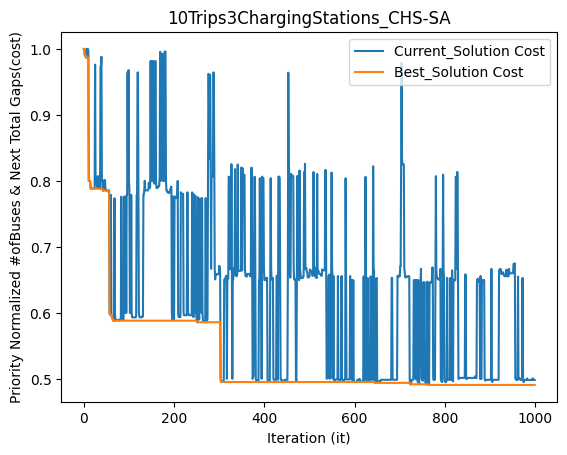

In [26]:
plt.plot(range(it_10_3), costs_10_3, label="Current_Solution Cost")
plt.plot(range(it_10_3), best_10_3, label="Best_Solution Cost")
plt.xlabel("Iteration (it)")
plt.ylabel("Priority Normalized #ofBuses & Next Total Gaps(cost)")
plt.title("10Trips3ChargingStations_CHS-SA")
plt.legend(loc="upper right")
# plt.savefig("10Trips3CSs.png")

     name   type  duration  dep_time  arr_time    dep_term    arr_term  ID
0   DEPOT  depot         0         0      1440           -           -   0
1     AC1   trip       140       555       695  Terminal A  Terminal C   1
2     AC2   trip       140       675       815  Terminal A  Terminal C   2
3     AC3   trip       140       795       935  Terminal A  Terminal C   3
4     AC4   trip       140      1155      1295  Terminal A  Terminal C   4
5     AC5   trip       140      1215      1355  Terminal A  Terminal C   5
6     CA1   trip       140       570       710  Terminal C  Terminal A   6
7     CA2   trip       140       740       880  Terminal C  Terminal A   7
8     CA3   trip       140       860      1000  Terminal C  Terminal A   8
9     CA4   trip       140       920      1060  Terminal C  Terminal A   9
10    CA5   trip       140      1040      1180  Terminal C  Terminal A  10
11    CS1     cs        50         0      1440           -           -  11
12   CS1a     cs        5

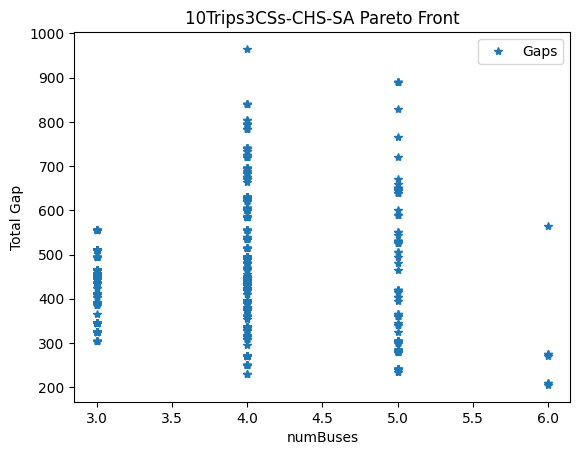

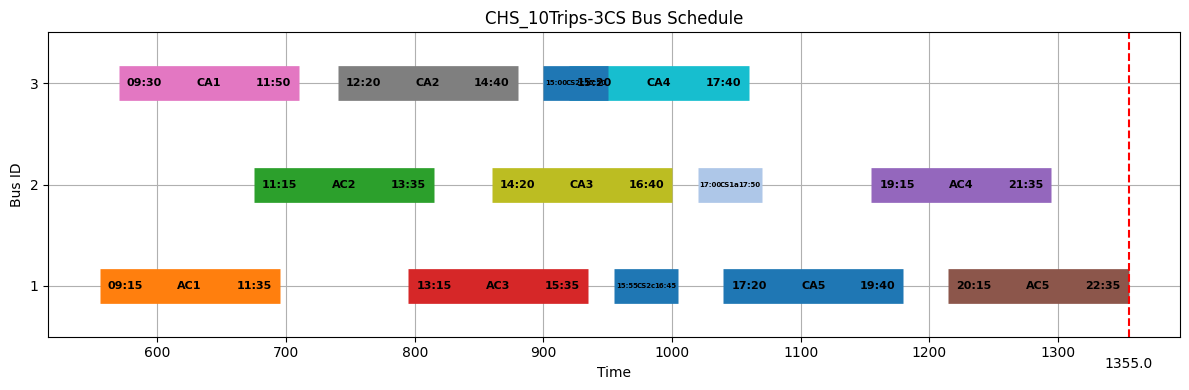

In [27]:
TenTrips_3cs_df = visualizeSolution(solutionspaces_10_3[1:], "10Trips3CSs-CHS-SA Pareto Front", all_schs_3cs, recharge_3cs_arcs)
newdf_10_3cs = visualizeResult(new_schedule_10_3, all_schs_3cs, "CHS_10Trips-3CS")
trips10_df_3cs = newdf_10_3cs.copy(deep=True)
trips10_df_3cs['next_dep'] = trips10_df_3cs.groupby('bus_id')['dep_time'].shift(-1).fillna(0)
trips10_df_3cs['difference'] = trips10_df_3cs['next_dep'] - trips10_df_3cs['arr_time']
trips10_df_3cs['difference'] = trips10_df_3cs['difference'].apply(lambda x: 0 if x < 0 else x)
trips10_soln_3cs = trips10_df_3cs.groupby(['bus_id'])['difference'].sum()

# trips10_df.to_csv("10Trips3cs.csv")
trips10_3cs = trips10_df_3cs.groupby(['bus_id']).agg({'trip_id':concat_str, 'dep_time': 'first', 'arr_time': 'last', 'dep_terminal': 'first', 'arr_terminal': 'last', 'difference': 'sum'})
chs_10Trips3cs_IDLE_soln = trips10_df_3cs.groupby(['bus_id']).agg(
    numRecharge=('trip_id',countRecharge),
    numTrips=('trip_id', countTrips),
    gapTime=('difference', 'sum')
)


In [28]:
cs_ids = ["CS1", "CS1a", "CS2b"]
# ################################################################################# 30 TRIPS ##################################################################################
trips = {
    0: {'name': 'DEPOT', 'type': 'depot', 'duration': 0, 'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    1: {'name': 'AB1', 'type': 'trip', 'duration': 135, 'dep_time': 560, 'arr_time': 695, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    2: {'name': 'AB2', 'type': 'trip', 'duration': 135, 'dep_time': 740, 'arr_time': 875, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    3: {'name': 'AB3', 'type': 'trip', 'duration': 135, 'dep_time': 830, 'arr_time': 965, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    4: {'name': 'AB4', 'type': 'trip', 'duration': 135, 'dep_time': 920, 'arr_time': 1055, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    5: {'name': 'AB5', 'type': 'trip', 'duration': 135, 'dep_time': 980, 'arr_time': 1115, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    6: {'name': 'AB6', 'type': 'trip', 'duration': 135, 'dep_time': 1040, 'arr_time': 1175, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    7: {'name': 'AB7', 'type': 'trip', 'duration': 135, 'dep_time': 1100, 'arr_time': 1235, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    8: {'name': 'AB8', 'type': 'trip', 'duration': 135, 'dep_time': 1190, 'arr_time': 1325, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    9: {'name': 'AC1', 'type': 'trip', 'duration': 140, 'dep_time': 555, 'arr_time': 695, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    10: {'name': 'AC2', 'type': 'trip', 'duration': 140, 'dep_time': 675, 'arr_time': 815, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    11: {'name': 'AC3', 'type': 'trip', 'duration': 140, 'dep_time': 795, 'arr_time': 935, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    12: {'name': 'AC4', 'type': 'trip', 'duration': 140, 'dep_time': 1155, 'arr_time': 1295, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    13: {'name': 'AC5', 'type': 'trip', 'duration': 140, 'dep_time': 1215, 'arr_time': 1355, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    14: {'name': 'AD1', 'type': 'trip', 'duration': 210, 'dep_time': 560, 'arr_time': 770, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    15: {'name': 'BA1', 'type': 'trip', 'duration': 135, 'dep_time': 540, 'arr_time': 675, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    16: {'name': 'BA2', 'type': 'trip', 'duration': 135, 'dep_time': 630, 'arr_time': 765, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    17: {'name': 'BA3', 'type': 'trip', 'duration': 135, 'dep_time': 720, 'arr_time': 855, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    18: {'name': 'BA4', 'type': 'trip', 'duration': 135, 'dep_time': 810, 'arr_time': 945, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    19: {'name': 'BA5', 'type': 'trip', 'duration': 135, 'dep_time': 900, 'arr_time': 1035, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    20: {'name': 'BA6', 'type': 'trip', 'duration': 135, 'dep_time': 990, 'arr_time': 1125, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    21: {'name': 'BA7', 'type': 'trip', 'duration': 135, 'dep_time': 1080, 'arr_time': 1215, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    22: {'name': 'BA8', 'type': 'trip', 'duration': 135, 'dep_time': 1140, 'arr_time': 1275, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    23: {'name': 'CA1', 'type': 'trip', 'duration': 140, 'dep_time': 570, 'arr_time': 710, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    24: {'name': 'CA2', 'type': 'trip', 'duration': 140, 'dep_time': 740, 'arr_time': 880, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    25: {'name': 'CA3', 'type': 'trip', 'duration': 140, 'dep_time': 860, 'arr_time': 1000, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    26: {'name': 'CA4', 'type': 'trip', 'duration': 140, 'dep_time': 920, 'arr_time': 1060, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    27: {'name': 'CA5', 'type': 'trip', 'duration': 140, 'dep_time': 1040, 'arr_time': 1180, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    28: {'name': 'CD1', 'type': 'trip', 'duration': 270, 'dep_time': 450, 'arr_time': 720, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    29: {'name': 'DA1', 'type': 'trip', 'duration': 210, 'dep_time': 860, 'arr_time': 1070, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    30: {'name': 'DC1', 'type': 'trip', 'duration': 270, 'dep_time': 810, 'arr_time': 1080, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'}
}

charging_station = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
}

charging_stations1 = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    len(trips) + 1: {'name': 'CS1a', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal A', 'arr_term': 'Terminal A'},
}

charging_stations2 = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    len(trips)+1: {'name': 'CS1a', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal A', 'arr_term': 'Terminal A'},
    len(trips)+2: {'name': 'CS2b', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal C', 'arr_term': 'Terminal C'},
}

# TERMINALS AND MINIMUM INTERVALS BETWEEN TRIPS
terminals = {
    'Terminal A': {'max_interval': 15},
    'Terminal B': {'max_interval': 15},
    'Terminal C': {'max_interval': 15},
    'Terminal D': {'max_interval': 15}
}
### Add extra parameter that allows e-Bus to complete schedule that is not continuous (aka the start node does not have to be the end node of the previous)
## Defining the deadhead parameter from Terminals
cs_deadheads = {
    'Terminal A': {'CS1': 30, 'CS1a': 10, 'CS2b': 30, 'CS3c': 30, 'CS4d': 30},
    'Terminal B': {'CS1': 30, 'CS1a': 30, 'CS2b': 10, 'CS3c': 30, 'CS4d': 30},
    'Terminal C': {'CS1': 30, 'CS1a': 30, 'CS2b': 30, 'CS3c': 10, 'CS4d': 30},
    'Terminal D': {'CS1': 30, 'CS1a': 30, 'CS2b': 30, 'CS3c': 10, 'CS4d': 10},
}

D_MAX = 350
CHARGING_TIME = 50
trips_df = pd.DataFrame.from_dict(trips, orient='index')
print(trips_df)
## Creating Gamma and Delta
arcs = feasible_pairs(trips_df, terminals)
print(charging_station)

     name   type  duration  dep_time  arr_time    dep_term    arr_term
0   DEPOT  depot         0         0      1440           -           -
1     AB1   trip       135       560       695  Terminal A  Terminal B
2     AB2   trip       135       740       875  Terminal A  Terminal B
3     AB3   trip       135       830       965  Terminal A  Terminal B
4     AB4   trip       135       920      1055  Terminal A  Terminal B
5     AB5   trip       135       980      1115  Terminal A  Terminal B
6     AB6   trip       135      1040      1175  Terminal A  Terminal B
7     AB7   trip       135      1100      1235  Terminal A  Terminal B
8     AB8   trip       135      1190      1325  Terminal A  Terminal B
9     AC1   trip       140       555       695  Terminal A  Terminal C
10    AC2   trip       140       675       815  Terminal A  Terminal C
11    AC3   trip       140       795       935  Terminal A  Terminal C
12    AC4   trip       140      1155      1295  Terminal A  Terminal C
13    

In [29]:
######################################################## 1CS #####################################################################
recharge_1cs_arcs = feasible_recharge(trips_df, cs_deadheads, recharge=charging_station, terminals=terminals)
cs_ids = set(list(charging_station.keys()))
all_schedules_1cs = {**trips, **charging_station}
all_schs_1cs = pd.DataFrame.from_dict(all_schedules_1cs, orient='index')
all_schs_1cs['ID'] = range(len(all_schs_1cs))
durations_1cs = {idx: {'duration': all_schs_1cs.loc[idx, 'duration']} for idx in all_schs_1cs.index if idx != 0}

###################################################### CHS-SA ####################################################################
import time
start_time = time.time()
print(f"{time.ctime()}")
schedules_tab, schedules_30_1 = constructiveScheduler(all_schs_1cs, arcs, recharge_1cs_arcs, cs_ids)
solution = vectorSchRepresentation(schedules_30_1)
end_time = time.time()
g_T30CS1_time = end_time - start_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(g_T30CS1_time)} seconds")
print(f"number of buses = {len(schedules_30_1)}")
print(schedules_30_1)

####### SA
print('-'*100)
start_time = time.time()
print("starting simulated annealing....")
new_schedule_30_1, cost_30_1, cost_diffs_30_1, temp_30_1, it_30_1, costs_30_1, solution_spaces_30_1, best_costs_30_1 = annealing(solution, all_schs_1cs, arcs, recharge_1cs_arcs)
end_time = time.time()
T30CS1_time = (end_time-start_time) + g_T30CS1_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(T30CS1_time)} seconds")
print(f"prev_schedule = {solution} with number of buses = {len(solution)}... \nnext_schedule = {new_schedule_30_1} with number of buses = {len(new_schedule_30_1)}")

print(f"Number of buses previous = {len(schedules_30_1)}... new = {len(new_schedule_30_1)} ")
print(f"Prev: {vectorSchRepresentation(schedules_30_1)}\nNew: {new_schedule_30_1}")
print(f"Total Gap among buses=> prev = {get_total_gap(solution, all_schs_1cs, recharge_1cs_arcs)}... new = {get_total_gap(new_schedule_30_1, all_schs_1cs, recharge_1cs_arcs)}")


Fri Feb 28 11:40:31 2025
Fri Feb 28 11:40:31 2025
Time elapse to compute the solution = 0.060417890548706055 seconds
number of buses = 11
[[(0, 28), (28, 3, 31), (3, 6), (6, 13), (13, 0)], [(0, 15), (15, 2), (2, 5, 31), (5, 8), (8, 0)], [(0, 9), (9, 17), (17, 20, 31), (20, 12), (12, 0)], [(0, 1), (1, 24), (24, 26), (26, 22, 31), (22, 0)], [(0, 14), (14, 4, 31), (4, 7), (7, 0)], [(0, 23), (23, 11), (11, 21, 31), (21, 0)], [(0, 16), (16, 18), (18, 27, 31), (27, 0)], [(0, 10), (10, 19), (19, 0)], [(0, 30), (30, 0)], [(0, 25), (25, 0)], [(0, 29), (29, 0)]]
----------------------------------------------------------------------------------------------------
starting simulated annealing....
Iteration 1...
swapping other CS...
proposed solution = [[10, 19, 0], [30, 0], [25, 0], [29, 0], [28, 31, 3, 6, 13, 0], [15, 2, 31, 5, 8, 0], [9, 17, 31, 20, 12, 0], [1, 24, 26, 31, 22, 0], [14, 31, 4, 7, 0], [23, 11, 31, 21, 0], [16, 18, 31, 27, 0]]
--------------------------------------------------------

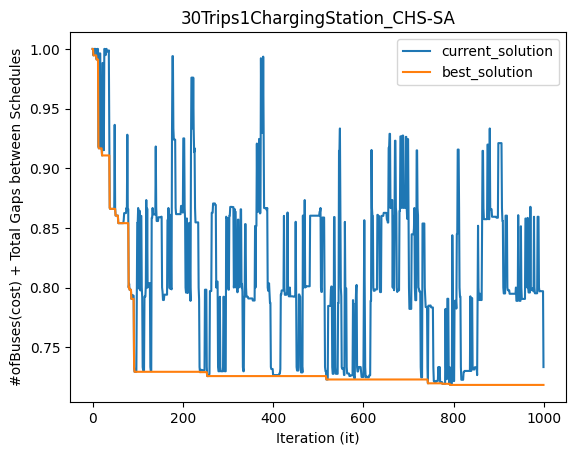

In [30]:
plt.plot(range(it_30_1), costs_30_1, label="current_solution")
plt.plot(range(it_30_1), best_costs_30_1, label="best_solution")
# plt.gca().invert_xaxis()
plt.xlabel("Iteration (it)")
# plt.ylabel("[weighted_sum] #ofBuses + Total Gap Time (cost)")
plt.ylabel("#ofBuses(cost) + Total Gaps between Schedules")
plt.title("30Trips1ChargingStation_CHS-SA")
plt.legend(loc="upper right")

     name   type  duration  dep_time  arr_time    dep_term    arr_term  ID
0   DEPOT  depot         0         0      1440           -           -   0
1     AB1   trip       135       560       695  Terminal A  Terminal B   1
2     AB2   trip       135       740       875  Terminal A  Terminal B   2
3     AB3   trip       135       830       965  Terminal A  Terminal B   3
4     AB4   trip       135       920      1055  Terminal A  Terminal B   4
5     AB5   trip       135       980      1115  Terminal A  Terminal B   5
6     AB6   trip       135      1040      1175  Terminal A  Terminal B   6
7     AB7   trip       135      1100      1235  Terminal A  Terminal B   7
8     AB8   trip       135      1190      1325  Terminal A  Terminal B   8
9     AC1   trip       140       555       695  Terminal A  Terminal C   9
10    AC2   trip       140       675       815  Terminal A  Terminal C  10
11    AC3   trip       140       795       935  Terminal A  Terminal C  11
12    AC4   trip       14

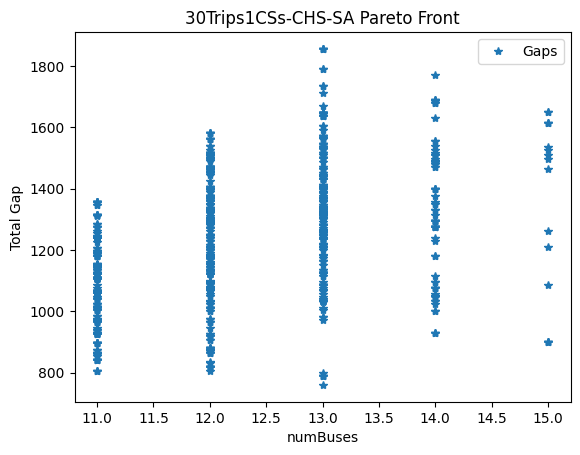

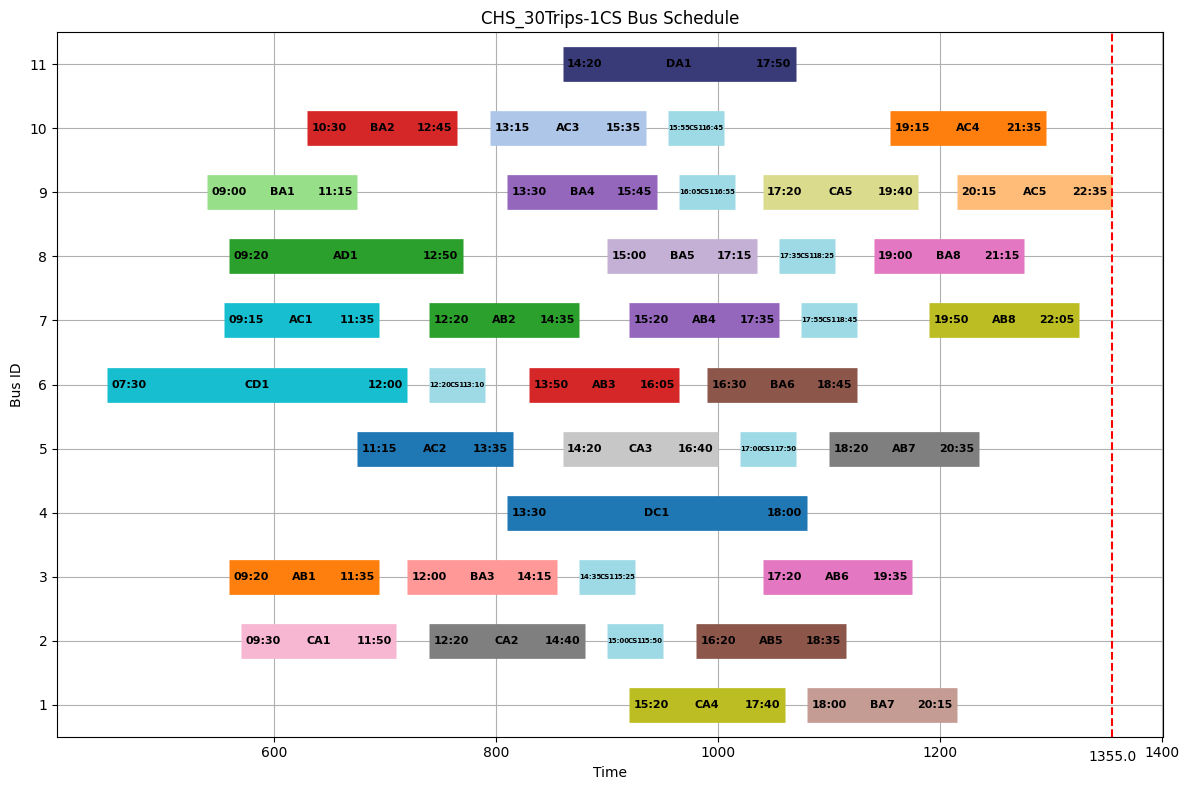

In [31]:
ThirtyTrips_1cs_df = visualizeSolution(solution_spaces_30_1[1:], "30Trips1CSs-CHS-SA Pareto Front", all_schs_1cs, recharge_1cs_arcs)
newdf_30_1cs = visualizeResult(new_schedule_30_1, all_schs_1cs, "CHS_30Trips-1CS")

trips30_df_1cs = newdf_30_1cs.copy(deep=True)
trips30_df_1cs['next_dep'] = trips30_df_1cs.groupby('bus_id')['dep_time'].shift(-1).fillna(0)
trips30_df_1cs['difference'] = trips30_df_1cs['next_dep'] - trips30_df_1cs['arr_time']
trips30_df_1cs['difference'] = trips30_df_1cs['difference'].apply(lambda x: 0 if x < 0 else x)
trips30_1cssoln = trips30_df_1cs.groupby(['bus_id'])['difference'].sum()

trips30_1cs = trips30_df_1cs.groupby(['bus_id']).agg({'trip_id':concat_str, 'dep_time': 'first', 'arr_time': 'last', 'dep_terminal': 'first', 'arr_terminal': 'last', 'difference': 'sum'})
trips30_1cs.sort_values(by=['difference'], ascending=False)
# trips30_df.to_csv("30Trips1CS.csv")
chs_30Trips1cs_IDLE_soln = trips30_1cs.groupby(['bus_id']).agg(
    trips=('trip_id', concat_str),
    numRecharge=('trip_id',countRecharge),
    numTrips=('trip_id', countTrips),
    gapTime=('difference', 'sum')
)

In [32]:
################################################################### 2CS #############################################################################################
## Creating Phi and Delta
recharge_2cs_arcs = feasible_recharge(trips_df, cs_deadheads, recharge=charging_stations1, terminals=terminals)
cs_ids = set(list(charging_stations1.keys()))
all_schedules_2cs = {**trips, **charging_stations1}
all_schs_2cs = pd.DataFrame.from_dict(all_schedules_2cs, orient='index')
all_schs_2cs['ID'] = range(len(all_schs_2cs))
durations_2cs = {idx: {'duration': all_schs_2cs.loc[idx, 'duration']} for idx in all_schs_2cs.index if idx != 0}

####### CHS
import time
start_time = time.time()
print(f"{time.ctime()}")
test_schedules_tab, schedules_30_2 = constructiveScheduler(all_schs_2cs, arcs, recharge_2cs_arcs, set(cs_ids))
test_solution = vectorSchRepresentation(schedules_30_2)
end_time = time.time()
g_T30CS2_time = end_time - start_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {g_T30CS2_time} seconds")
print(f"number of buses = {len(schedules_30_2)}")
print(schedules_30_2)
print('-'*100)
print("starting simulated annealing....")
start_time = time.time()
# test_new_schedule, test_cost, test_cost_diffs, test_temp, test_it, test_costs, test_solutionspaces, test_best = annealing(schedules_tab_2cs, all_schs_2cs, arcs, recharge_2cs_arcs)

new_schedule_30_2, cost_30_2, cost_diffs_30_2, temp_30_2, it_30_2, costs_30_2, solutionspaces_30_2, best_30_2 = annealing(test_solution, all_schs_2cs, arcs, recharge_2cs_arcs)
end_time = time.time()
T30CS2_time = (end_time-start_time) + g_T30CS2_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(T30CS2_time)} seconds")
print(f"{time.ctime()}\nTime elapse to compute the solution = {(end_time - start_time)} seconds")
print(f"prev_schedule = {test_solution} with number of buses = {len(test_solution)}... \nnext_schedule = {new_schedule_30_2} with number of buses = {len(new_schedule_30_2)}")


Fri Feb 28 11:51:27 2025
Fri Feb 28 11:51:27 2025
Time elapse to compute the solution = 0.05649566650390625 seconds
number of buses = 10
[[(0, 28), (28, 3, 31), (3, 6), (6, 13), (13, 0)], [(0, 15), (15, 2), (2, 5, 31), (5, 8), (8, 0)], [(0, 9), (9, 11), (11, 20), (20, 12, 32), (12, 0)], [(0, 1), (1, 17), (17, 4, 32), (4, 7), (7, 0)], [(0, 14), (14, 18), (18, 21, 31), (21, 0)], [(0, 23), (23, 24), (24, 26), (26, 22, 31), (22, 0)], [(0, 16), (16, 25, 31), (25, 27), (27, 0)], [(0, 10), (10, 19), (19, 0)], [(0, 30), (30, 0)], [(0, 29), (29, 0)]]
----------------------------------------------------------------------------------------------------
starting simulated annealing....
Iteration 1...
insertion...
proposed solution = [[28, 31, 3, 6, 13, 0], [15, 2, 31, 5, 8, 0], [9, 11, 20, 32, 12, 0], [1, 17, 32, 4, 7, 0], [14, 18, 31, 21, 0], [23, 24, 26, 31, 22, 0], [16, 31, 25, 27, 0], [10, 19, 0], [29, 0], [30, 0]]
--------------------------------------------------------------------------------

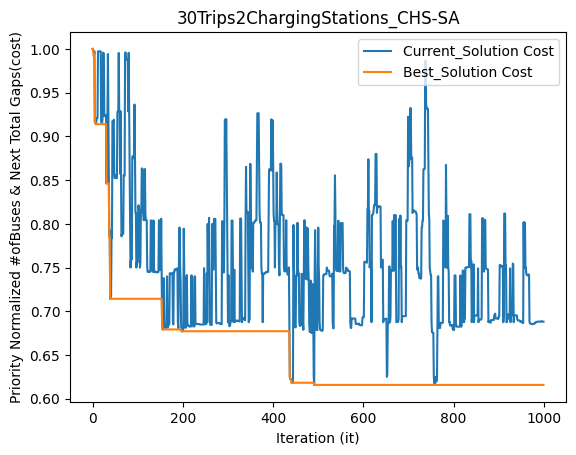

In [33]:
#### PLOTTING
plt.plot(range(it_30_2), costs_30_2, label="Current_Solution Cost")
plt.plot(range(it_30_2), best_30_2, label="Best_Solution Cost")
# plt.gca().invert_xaxis()
plt.xlabel("Iteration (it)")
# plt.ylabel("[weighted_sum] #ofBuses + Total Gap Time (cost)")
plt.ylabel("Priority Normalized #ofBuses & Next Total Gaps(cost)")
plt.title("30Trips2ChargingStations_CHS-SA")
plt.legend(loc="upper right")
plt.savefig("30Trips2CSs.png")

     name   type  duration  dep_time  arr_time    dep_term    arr_term  ID
0   DEPOT  depot         0         0      1440           -           -   0
1     AB1   trip       135       560       695  Terminal A  Terminal B   1
2     AB2   trip       135       740       875  Terminal A  Terminal B   2
3     AB3   trip       135       830       965  Terminal A  Terminal B   3
4     AB4   trip       135       920      1055  Terminal A  Terminal B   4
5     AB5   trip       135       980      1115  Terminal A  Terminal B   5
6     AB6   trip       135      1040      1175  Terminal A  Terminal B   6
7     AB7   trip       135      1100      1235  Terminal A  Terminal B   7
8     AB8   trip       135      1190      1325  Terminal A  Terminal B   8
9     AC1   trip       140       555       695  Terminal A  Terminal C   9
10    AC2   trip       140       675       815  Terminal A  Terminal C  10
11    AC3   trip       140       795       935  Terminal A  Terminal C  11
12    AC4   trip       14

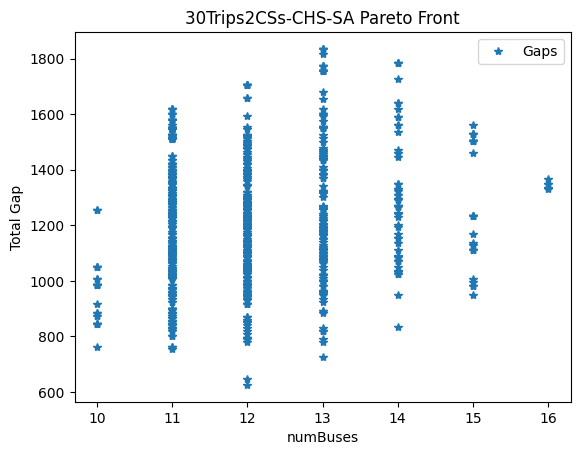

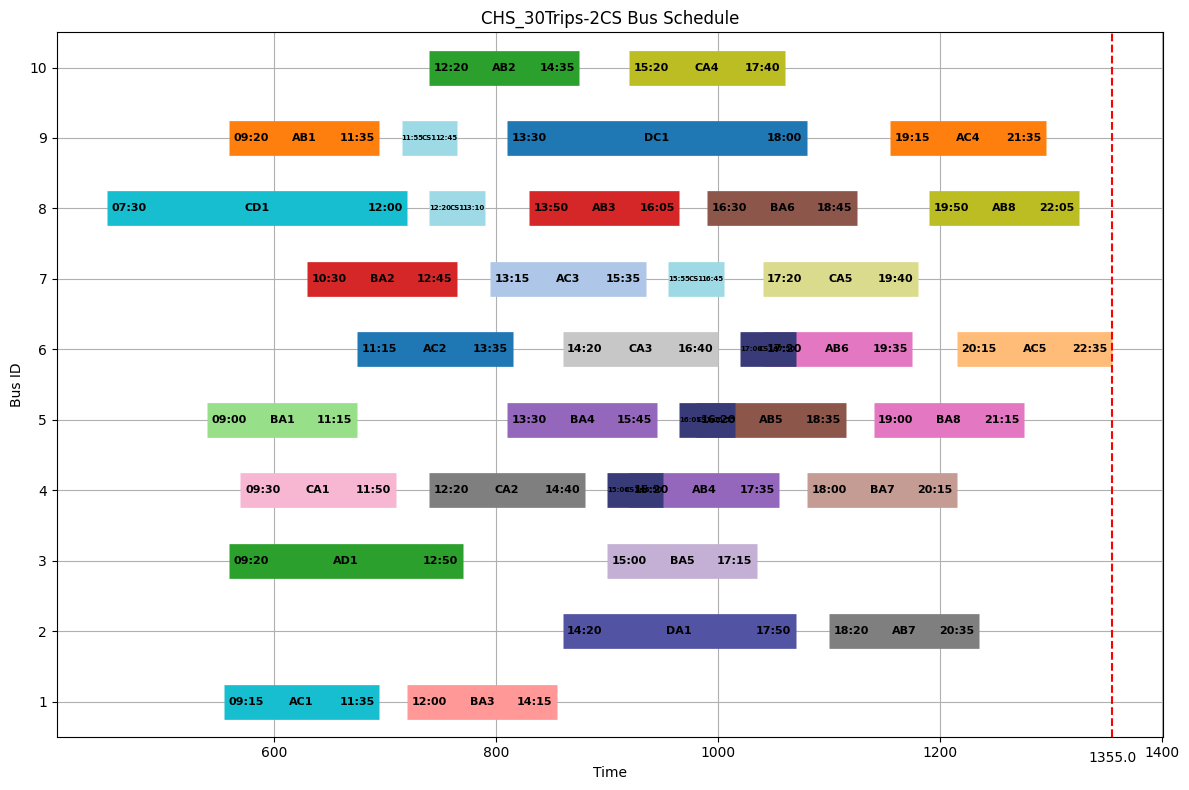

In [34]:
ThirtyTrips_2cs_df = visualizeSolution(solutionspaces_30_2[1:], "30Trips2CSs-CHS-SA Pareto Front", all_schs_2cs, recharge_2cs_arcs)
newdf_30_2cs = visualizeResult(new_schedule_30_2, all_schs_2cs, "CHS_30Trips-2CS")
trips30_df_2cs = newdf_30_2cs.copy(deep=True)
trips30_df_2cs['next_dep'] = trips30_df_2cs.groupby('bus_id')['dep_time'].shift(-1).fillna(0)
trips30_df_2cs['difference'] = trips30_df_2cs['next_dep'] - trips30_df_2cs['arr_time']
trips30_df_2cs['difference'] = trips30_df_2cs['difference'].apply(lambda x: 0 if x < 0 else x)
trips30_soln_2cs = trips30_df_2cs.groupby(['bus_id'])['difference'].sum()

# trips30_df.to_csv("30Trips2CS.csv")
chs_30Trips2cs_IDLE_soln = trips30_df_2cs.groupby(['bus_id']).agg({'trip_id':concat_str, 'dep_time': 'first', 'arr_time': 'last', 'dep_terminal': 'first', 'arr_terminal': 'last', 'difference': 'sum'})
chs_30Trips2cs_IDLE_soln = trips30_df_2cs.groupby(['bus_id']).agg(
    trips=('trip_id', concat_str),
    numRecharge=('trip_id',countRecharge),
    numTrips=('trip_id', countTrips),
    gapTime=('difference', 'sum')
)

In [35]:
################################################################### 3CS #############################################################################################
## Creating Phi and Delta
recharge_3cs_arcs = feasible_recharge(trips_df, cs_deadheads, recharge=charging_stations2, terminals=terminals)
cs_ids = set(list(charging_stations2.keys()))
all_schedules_3cs = {**trips, **charging_stations2}
all_schs_3cs = pd.DataFrame.from_dict(all_schedules_3cs, orient='index')
all_schs_3cs['ID'] = range(len(all_schs_3cs))
durations_3cs = {idx: {'duration': all_schs_3cs.loc[idx, 'duration']} for idx in all_schs_3cs.index if idx != 0}

####### CHS
start_time = time.time()
print(f"{time.ctime()}")
test_schedules_tab, schedules_30_3 = constructiveScheduler(all_schs_3cs, arcs, recharge_3cs_arcs, set(cs_ids))
test_solution = vectorSchRepresentation(schedules_30_3)
end_time = time.time()
g_T30CS3_time = end_time - start_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(end_time - start_time)} seconds")
print(f"number of buses = {len(schedules_30_3)}")
print(schedules_30_3)
print('-'*100)
print("starting simulated annealing....")
start_time = time.time()
new_schedule_30_3, cost_30_3, cost_diffs_30_3, temp_30_3, it_30_3, costs_30_3, solutionspaces_30_3, best_30_3 = annealing(test_solution, all_schs_3cs, arcs, recharge_3cs_arcs)
end_time = time.time()
T30CS3_time = (end_time-start_time) + g_T30CS3_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(T30CS3_time)} seconds")
print(f"prev_schedule = {test_solution} with number of buses = {len(test_solution)}... \nnext_schedule = {new_schedule_30_3} with number of buses = {len(new_schedule_30_3)}")


Fri Feb 28 12:02:06 2025
Fri Feb 28 12:02:06 2025
Time elapse to compute the solution = 0.06649303436279297 seconds
number of buses = 10
[[(0, 28), (28, 3, 31), (3, 6), (6, 13), (13, 0)], [(0, 15), (15, 2), (2, 5, 31), (5, 8), (8, 0)], [(0, 9), (9, 11), (11, 20), (20, 12, 32), (12, 0)], [(0, 1), (1, 17), (17, 4, 32), (4, 7), (7, 0)], [(0, 14), (14, 18), (18, 21, 31), (21, 0)], [(0, 23), (23, 24), (24, 26, 33), (26, 22), (22, 0)], [(0, 16), (16, 25), (25, 27, 33), (27, 0)], [(0, 10), (10, 19), (19, 0)], [(0, 30), (30, 0)], [(0, 29), (29, 0)]]
----------------------------------------------------------------------------------------------------
starting simulated annealing....
Iteration 1...
insertion...
proposed solution = [[28, 31, 3, 6, 13, 0], [15, 2, 31, 5, 8, 0], [9, 11, 20, 32, 12, 0], [1, 17, 32, 4, 7, 0], [14, 18, 31, 21, 0], [23, 24, 33, 26, 22, 0], [16, 25, 33, 27, 0], [10, 19, 0], [29, 0], [30, 0]]
--------------------------------------------------------------------------------

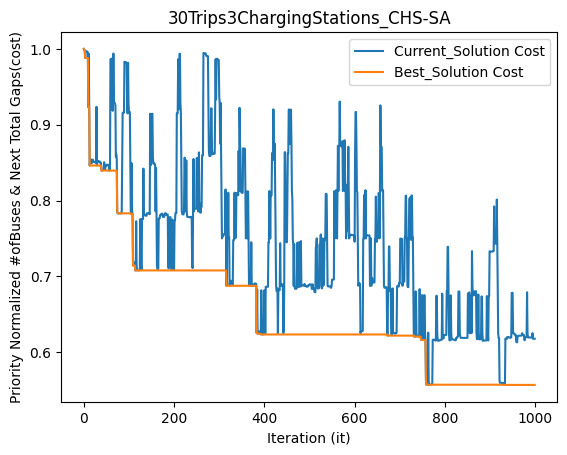

In [36]:
#### PLOTTING
plt.plot(range(it_30_3), costs_30_3, label="Current_Solution Cost")
plt.plot(range(it_30_3), best_30_3, label="Best_Solution Cost")
# plt.gca().invert_xaxis()
plt.xlabel("Iteration (it)")
# plt.ylabel("[weighted_sum] #ofBuses + Total Gap Time (cost)")
plt.ylabel("Priority Normalized #ofBuses & Next Total Gaps(cost)")
plt.title("30Trips3ChargingStations_CHS-SA")
plt.legend(loc="upper right")
plt.savefig("30Trips3CSs.png")

     name   type  duration  dep_time  arr_time    dep_term    arr_term  ID
0   DEPOT  depot         0         0      1440           -           -   0
1     AB1   trip       135       560       695  Terminal A  Terminal B   1
2     AB2   trip       135       740       875  Terminal A  Terminal B   2
3     AB3   trip       135       830       965  Terminal A  Terminal B   3
4     AB4   trip       135       920      1055  Terminal A  Terminal B   4
5     AB5   trip       135       980      1115  Terminal A  Terminal B   5
6     AB6   trip       135      1040      1175  Terminal A  Terminal B   6
7     AB7   trip       135      1100      1235  Terminal A  Terminal B   7
8     AB8   trip       135      1190      1325  Terminal A  Terminal B   8
9     AC1   trip       140       555       695  Terminal A  Terminal C   9
10    AC2   trip       140       675       815  Terminal A  Terminal C  10
11    AC3   trip       140       795       935  Terminal A  Terminal C  11
12    AC4   trip       14

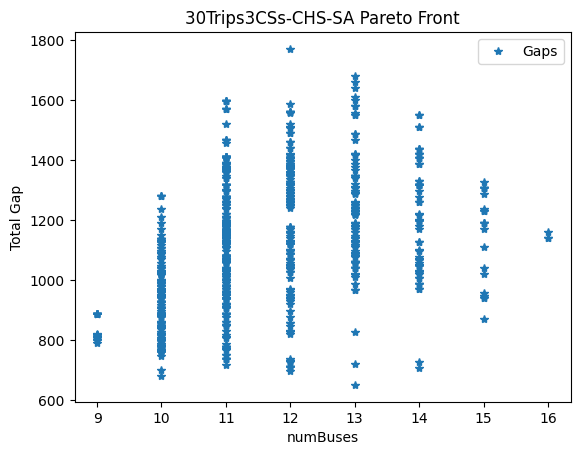

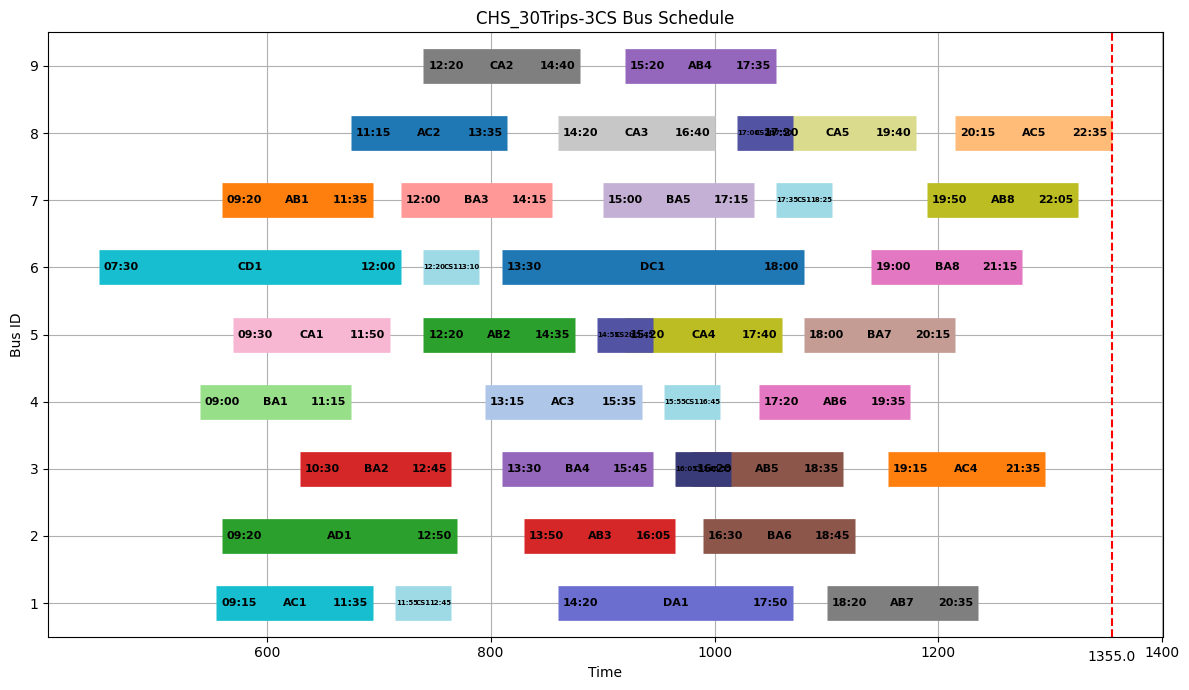

In [37]:
ThirtyTrips_3cs_df = visualizeSolution(solutionspaces_30_3[1:], "30Trips3CSs-CHS-SA Pareto Front", all_schs_3cs, recharge_3cs_arcs)
newdf_30_3cs = visualizeResult(new_schedule_30_3, all_schs_3cs, "CHS_30Trips-3CS")
trips30_df_3cs = newdf_30_3cs.copy(deep=True)
trips30_df_3cs['next_dep'] = trips30_df_3cs.groupby('bus_id')['dep_time'].shift(-1).fillna(0)
trips30_df_3cs['difference'] = trips30_df_3cs['next_dep'] - trips30_df_3cs['arr_time']
trips30_df_3cs['difference'] = trips30_df_3cs['difference'].apply(lambda x: 0 if x < 0 else x)
trips30_soln_3cs = trips30_df_3cs.groupby(['bus_id'])['difference'].sum()
#trips30_df.to_csv("30Trips3cs.csv")
chs_30Trips3cs_IDLE_soln = trips30_df_3cs.groupby(['bus_id']).agg({'trip_id':concat_str, 'dep_time': 'first', 'arr_time': 'last', 'dep_terminal': 'first', 'arr_terminal': 'last', 'difference': 'sum'})
chs_30Trips3cs_IDLE_soln = trips30_df_3cs.groupby(['bus_id']).agg(
    trips=('trip_id', concat_str),
    numRecharge=('trip_id',countRecharge),
    numTrips=('trip_id', countTrips),
    gapTime=('difference', 'sum')
)

In [8]:
################################################################################### 54 TRIPS ###############################################################################################
trips = {
    0: {'name': 'DEPOT', 'type': 'depot', 'duration': 0, 'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    1: {'name': 'AB1', 'type': 'trip', 'duration': 135, 'dep_time': 560, 'arr_time': 695, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    2: {'name': 'AB2', 'type': 'trip', 'duration': 135, 'dep_time': 740, 'arr_time': 875, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    3: {'name': 'AB3', 'type': 'trip', 'duration': 135, 'dep_time': 830, 'arr_time': 965, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    4: {'name': 'AB4', 'type': 'trip', 'duration': 135, 'dep_time': 920, 'arr_time': 1055, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    5: {'name': 'AB5', 'type': 'trip', 'duration': 135, 'dep_time': 980, 'arr_time': 1115, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    6: {'name': 'AB6', 'type': 'trip', 'duration': 135, 'dep_time': 1040, 'arr_time': 1175, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    7: {'name': 'AB7', 'type': 'trip', 'duration': 135, 'dep_time': 1100, 'arr_time': 1235, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    8: {'name': 'AB8', 'type': 'trip', 'duration': 135, 'dep_time': 1190, 'arr_time': 1325, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    9: {'name': 'AC1', 'type': 'trip', 'duration': 140, 'dep_time': 555, 'arr_time': 695, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    10: {'name': 'AC2', 'type': 'trip', 'duration': 140, 'dep_time': 675, 'arr_time': 815, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    11: {'name': 'AC3', 'type': 'trip', 'duration': 140, 'dep_time': 795, 'arr_time': 935, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    12: {'name': 'AC4', 'type': 'trip', 'duration': 140, 'dep_time': 1155, 'arr_time': 1295, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    13: {'name': 'AC5', 'type': 'trip', 'duration': 140, 'dep_time': 1215, 'arr_time': 1355, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    14: {'name': 'AD1', 'type': 'trip', 'duration': 140, 'dep_time': 560, 'arr_time': 700, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    15: {'name': 'AD2', 'type': 'trip', 'duration': 140, 'dep_time': 630, 'arr_time': 770, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    16: {'name': 'AD3', 'type': 'trip', 'duration': 135, 'dep_time': 790, 'arr_time': 925, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    17: {'name': 'AD4', 'type': 'trip', 'duration': 140, 'dep_time': 970, 'arr_time': 1110, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    18: {'name': 'AD5', 'type': 'trip', 'duration': 140, 'dep_time': 1120, 'arr_time': 1240, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    19: {'name': 'BA1', 'type': 'trip', 'duration': 135, 'dep_time': 540, 'arr_time': 675, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    20: {'name': 'BA2', 'type': 'trip', 'duration': 135, 'dep_time': 630, 'arr_time': 765, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    21: {'name': 'BA3', 'type': 'trip', 'duration': 135, 'dep_time': 720, 'arr_time': 855, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    22: {'name': 'BA4', 'type': 'trip', 'duration': 135, 'dep_time': 810, 'arr_time': 945, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    23: {'name': 'BA5', 'type': 'trip', 'duration': 135, 'dep_time': 900, 'arr_time': 1035, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    24: {'name': 'BA6', 'type': 'trip', 'duration': 135, 'dep_time': 990, 'arr_time': 1125, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    25: {'name': 'BA7', 'type': 'trip', 'duration': 135, 'dep_time': 1080, 'arr_time': 1215, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    26: {'name': 'BA8', 'type': 'trip', 'duration': 135, 'dep_time': 1140, 'arr_time': 1275, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    27: {'name': 'BC1', 'type': 'trip', 'duration': 140, 'dep_time': 435, 'arr_time': 570, 'dep_term': 'Terminal B', 'arr_term': 'Terminal C'},
    28: {'name': 'BC2', 'type': 'trip', 'duration': 140, 'dep_time': 595, 'arr_time': 735, 'dep_term': 'Terminal B', 'arr_term': 'Terminal C'},
    29: {'name': 'BC3', 'type': 'trip', 'duration': 120, 'dep_time': 800, 'arr_time': 920, 'dep_term': 'Terminal B', 'arr_term': 'Terminal C'},
    30: {'name': 'BC4', 'type': 'trip', 'duration': 130, 'dep_time': 950, 'arr_time': 1130, 'dep_term': 'Terminal B', 'arr_term': 'Terminal C'},
    31: {'name': 'CA1', 'type': 'trip', 'duration': 140, 'dep_time': 570, 'arr_time': 710, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    32: {'name': 'CA2', 'type': 'trip', 'duration': 140, 'dep_time': 740, 'arr_time': 880, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    33: {'name': 'CA3', 'type': 'trip', 'duration': 140, 'dep_time': 860, 'arr_time': 1000, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    34: {'name': 'CA4', 'type': 'trip', 'duration': 140, 'dep_time': 920, 'arr_time': 1060, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    35: {'name': 'CA5', 'type': 'trip', 'duration': 140, 'dep_time': 1040, 'arr_time': 1180, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    36: {'name': 'CB1', 'type': 'trip', 'duration': 120, 'dep_time': 300, 'arr_time': 420, 'dep_term': 'Terminal C', 'arr_term': 'Terminal B'},
    37: {'name': 'CB2', 'type': 'trip', 'duration': 140, 'dep_time': 540, 'arr_time': 680, 'dep_term': 'Terminal C', 'arr_term': 'Terminal B'},
    38: {'name': 'CB3', 'type': 'trip', 'duration': 140, 'dep_time': 645, 'arr_time': 785, 'dep_term': 'Terminal C', 'arr_term': 'Terminal B'},
    39: {'name': 'CB4', 'type': 'trip', 'duration': 120, 'dep_time': 900, 'arr_time': 1020, 'dep_term': 'Terminal C', 'arr_term': 'Terminal B'},
    40: {'name': 'CD1', 'type': 'trip', 'duration': 140, 'dep_time': 450, 'arr_time': 585, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    41: {'name': 'CD2', 'type': 'trip', 'duration': 135, 'dep_time': 550, 'arr_time': 685, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    42: {'name': 'CD3', 'type': 'trip', 'duration': 135, 'dep_time': 600, 'arr_time': 735, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    43: {'name': 'CD4', 'type': 'trip', 'duration': 135, 'dep_time': 765, 'arr_time': 900, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    44: {'name': 'CD5', 'type': 'trip', 'duration': 120, 'dep_time': 850, 'arr_time': 970, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    45: {'name': 'DA1', 'type': 'trip', 'duration': 140, 'dep_time': 720, 'arr_time': 860, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    46: {'name': 'DA2', 'type': 'trip', 'duration': 135, 'dep_time': 750, 'arr_time': 885, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    47: {'name': 'DA3', 'type': 'trip', 'duration': 140, 'dep_time': 800, 'arr_time': 940, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    48: {'name': 'DA4', 'type': 'trip', 'duration': 140, 'dep_time': 1000, 'arr_time': 1140, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    49: {'name': 'DA5', 'type': 'trip', 'duration': 140, 'dep_time': 1200, 'arr_time': 1340, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    50: {'name': 'DC1', 'type': 'trip', 'duration': 140, 'dep_time': 600, 'arr_time': 740, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'},
    51: {'name': 'DC2', 'type': 'trip', 'duration': 120, 'dep_time': 765, 'arr_time': 885, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'},
    52: {'name': 'DC3', 'type': 'trip', 'duration': 120, 'dep_time': 780, 'arr_time': 900, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'},
    53: {'name': 'DC4', 'type': 'trip', 'duration': 135, 'dep_time': 965, 'arr_time': 1100, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'},
    54: {'name': 'DC5', 'type': 'trip', 'duration': 135, 'dep_time': 975, 'arr_time': 1110, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'}
}

charging_station = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
}

charging_stations1 = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    len(trips)+1: {'name': 'CS1a', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal A', 'arr_term': 'Terminal A'},
}

charging_stations2 = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    len(trips)+1: {'name': 'CS1a', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal A', 'arr_term': 'Terminal A'},
    len(trips)+2: {'name': 'CS2b', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal B', 'arr_term': 'Terminal B'},
}

# TERMINALS AND MINIMUM INTERVALS BETWEEN TRIPS
terminals = {
    'Terminal A': {'max_interval': 15},
    'Terminal B': {'max_interval': 15},
    'Terminal C': {'max_interval': 15},
    'Terminal D': {'max_interval': 15}
}
### Add extra parameter that allows e-Bus to complete schedule that is not continuous (aka the start node does not have to be the end node of the previous)
## Defining the deadhead parameter from Terminals
cs_deadheads = {
    'Terminal A': {'CS1': 40, 'CS1a': 10, 'CS2b': 75, 'CS3c': 75, 'CS4d': 75},
    'Terminal B': {'CS1': 40, 'CS1a': 75, 'CS2b': 10, 'CS3c': 75, 'CS4d': 75},
    'Terminal C': {'CS1': 40, 'CS1a': 75, 'CS2b': 75, 'CS3c': 10, 'CS4d': 75},
    'Terminal D': {'CS1': 40, 'CS1a': 75, 'CS2b': 75, 'CS3c': 75, 'CS4d': 10},
}

D_MAX = 350
CHARGING_TIME = 100
trips_df = pd.DataFrame.from_dict(trips, orient='index')
print(trips_df)
## Creating Gamma and Delta
arcs = feasible_pairs(trips_df, terminals)
print(charging_station)


     name   type  duration  dep_time  arr_time    dep_term    arr_term
0   DEPOT  depot         0         0      1440           -           -
1     AB1   trip       135       560       695  Terminal A  Terminal B
2     AB2   trip       135       740       875  Terminal A  Terminal B
3     AB3   trip       135       830       965  Terminal A  Terminal B
4     AB4   trip       135       920      1055  Terminal A  Terminal B
5     AB5   trip       135       980      1115  Terminal A  Terminal B
6     AB6   trip       135      1040      1175  Terminal A  Terminal B
7     AB7   trip       135      1100      1235  Terminal A  Terminal B
8     AB8   trip       135      1190      1325  Terminal A  Terminal B
9     AC1   trip       140       555       695  Terminal A  Terminal C
10    AC2   trip       140       675       815  Terminal A  Terminal C
11    AC3   trip       140       795       935  Terminal A  Terminal C
12    AC4   trip       140      1155      1295  Terminal A  Terminal C
13    

In [9]:
######################################################## 1CS #####################################################################
recharge_1cs_arcs = feasible_recharge(trips_df, cs_deadheads, recharge=charging_station, terminals=terminals)
cs_ids = set(list(charging_station.keys()))
all_schedules_1cs = {**trips, **charging_station}
all_schs_1cs = pd.DataFrame.from_dict(all_schedules_1cs, orient='index')
all_schs_1cs['ID'] = range(len(all_schs_1cs))
durations_1cs = {idx: {'duration': all_schs_1cs.loc[idx, 'duration']} for idx in all_schs_1cs.index if idx != 0}
###################################################### CHS-SA ####################################################################

start_time = time.time()
print(f"{time.ctime()}")
schedules_tab, schedules_54_1 = constructiveScheduler(all_schs_1cs, arcs, recharge_1cs_arcs, cs_ids)
solution = vectorSchRepresentation(schedules_54_1)
end_time = time.time()
g_T54CS1_time = end_time - start_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(g_T54CS1_time)} seconds")
print(f"number of buses = {len(schedules_54_1)}")
print(schedules_54_1)
print('-'*100)
start_time = time.time()
print("starting simulated annealing....")
new_schedule_54_1, cost_54_1, cost_diffs_54_1, temp_54_1, it_54_1, costs_54_1, solution_spaces_54_1, best_costs_54_1 = annealing(solution, all_schs_1cs, arcs, recharge_1cs_arcs)
end_time = time.time()
T54CS1_time = (end_time-start_time)+g_T54CS1_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(T54CS1_time)} seconds")
print(f"prev_schedule = {solution} with number of buses = {len(solution)}... \nnext_schedule = {new_schedule_54_1} with number of buses = {len(new_schedule_54_1)}")


Fri Feb 28 09:15:18 2025
Fri Feb 28 09:15:21 2025
Time elapse to compute the solution = 3.6583046913146973 seconds
number of buses = 19
[[(0, 36), (36, 40), (40, 45, 55), (45, 39), (39, 35), (35, 13), (13, 0)], [(0, 27), (27, 15), (15, 16), (16, 6, 55), (6, 49), (49, 0)], [(0, 19), (19, 2), (2, 5, 55), (5, 8), (8, 0)], [(0, 37), (37, 21), (21, 17, 55), (17, 12), (12, 0)], [(0, 41), (41, 32), (32, 54, 55), (54, 26), (26, 0)], [(0, 9), (9, 3), (3, 7, 55), (7, 0)], [(0, 1), (1, 11), (11, 18, 55), (18, 0)], [(0, 14), (14, 22), (22, 25, 55), (25, 0)], [(0, 31), (31, 43), (43, 24, 55), (24, 0)], [(0, 28), (28, 51), (51, 48, 55), (48, 0)], [(0, 42), (42, 4), (4, 0)], [(0, 50), (50, 23), (23, 0)], [(0, 20), (20, 29), (29, 0)], [(0, 38), (38, 30), (30, 0)], [(0, 10), (10, 33), (33, 0)], [(0, 46), (46, 34), (34, 0)], [(0, 52), (52, 53), (53, 0)], [(0, 47), (47, 0)], [(0, 44), (44, 0)]]
----------------------------------------------------------------------------------------------------
starting s

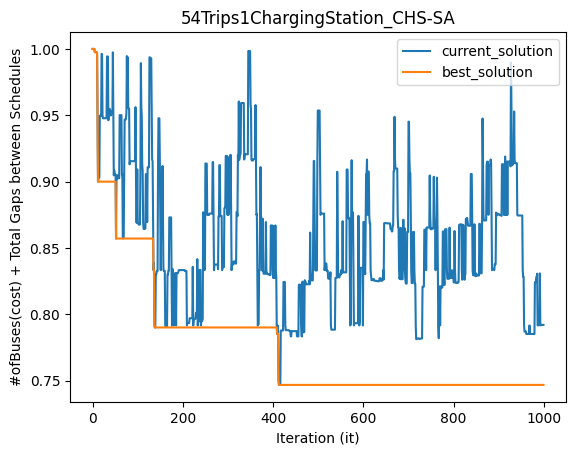

In [10]:
plt.plot(range(it_54_1), costs_54_1, label="current_solution")
plt.plot(range(it_54_1), best_costs_54_1, label="best_solution")
# plt.gca().invert_xaxis()
plt.xlabel("Iteration (it)")
# plt.ylabel("[weighted_sum] #ofBuses + Total Gap Time (cost)")
plt.ylabel("#ofBuses(cost) + Total Gaps between Schedules")
plt.title("54Trips1ChargingStation_CHS-SA")
plt.legend(loc="upper right")
#plt.savefig("54Trips1CS.png")

     name   type  duration  dep_time  arr_time    dep_term    arr_term  ID
0   DEPOT  depot         0         0      1440           -           -   0
1     AB1   trip       135       560       695  Terminal A  Terminal B   1
2     AB2   trip       135       740       875  Terminal A  Terminal B   2
3     AB3   trip       135       830       965  Terminal A  Terminal B   3
4     AB4   trip       135       920      1055  Terminal A  Terminal B   4
5     AB5   trip       135       980      1115  Terminal A  Terminal B   5
6     AB6   trip       135      1040      1175  Terminal A  Terminal B   6
7     AB7   trip       135      1100      1235  Terminal A  Terminal B   7
8     AB8   trip       135      1190      1325  Terminal A  Terminal B   8
9     AC1   trip       140       555       695  Terminal A  Terminal C   9
10    AC2   trip       140       675       815  Terminal A  Terminal C  10
11    AC3   trip       140       795       935  Terminal A  Terminal C  11
12    AC4   trip       14

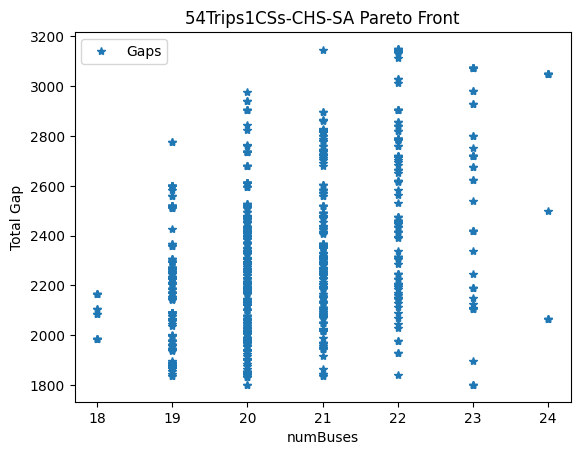

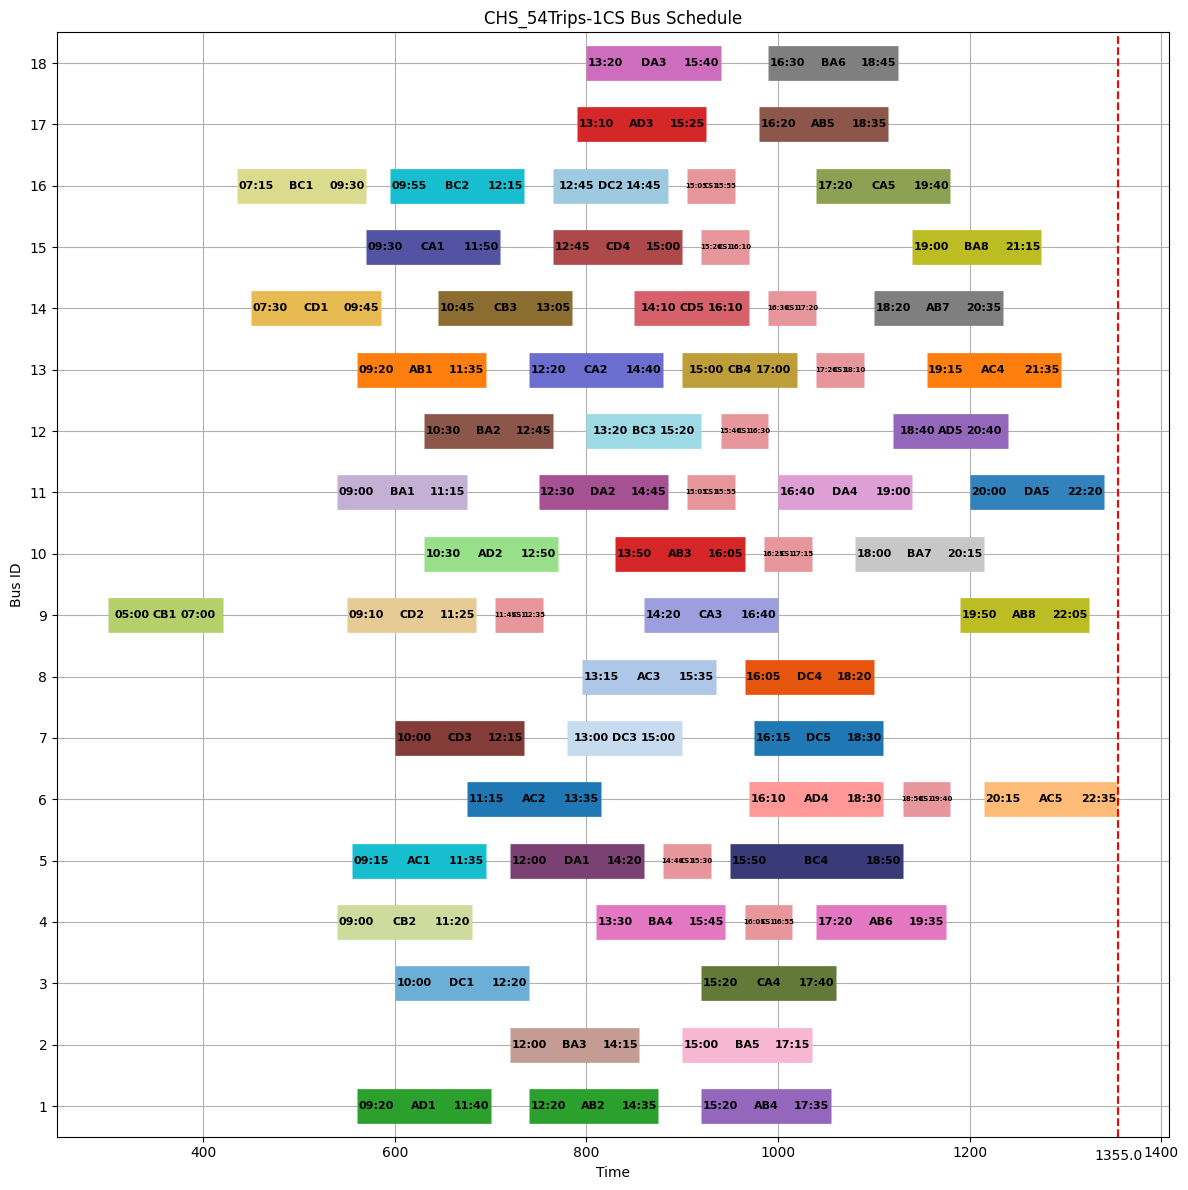

In [11]:
FiftyTrips_1cs_df = visualizeSolution(solution_spaces_54_1[1:], "54Trips1CSs-CHS-SA Pareto Front", all_schs_1cs, recharge_1cs_arcs)
newdf_54_1cs = visualizeResult(new_schedule_54_1, all_schs_1cs, "CHS_54Trips-1CS")

trips54_1_df = newdf_54_1cs.copy(deep=True)
trips54_1_df['next_dep'] = trips54_1_df.groupby('bus_id')['dep_time'].shift(-1).fillna(0)
trips54_1_df['difference'] = trips54_1_df['next_dep'] - trips54_1_df['arr_time']
trips54_1_df['difference'] = trips54_1_df['difference'].apply(lambda x: 0 if x < 0 else x)
trips54_1_soln = trips54_1_df.groupby(['bus_id'])['difference'].sum()

chs_54Trips1cs_IDLE_soln = trips54_1_df.groupby(['bus_id']).agg(
    trips=('trip_id', concat_str),
    numRecharge=('trip_id',countRecharge),
    numTrips=('trip_id', countTrips),
    gapTime=('difference', 'sum')
)
chs_54Trips1cs_IDLE_soln.sort_values(['gapTime'], ascending=False)
print("Ending the process for 54Trips and 1 CS......")

In [12]:
################################################################ 2 CS ##################################################################################
## Creating Phi and Delta
recharge_2cs_arcs = feasible_recharge(trips_df, cs_deadheads, recharge=charging_stations1, terminals=terminals)
print(recharge_2cs_arcs)
cs_ids = set(list(charging_stations1.keys()))
all_schedules_2cs = {**trips, **charging_stations1}
all_schs_2cs = pd.DataFrame.from_dict(all_schedules_2cs, orient='index')
all_schs_2cs['ID'] = range(len(all_schs_2cs))
durations_2cs = {idx: {'duration': all_schs_2cs.loc[idx, 'duration']} for idx in all_schs_2cs.index if idx != 0}

start_time = time.time()
print(f"{time.ctime()}")
test_schedules_tab, schedules_54_2 = constructiveScheduler(all_schs_2cs, arcs, recharge_2cs_arcs, set(cs_ids))
test_solution = vectorSchRepresentation(schedules_54_2)
end_time = time.time()
g_T54CS2_time = end_time - start_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(g_T54CS2_time)} seconds")
print(f"number of buses = {len(schedules_54_2)}")
print(schedules_54_2)
print('-'*100)
print("starting simulated annealing....")
start_time = time.time()
new_schedule_54_2, cost_54_2, cost_diffs_54_2, temp_54_2, it_54_2, costs_54_2, solutionspaces_54_2, best_54_2 = annealing(test_solution, all_schs_2cs, arcs, recharge_2cs_arcs)
end_time = time.time()
T54CS2_time = (end_time - start_time) + g_T54CS2_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(T54CS2_time)} seconds")
print(f"prev_schedule = {test_solution} with number of buses = {len(test_solution)}... \nnext_schedule = {new_schedule_54_2} with number of buses = {len(new_schedule_54_2)}")


{(1, 3, 55): {'duration': 40}, (1, 4, 55): {'duration': 40}, (1, 5, 55): {'duration': 40}, (1, 6, 55): {'duration': 40}, (1, 7, 55): {'duration': 40}, (1, 8, 55): {'duration': 40}, (1, 11, 55): {'duration': 40}, (1, 12, 55): {'duration': 40}, (1, 13, 55): {'duration': 40}, (1, 16, 55): {'duration': 40}, (1, 17, 55): {'duration': 40}, (1, 18, 55): {'duration': 40}, (1, 22, 55): {'duration': 40}, (1, 23, 55): {'duration': 40}, (1, 24, 55): {'duration': 40}, (1, 25, 55): {'duration': 40}, (1, 26, 55): {'duration': 40}, (1, 29, 55): {'duration': 40}, (1, 30, 55): {'duration': 40}, (1, 33, 55): {'duration': 40}, (1, 34, 55): {'duration': 40}, (1, 35, 55): {'duration': 40}, (1, 39, 55): {'duration': 40}, (1, 44, 55): {'duration': 40}, (1, 47, 55): {'duration': 40}, (1, 48, 55): {'duration': 40}, (1, 49, 55): {'duration': 40}, (1, 53, 55): {'duration': 40}, (1, 54, 55): {'duration': 40}, (2, 5, 55): {'duration': 40}, (2, 6, 55): {'duration': 40}, (2, 7, 55): {'duration': 40}, (2, 8, 55): {'du

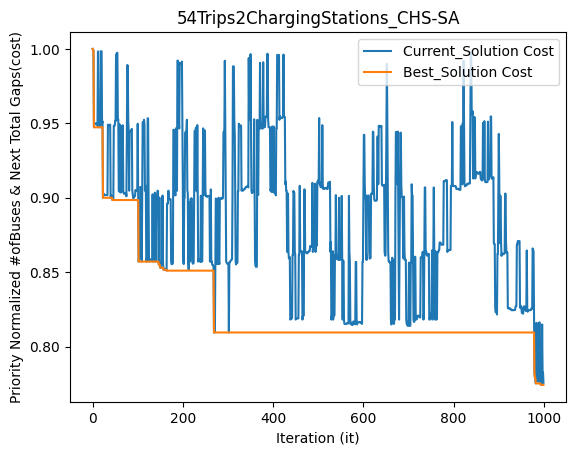

In [13]:
plt.plot(range(it_54_2), costs_54_2, label="Current_Solution Cost")
plt.plot(range(it_54_2), best_54_2, label="Best_Solution Cost")
# plt.gca().invert_xaxis()
plt.xlabel("Iteration (it)")
# plt.ylabel("[weighted_sum] #ofBuses + Total Gap Time (cost)")
plt.ylabel("Priority Normalized #ofBuses & Next Total Gaps(cost)")
plt.title("54Trips2ChargingStations_CHS-SA")
plt.legend(loc="upper right")
plt.savefig("54Trips2CSs.png")

     name   type  duration  dep_time  arr_time    dep_term    arr_term  ID
0   DEPOT  depot         0         0      1440           -           -   0
1     AB1   trip       135       560       695  Terminal A  Terminal B   1
2     AB2   trip       135       740       875  Terminal A  Terminal B   2
3     AB3   trip       135       830       965  Terminal A  Terminal B   3
4     AB4   trip       135       920      1055  Terminal A  Terminal B   4
5     AB5   trip       135       980      1115  Terminal A  Terminal B   5
6     AB6   trip       135      1040      1175  Terminal A  Terminal B   6
7     AB7   trip       135      1100      1235  Terminal A  Terminal B   7
8     AB8   trip       135      1190      1325  Terminal A  Terminal B   8
9     AC1   trip       140       555       695  Terminal A  Terminal C   9
10    AC2   trip       140       675       815  Terminal A  Terminal C  10
11    AC3   trip       140       795       935  Terminal A  Terminal C  11
12    AC4   trip       14

trips  numRecharge  numTrips  gapTime
bus_id                                                         
14      CB1,CD1,CS1,DA3,AD4,DA5            0         6    315.0
13             CD3,BA5,CS1a,AB8            0         4    270.0
8               BA1,DA2,CS1,BA7            0         4    220.0
10         CB2,AD3,DC4,CS1a,AD5            0         5    170.0
7               AD2,CD5,CS1,AB7            0         4    160.0
15              BC1,BC2,CS1,AB4            0         4    160.0
12         CA1,BA4,CS1a,AB5,BA8            0         5    145.0
4               CD2,DC3,CS1,DA4            0         4    145.0
9           DC1,DC2,CS1,BA6,AC4            0         5    110.0
11              BA2,BC3,CS1,CA5            0         4    105.0
17         AC2,CA3,CS1a,AB6,AC5            0         5    105.0
2                       AB1,AC3            0         2    100.0
3                   AC1,BA3,CA4            0         3     90.0
1                       CD4,DC5            0         2     75.0
16              AD1,DA1,CS1,BC4            0         4     60.0
6                       CB3,AB3            0         2     45.0
5                       CA2,CB4            0         2     20.0
18                          AB2            0         1      0.0

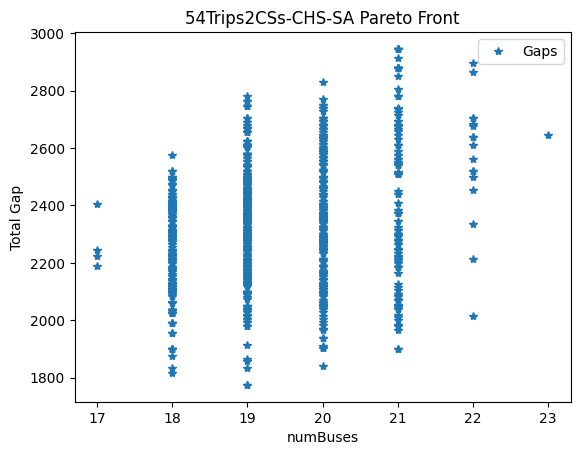

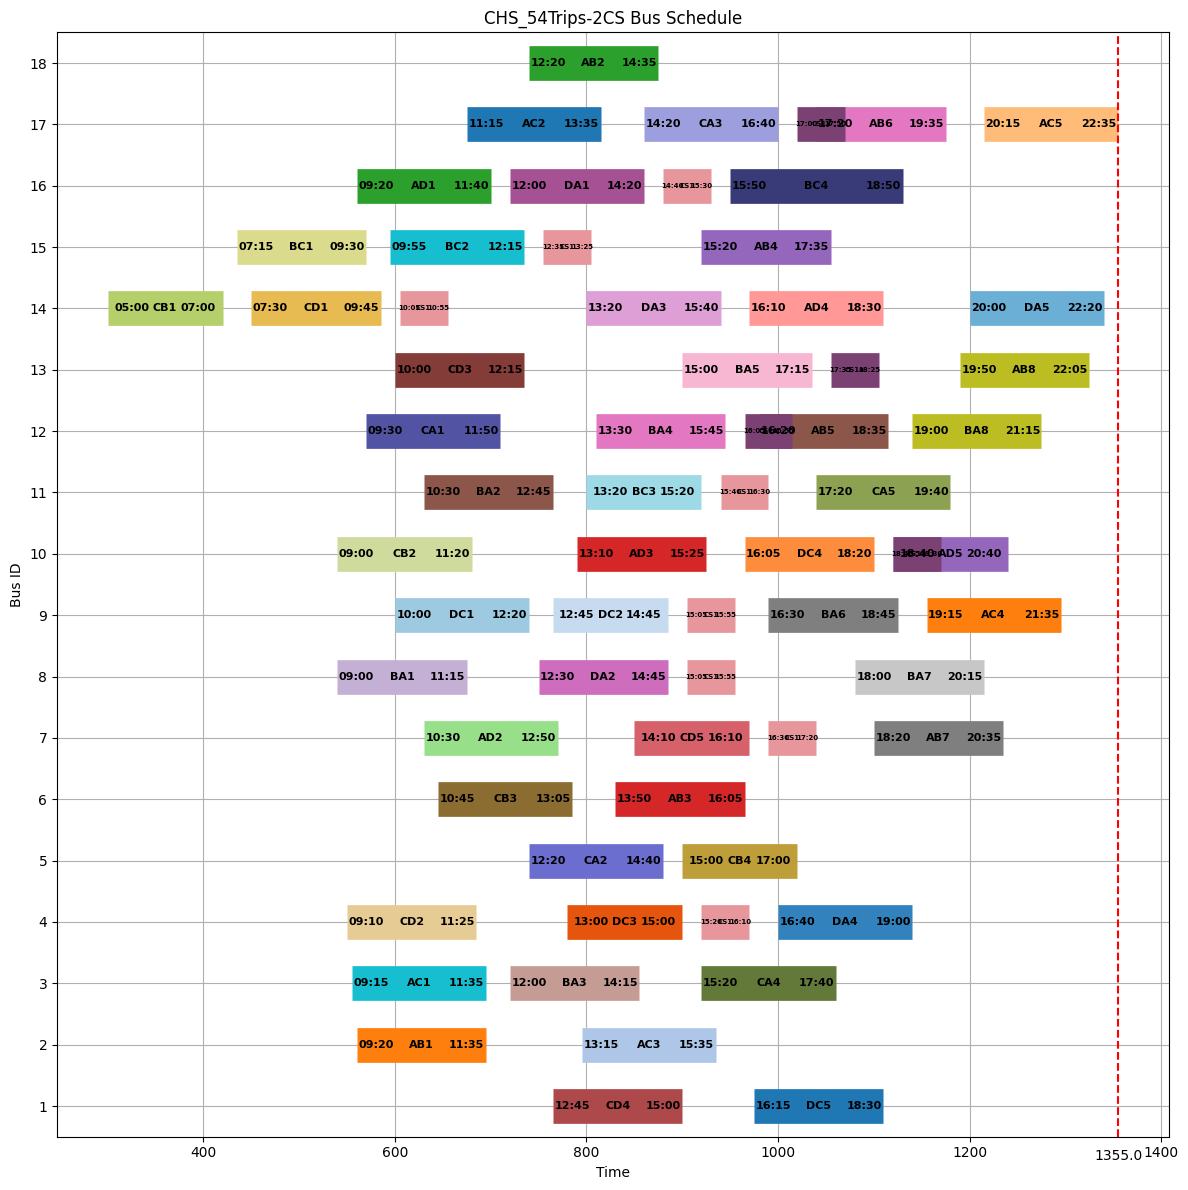

In [14]:
FiftyTrips_2cs_df = visualizeSolution(solutionspaces_54_2[1:], "54Trips2CSs-CHS-SA Pareto Front", all_schs_2cs, recharge_2cs_arcs)
newdf_54_2cs = visualizeResult(new_schedule_54_2, all_schs_2cs, "CHS_54Trips-2CS")

trips54_df_2cs = newdf_54_2cs.copy(deep=True)
trips54_df_2cs['next_dep'] = trips54_df_2cs.groupby('bus_id')['dep_time'].shift(-1).fillna(0)
trips54_df_2cs['difference'] = trips54_df_2cs['next_dep'] - trips54_df_2cs['arr_time']
trips54_df_2cs['difference'] = trips54_df_2cs['difference'].apply(lambda x: 0 if x < 0 else x)
trips54_soln_2cs = trips54_df_2cs.groupby(['bus_id'])['difference'].sum()

chs_54Trips2cs_IDLE_soln = trips54_df_2cs.groupby(['bus_id']).agg(
    trips=('trip_id', concat_str),
    numRecharge=('trip_id',countRecharge),
    numTrips=('trip_id', countTrips),
    gapTime=('difference', 'sum')
)
chs_54Trips2cs_IDLE_soln.sort_values(['gapTime'], ascending=False)


In [15]:
################################################################### 3CS #############################################################################################
## Creating Phi and Delta
recharge_3cs_arcs = feasible_recharge(trips_df, cs_deadheads, recharge=charging_stations2, terminals=terminals)
print(recharge_3cs_arcs)
cs_ids = set(list(charging_stations2.keys()))
all_schedules_3cs = {**trips, **charging_stations2}
all_schs_3cs = pd.DataFrame.from_dict(all_schedules_3cs, orient='index')
all_schs_3cs['ID'] = range(len(all_schs_3cs))
durations_3cs = {idx: {'duration': all_schs_3cs.loc[idx, 'duration']} for idx in all_schs_3cs.index if idx != 0}

###### import time
start_time = time.time()
print(f"{time.ctime()}")
test_schedules_tab, schedules_54_3 = constructiveScheduler(all_schs_3cs, arcs, recharge_3cs_arcs, set(cs_ids))
test_solution = vectorSchRepresentation(schedules_54_3)
end_time = time.time()
g_T54CS3_time = end_time - start_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {g_T54CS3_time} seconds")
print(f"number of buses = {len(schedules_54_3)}")
print(schedules_54_3)
print('-'*100)
print("starting simulated annealing....")
start_time = time.time()
new_schedule_54_3, cost_54_3, cost_diffs_54_3, temp_54_3, it_54_3, costs_54_3, solutionspaces_54_3, best_54_3 = annealing(test_solution, all_schs_3cs, arcs, recharge_3cs_arcs)
end_time = time.time()
T54CS3_time = (end_time - start_time) + g_T54CS2_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(T54CS3_time)} seconds")
print(f"prev_schedule = {test_solution} with number of buses = {len(test_solution)}... \nnext_schedule = {new_schedule_54_3} with number of buses = {len(new_schedule_54_3)}")

{(1, 3, 55): {'duration': 40}, (1, 4, 55): {'duration': 40}, (1, 5, 55): {'duration': 40}, (1, 6, 55): {'duration': 40}, (1, 7, 55): {'duration': 40}, (1, 8, 55): {'duration': 40}, (1, 11, 55): {'duration': 40}, (1, 12, 55): {'duration': 40}, (1, 13, 55): {'duration': 40}, (1, 16, 55): {'duration': 40}, (1, 17, 55): {'duration': 40}, (1, 18, 55): {'duration': 40}, (1, 22, 55): {'duration': 40}, (1, 23, 55): {'duration': 40}, (1, 24, 55): {'duration': 40}, (1, 25, 55): {'duration': 40}, (1, 26, 55): {'duration': 40}, (1, 29, 55): {'duration': 40}, (1, 30, 55): {'duration': 40}, (1, 33, 55): {'duration': 40}, (1, 34, 55): {'duration': 40}, (1, 35, 55): {'duration': 40}, (1, 39, 55): {'duration': 40}, (1, 44, 55): {'duration': 40}, (1, 47, 55): {'duration': 40}, (1, 48, 55): {'duration': 40}, (1, 49, 55): {'duration': 40}, (1, 53, 55): {'duration': 40}, (1, 54, 55): {'duration': 40}, (2, 5, 55): {'duration': 40}, (2, 6, 55): {'duration': 40}, (2, 7, 55): {'duration': 40}, (2, 8, 55): {'du

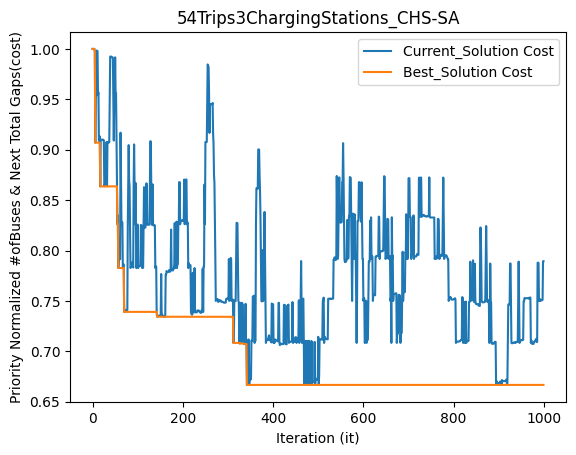

In [16]:
plt.plot(range(it_54_3), costs_54_3, label="Current_Solution Cost")
plt.plot(range(it_54_3), best_54_3, label="Best_Solution Cost")
plt.xlabel("Iteration (it)")
plt.ylabel("Priority Normalized #ofBuses & Next Total Gaps(cost)")
plt.title("54Trips3ChargingStations_CHS-SA")
plt.legend(loc="upper right")
plt.savefig("54Trips3CSs.png")

     name   type  duration  dep_time  arr_time    dep_term    arr_term  ID
0   DEPOT  depot         0         0      1440           -           -   0
1     AB1   trip       135       560       695  Terminal A  Terminal B   1
2     AB2   trip       135       740       875  Terminal A  Terminal B   2
3     AB3   trip       135       830       965  Terminal A  Terminal B   3
4     AB4   trip       135       920      1055  Terminal A  Terminal B   4
5     AB5   trip       135       980      1115  Terminal A  Terminal B   5
6     AB6   trip       135      1040      1175  Terminal A  Terminal B   6
7     AB7   trip       135      1100      1235  Terminal A  Terminal B   7
8     AB8   trip       135      1190      1325  Terminal A  Terminal B   8
9     AC1   trip       140       555       695  Terminal A  Terminal C   9
10    AC2   trip       140       675       815  Terminal A  Terminal C  10
11    AC3   trip       140       795       935  Terminal A  Terminal C  11
12    AC4   trip       14

trips  numRecharge  numTrips  gapTime
bus_id                                                          
12      CB1,CB2,CS2b,BA4,AB5,BA8            0         6    260.0
6                CD1,DC3,CS1,DA4            0         4    245.0
15      BC1,DC1,DC2,CS1a,AB4,AC5            0         6    235.0
16           AD1,BC3,DC5,CS1,DA5            0         5    195.0
4                AB1,BA3,CS1,AB6            0         4    160.0
8           AC1,DA1,CS2b,BA5,AD5            0         5    130.0
3           BA1,CA2,CA4,CS2b,BA7            0         5    125.0
9           AD2,AD3,CS1a,AD4,AB8            0         5    120.0
7           CD2,AB2,CB4,CS1a,AB7            0         5    110.0
5           CD3,DA3,DC4,CS1a,AC4            0         5    110.0
10              BC2,CD4,CS2b,BA6            0         4     70.0
11              CA1,DA2,CS2b,BC4            0         4     60.0
2                        CB3,AB3            0         2     45.0
14                       CA3,CA5            0         2     40.0
1                        AC2,CD5            0         2     35.0
13                       BA2,AC3            0         2     30.0

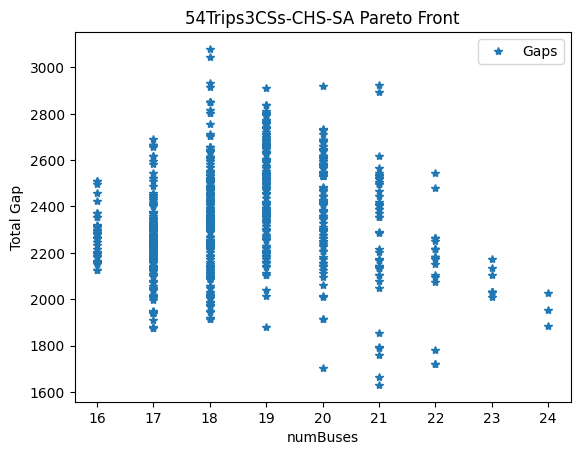

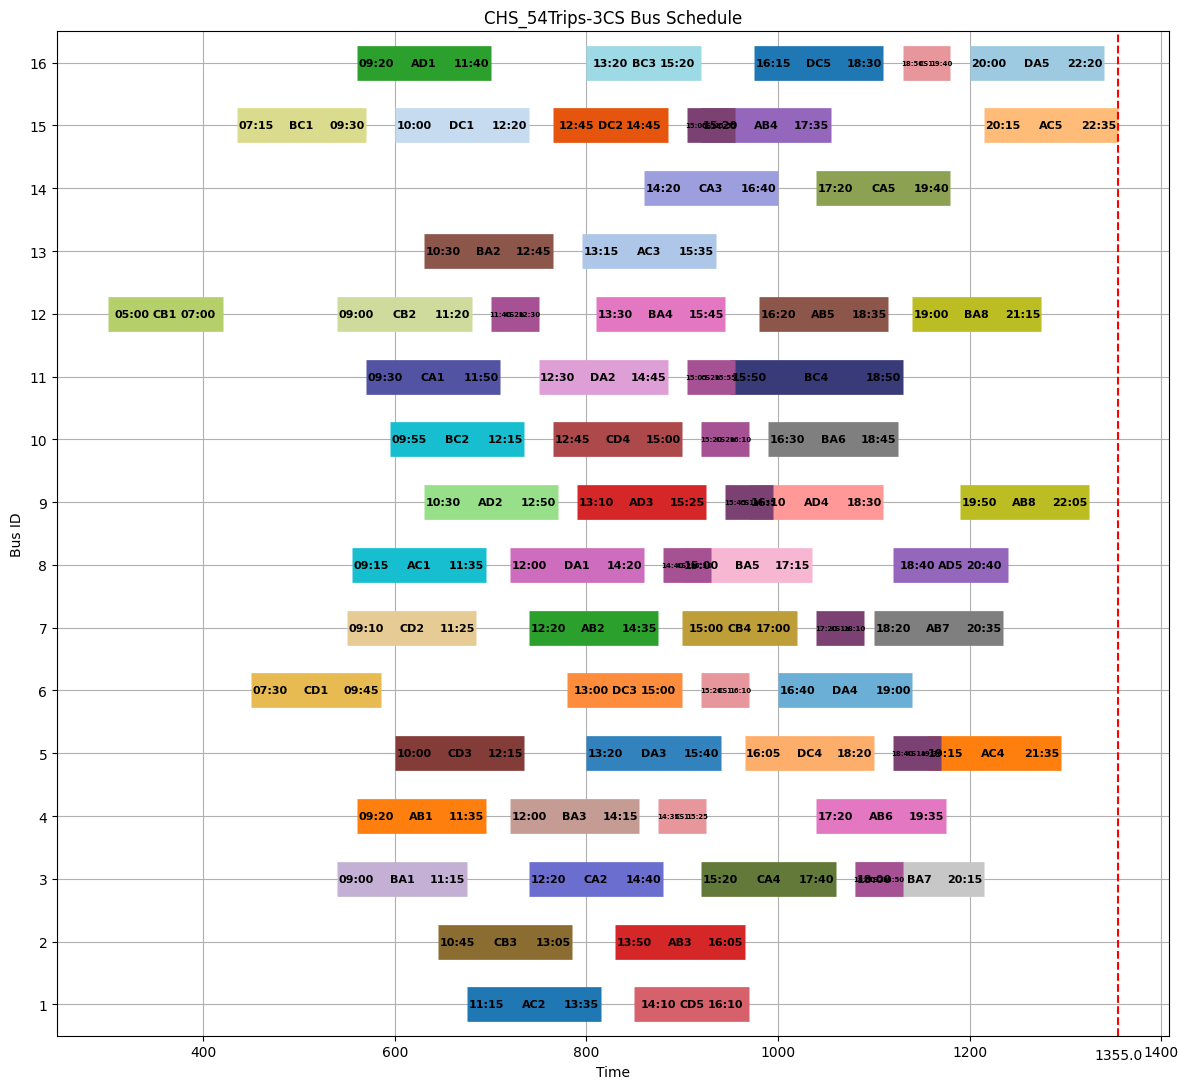

In [17]:
FiftyTrips_3cs_df = visualizeSolution(solutionspaces_54_3[1:], "54Trips3CSs-CHS-SA Pareto Front", all_schs_3cs, recharge_3cs_arcs)
newdf_54_3cs = visualizeResult(new_schedule_54_3, all_schs_3cs, "CHS_54Trips-3CS")

trips54_df_3cs = newdf_54_3cs.copy(deep=True)
trips54_df_3cs['next_dep'] = trips54_df_3cs.groupby('bus_id')['dep_time'].shift(-1).fillna(0)
trips54_df_3cs['difference'] = trips54_df_3cs['next_dep'] - trips54_df_3cs['arr_time']
trips54_df_3cs['difference'] = trips54_df_3cs['difference'].apply(lambda x: 0 if x < 0 else x)
trips54_soln_3cs = trips54_df_3cs.groupby(['bus_id'])['difference'].sum()

chs_54Trips3cs_IDLE_soln = trips54_df_3cs.groupby(['bus_id']).agg(
    trips=('trip_id', concat_str),
    numRecharge=('trip_id',countRecharge),
    numTrips=('trip_id', countTrips),
    gapTime=('difference', 'sum')
)
chs_54Trips3cs_IDLE_soln.sort_values(['gapTime'], ascending=False)

In [38]:
test = chs_10Trips1cs_IDLE_soln.describe().loc['mean']
test['numBuses'] = chs_10Trips1cs_IDLE_soln.describe().loc['count','gapTime']
test['time_to_best_soln'] = T10CS1_time
test = test.to_frame().rename(columns={"mean":"CHS_10Trips1CS"})

test2 = chs_10Trips3cs_IDLE_soln.describe().loc['mean']
test2['numBuses'] = chs_10Trips3cs_IDLE_soln.describe().loc['count','gapTime']
test2['time_to_best_soln'] = T10CS3_time
test2 = test2.to_frame().rename(columns={"mean":"CHS_10Trips3CS"})

result_10Trips = pd.concat([test, test2], axis=1)
print(result_10Trips)

test = chs_30Trips1cs_IDLE_soln.describe().loc['mean']
test['numBuses'] = chs_30Trips1cs_IDLE_soln.describe().loc['count','gapTime']
test['time_to_best_soln'] = T30CS1_time
test = test.to_frame().rename(columns={"mean":"CHS_30Trips1CS"})

test2 = chs_30Trips2cs_IDLE_soln.describe().loc['mean']
test2['numBuses'] = chs_30Trips2cs_IDLE_soln.describe().loc['count','gapTime']
test2['time_to_best_soln'] = T30CS2_time
test2 = test2.to_frame().rename(columns={"mean":"CHS_30Trips2CS"})

result_30Trips = pd.concat([test, test2], axis=1)
print(result_30Trips)
test = chs_54Trips1cs_IDLE_soln.describe().loc['mean']
test['numBuses'] = chs_54Trips1cs_IDLE_soln.describe().loc['count','gapTime']
test['time_to_best_soln'] = T54CS1_time
test = test.to_frame().rename(columns={"mean":"CHS_54Trips1CS"})

test2 = chs_54Trips3cs_IDLE_soln.describe().loc['mean']
test2['numBuses'] = chs_54Trips3cs_IDLE_soln.describe().loc['count','gapTime']
test2['time_to_best_soln'] = T54CS3_time
test2 = test2.to_frame().rename(columns={"mean":"CHS_54Trips3CS"})

result_54Trips = pd.concat([test, test2], axis=1)
print(result_54Trips)

                   CHS_10Trips1CS  CHS_10Trips3CS
numRecharge              0.000000        0.000000
numTrips                 4.333333        4.333333
gapTime                160.000000      130.000000
numBuses                 3.000000        3.000000
time_to_best_soln      219.471803      220.626537
                   CHS_30Trips1CS  CHS_30Trips2CS
numRecharge              0.000000        0.000000
numTrips                 1.000000        3.600000
gapTime                110.454545       96.500000
numBuses                11.000000       10.000000
time_to_best_soln      653.530799      636.496246
                   CHS_54Trips1CS  CHS_54Trips3CS
numRecharge              0.000000        0.000000
numTrips                 3.611111        4.125000
gapTime                151.666667      123.125000
numBuses                18.000000       16.000000
time_to_best_soln     1420.639522     1342.625374


In [6]:
############ Big DATA ###############################
################################################################################### 54 TRIPS ###############################################################################################
trips = {
    0: {'name': 'DEPOT', 'type': 'depot', 'duration': 0, 'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    1: {'name': 'AB1', 'type': 'trip', 'duration': 135, 'dep_time': 430, 'arr_time': 565, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    2: {'name': 'AB2', 'type': 'trip', 'duration': 135, 'dep_time': 560, 'arr_time': 695, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    3: {'name': 'AB3', 'type': 'trip', 'duration': 135, 'dep_time': 720, 'arr_time': 855, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    4: {'name': 'AB4', 'type': 'trip', 'duration': 135, 'dep_time': 740, 'arr_time': 875, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    5: {'name': 'AB5', 'type': 'trip', 'duration': 135, 'dep_time': 830, 'arr_time': 965, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    6: {'name': 'AB6', 'type': 'trip', 'duration': 135, 'dep_time': 920, 'arr_time': 1055, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    7: {'name': 'AB7', 'type': 'trip', 'duration': 135, 'dep_time': 980, 'arr_time': 1115, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    8: {'name': 'AB8', 'type': 'trip', 'duration': 135, 'dep_time': 1040, 'arr_time': 1175, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    9: {'name': 'AB9', 'type': 'trip', 'duration': 135, 'dep_time': 1100, 'arr_time': 1235, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    10: {'name': 'AB10', 'type': 'trip', 'duration': 135, 'dep_time': 1190, 'arr_time': 1325, 'dep_term': 'Terminal A', 'arr_term': 'Terminal B'},
    11: {'name': 'AC1', 'type': 'trip', 'duration': 140, 'dep_time': 555, 'arr_time': 695, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    12: {'name': 'AC2', 'type': 'trip', 'duration': 140, 'dep_time': 568, 'arr_time': 708, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    13: {'name': 'AC3', 'type': 'trip', 'duration': 140, 'dep_time': 600, 'arr_time': 740, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    14: {'name': 'AC4', 'type': 'trip', 'duration': 140, 'dep_time': 675, 'arr_time': 815, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    15: {'name': 'AC5', 'type': 'trip', 'duration': 140, 'dep_time': 755, 'arr_time': 895, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    16: {'name': 'AC6', 'type': 'trip', 'duration': 140, 'dep_time': 795, 'arr_time': 935, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    17: {'name': 'AC7', 'type': 'trip', 'duration': 140, 'dep_time': 920, 'arr_time': 1060, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    18: {'name': 'AC8', 'type': 'trip', 'duration': 140, 'dep_time': 1000, 'arr_time': 1140, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    19: {'name': 'AC9', 'type': 'trip', 'duration': 140, 'dep_time': 1155, 'arr_time': 1295, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    20: {'name': 'AC10', 'type': 'trip', 'duration': 140, 'dep_time': 1215, 'arr_time': 1355, 'dep_term': 'Terminal A', 'arr_term': 'Terminal C'},
    21: {'name': 'AD1', 'type': 'trip', 'duration': 140, 'dep_time': 560, 'arr_time': 700, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    22: {'name': 'AD2', 'type': 'trip', 'duration': 140, 'dep_time': 630, 'arr_time': 770, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    23: {'name': 'AD3', 'type': 'trip', 'duration': 135, 'dep_time': 790, 'arr_time': 925, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    24: {'name': 'AD4', 'type': 'trip', 'duration': 140, 'dep_time': 970, 'arr_time': 1110, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    25: {'name': 'AD5', 'type': 'trip', 'duration': 140, 'dep_time': 1120, 'arr_time': 1240, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    26: {'name': 'AD6', 'type': 'trip', 'duration': 140, 'dep_time': 480, 'arr_time': 620, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    27: {'name': 'AD7', 'type': 'trip', 'duration': 140, 'dep_time': 500, 'arr_time': 640, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    28: {'name': 'AD8', 'type': 'trip', 'duration': 135, 'dep_time': 750, 'arr_time': 885, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    29: {'name': 'AD9', 'type': 'trip', 'duration': 140, 'dep_time': 930, 'arr_time': 1070, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    30: {'name': 'AD10', 'type': 'trip', 'duration': 100, 'dep_time': 1100, 'arr_time': 1200, 'dep_term': 'Terminal A', 'arr_term': 'Terminal D'},
    31: {'name': 'BA1', 'type': 'trip', 'duration': 135, 'dep_time': 540, 'arr_time': 675, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    32: {'name': 'BA2', 'type': 'trip', 'duration': 135, 'dep_time': 630, 'arr_time': 765, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    33: {'name': 'BA3', 'type': 'trip', 'duration': 135, 'dep_time': 720, 'arr_time': 855, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    34: {'name': 'BA4', 'type': 'trip', 'duration': 135, 'dep_time': 810, 'arr_time': 945, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    35: {'name': 'BA5', 'type': 'trip', 'duration': 135, 'dep_time': 900, 'arr_time': 1035, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    36: {'name': 'BA6', 'type': 'trip', 'duration': 135, 'dep_time': 990, 'arr_time': 1125, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    37: {'name': 'BA7', 'type': 'trip', 'duration': 135, 'dep_time': 1080, 'arr_time': 1215, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    38: {'name': 'BA8', 'type': 'trip', 'duration': 135, 'dep_time': 1140, 'arr_time': 1275, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    39: {'name': 'BA9', 'type': 'trip', 'duration': 135, 'dep_time': 440, 'arr_time': 575, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    40: {'name': 'BA10', 'type': 'trip', 'duration': 75, 'dep_time': 1200, 'arr_time': 1275, 'dep_term': 'Terminal B', 'arr_term': 'Terminal A'},
    41: {'name': 'BC1', 'type': 'trip', 'duration': 140, 'dep_time': 435, 'arr_time': 570, 'dep_term': 'Terminal B', 'arr_term': 'Terminal C'},
    42: {'name': 'BC2', 'type': 'trip', 'duration': 140, 'dep_time': 595, 'arr_time': 735, 'dep_term': 'Terminal B', 'arr_term': 'Terminal C'},
    43: {'name': 'BC3', 'type': 'trip', 'duration': 120, 'dep_time': 800, 'arr_time': 920, 'dep_term': 'Terminal B', 'arr_term': 'Terminal C'},
    44: {'name': 'BC4', 'type': 'trip', 'duration': 130, 'dep_time': 950, 'arr_time': 1130, 'dep_term': 'Terminal B', 'arr_term': 'Terminal C'},
    45: {'name': 'BC5', 'type': 'trip', 'duration': 70, 'dep_time': 450, 'arr_time': 520, 'dep_term': 'Terminal B', 'arr_term': 'Terminal C'},
    46: {'name': 'BC6', 'type': 'trip', 'duration': 60, 'dep_time': 505, 'arr_time': 565, 'dep_term': 'Terminal B', 'arr_term': 'Terminal C'},
    47: {'name': 'BC7', 'type': 'trip', 'duration': 120, 'dep_time': 900, 'arr_time': 1020, 'dep_term': 'Terminal B', 'arr_term': 'Terminal C'},
    48: {'name': 'BC8', 'type': 'trip', 'duration': 105, 'dep_time': 740, 'arr_time': 845, 'dep_term': 'Terminal B', 'arr_term': 'Terminal C'},
    49: {'name': 'BC9', 'type': 'trip', 'duration': 90, 'dep_time': 600, 'arr_time': 690, 'dep_term': 'Terminal B', 'arr_term': 'Terminal C'},
    50: {'name': 'BC10', 'type': 'trip', 'duration': 135, 'dep_time': 730, 'arr_time': 865, 'dep_term': 'Terminal B', 'arr_term': 'Terminal C'},
    51: {'name': 'CA1', 'type': 'trip', 'duration': 140, 'dep_time': 570, 'arr_time': 710, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    52: {'name': 'CA2', 'type': 'trip', 'duration': 140, 'dep_time': 740, 'arr_time': 880, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    53: {'name': 'CA3', 'type': 'trip', 'duration': 140, 'dep_time': 860, 'arr_time': 1000, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    54: {'name': 'CA4', 'type': 'trip', 'duration': 140, 'dep_time': 920, 'arr_time': 1060, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    55: {'name': 'CA5', 'type': 'trip', 'duration': 140, 'dep_time': 1040, 'arr_time': 1180, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    56: {'name': 'CA6', 'type': 'trip', 'duration': 120, 'dep_time': 580, 'arr_time': 700, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    57: {'name': 'CA7', 'type': 'trip', 'duration': 115, 'dep_time': 630, 'arr_time': 745, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    58: {'name': 'CA8', 'type': 'trip', 'duration': 125, 'dep_time': 825, 'arr_time': 950, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    59: {'name': 'CA9', 'type': 'trip', 'duration': 60, 'dep_time': 1210, 'arr_time': 1270, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    60: {'name': 'CA10', 'type': 'trip', 'duration': 90, 'dep_time': 1000, 'arr_time': 1090, 'dep_term': 'Terminal C', 'arr_term': 'Terminal A'},
    61: {'name': 'CB1', 'type': 'trip', 'duration': 120, 'dep_time': 300, 'arr_time': 420, 'dep_term': 'Terminal C', 'arr_term': 'Terminal B'},
    62: {'name': 'CB2', 'type': 'trip', 'duration': 140, 'dep_time': 540, 'arr_time': 680, 'dep_term': 'Terminal C', 'arr_term': 'Terminal B'},
    63: {'name': 'CB3', 'type': 'trip', 'duration': 140, 'dep_time': 645, 'arr_time': 785, 'dep_term': 'Terminal C', 'arr_term': 'Terminal B'},
    64: {'name': 'CB4', 'type': 'trip', 'duration': 120, 'dep_time': 900, 'arr_time': 1020, 'dep_term': 'Terminal C', 'arr_term': 'Terminal B'},
    65: {'name': 'CB5', 'type': 'trip', 'duration': 120, 'dep_time': 400, 'arr_time': 520, 'dep_term': 'Terminal C', 'arr_term': 'Terminal B'},
    66: {'name': 'CB6', 'type': 'trip', 'duration': 140, 'dep_time': 530, 'arr_time': 670, 'dep_term': 'Terminal C', 'arr_term': 'Terminal B'},
    67: {'name': 'CB7', 'type': 'trip', 'duration': 140, 'dep_time': 755, 'arr_time': 895, 'dep_term': 'Terminal C', 'arr_term': 'Terminal B'},
    68: {'name': 'CB8', 'type': 'trip', 'duration': 100, 'dep_time': 790, 'arr_time': 890, 'dep_term': 'Terminal C', 'arr_term': 'Terminal B'},
    69: {'name': 'CB9', 'type': 'trip', 'duration': 101, 'dep_time': 800, 'arr_time': 901, 'dep_term': 'Terminal C', 'arr_term': 'Terminal B'},
    70: {'name': 'CB10', 'type': 'trip', 'duration': 120, 'dep_time': 750, 'arr_time': 1020, 'dep_term': 'Terminal C', 'arr_term': 'Terminal B'},
    71: {'name': 'CD1', 'type': 'trip', 'duration': 140, 'dep_time': 450, 'arr_time': 585, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    72: {'name': 'CD2', 'type': 'trip', 'duration': 135, 'dep_time': 550, 'arr_time': 685, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    73: {'name': 'CD3', 'type': 'trip', 'duration': 135, 'dep_time': 600, 'arr_time': 735, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    74: {'name': 'CD4', 'type': 'trip', 'duration': 135, 'dep_time': 765, 'arr_time': 900, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    75: {'name': 'CD5', 'type': 'trip', 'duration': 120, 'dep_time': 850, 'arr_time': 970, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    76: {'name': 'CD6', 'type': 'trip', 'duration': 140, 'dep_time': 480, 'arr_time': 620, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    77: {'name': 'CD7', 'type': 'trip', 'duration': 75, 'dep_time': 585, 'arr_time': 660, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    78: {'name': 'CD8', 'type': 'trip', 'duration': 65, 'dep_time': 905, 'arr_time': 970, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    79: {'name': 'CD9', 'type': 'trip', 'duration': 55, 'dep_time': 1115, 'arr_time': 1170, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    80: {'name': 'CD10', 'type': 'trip', 'duration': 114, 'dep_time': 850, 'arr_time': 964, 'dep_term': 'Terminal C', 'arr_term': 'Terminal D'},
    81: {'name': 'DA1', 'type': 'trip', 'duration': 140, 'dep_time': 720, 'arr_time': 860, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    82: {'name': 'DA2', 'type': 'trip', 'duration': 135, 'dep_time': 750, 'arr_time': 885, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    83: {'name': 'DA3', 'type': 'trip', 'duration': 140, 'dep_time': 800, 'arr_time': 940, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    84: {'name': 'DA4', 'type': 'trip', 'duration': 140, 'dep_time': 1000, 'arr_time': 1140, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    85: {'name': 'DA5', 'type': 'trip', 'duration': 140, 'dep_time': 1200, 'arr_time': 1340, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    86: {'name': 'DA6', 'type': 'trip', 'duration': 68, 'dep_time': 790, 'arr_time': 858, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    87: {'name': 'DA7', 'type': 'trip', 'duration': 75, 'dep_time': 684, 'arr_time': 759, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    88: {'name': 'DA8', 'type': 'trip', 'duration': 80, 'dep_time': 800, 'arr_time': 880, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    89: {'name': 'DA9', 'type': 'trip', 'duration': 100, 'dep_time': 976, 'arr_time': 1076, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    90: {'name': 'DA10', 'type': 'trip', 'duration': 96, 'dep_time': 1200, 'arr_time': 1296, 'dep_term': 'Terminal D', 'arr_term': 'Terminal A'},
    91: {'name': 'DC1', 'type': 'trip', 'duration': 140, 'dep_time': 600, 'arr_time': 740, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'},
    92: {'name': 'DC2', 'type': 'trip', 'duration': 120, 'dep_time': 765, 'arr_time': 885, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'},
    93: {'name': 'DC3', 'type': 'trip', 'duration': 120, 'dep_time': 780, 'arr_time': 900, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'},
    94: {'name': 'DC4', 'type': 'trip', 'duration': 135, 'dep_time': 965, 'arr_time': 1100, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'},
    95: {'name': 'DC5', 'type': 'trip', 'duration': 135, 'dep_time': 975, 'arr_time': 1110, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'},
    96: {'name': 'DC6', 'type': 'trip', 'duration': 120, 'dep_time': 533, 'arr_time': 653, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'},
    97: {'name': 'DC7', 'type': 'trip', 'duration': 70, 'dep_time': 590, 'arr_time': 660, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'},
    98: {'name': 'DC8', 'type': 'trip', 'duration': 80, 'dep_time': 780, 'arr_time': 860, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'},
    99: {'name': 'DC9', 'type': 'trip', 'duration': 95, 'dep_time': 965, 'arr_time': 1060, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'},
    100: {'name': 'DC10', 'type': 'trip', 'duration': 85, 'dep_time': 1005, 'arr_time': 1090, 'dep_term': 'Terminal D', 'arr_term': 'Terminal C'}
}

charging_station = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
}

charging_stations1 = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    len(trips)+1: {'name': 'CS1a', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal A', 'arr_term': 'Terminal A'},
}

charging_stations2 = {
    len(trips): {'name': 'CS1', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': '-', 'arr_term': '-'},
    len(trips)+1: {'name': 'CS1a', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal A', 'arr_term': 'Terminal A'},
    len(trips)+2: {'name': 'CS2b', 'type': 'cs', 'duration': 50,  'dep_time': 0, 'arr_time': 1440, 'dep_term': 'Terminal B', 'arr_term': 'Terminal B'},
}

# TERMINALS AND MINIMUM INTERVALS BETWEEN TRIPS
terminals = {
    'Terminal A': {'max_interval': 15},
    'Terminal B': {'max_interval': 15},
    'Terminal C': {'max_interval': 15},
    'Terminal D': {'max_interval': 15}
}
### Add extra parameter that allows e-Bus to complete schedule that is not continuous (aka the start node does not have to be the end node of the previous)
## Defining the deadhead parameter from Terminals
cs_deadheads = {
    'Terminal A': {'CS1': 40, 'CS1a': 10, 'CS2b': 75, 'CS3c': 75, 'CS4d': 75},
    'Terminal B': {'CS1': 40, 'CS1a': 75, 'CS2b': 10, 'CS3c': 75, 'CS4d': 75},
    'Terminal C': {'CS1': 40, 'CS1a': 75, 'CS2b': 75, 'CS3c': 10, 'CS4d': 75},
    'Terminal D': {'CS1': 40, 'CS1a': 75, 'CS2b': 75, 'CS3c': 75, 'CS4d': 10},
}

D_MAX = 350
CHARGING_TIME = 100
trips_df = pd.DataFrame.from_dict(trips, orient='index')
print(trips_df)
## Creating Gamma and Delta
arcs = feasible_pairs(trips_df, terminals)
print(charging_station)


      name   type  duration  dep_time  arr_time    dep_term    arr_term
0    DEPOT  depot         0         0      1440           -           -
1      AB1   trip       135       430       565  Terminal A  Terminal B
2      AB2   trip       135       560       695  Terminal A  Terminal B
3      AB3   trip       135       720       855  Terminal A  Terminal B
4      AB4   trip       135       740       875  Terminal A  Terminal B
..     ...    ...       ...       ...       ...         ...         ...
96     DC6   trip       120       533       653  Terminal D  Terminal C
97     DC7   trip        70       590       660  Terminal D  Terminal C
98     DC8   trip        80       780       860  Terminal D  Terminal C
99     DC9   trip        95       965      1060  Terminal D  Terminal C
100   DC10   trip        85      1005      1090  Terminal D  Terminal C

[101 rows x 7 columns]
     trip_id   name   type  duration  dep_time  arr_time    dep_term  \
0          0  DEPOT  depot         0    

In [7]:
######################################################## 1CS #####################################################################
recharge_1cs_arcs = feasible_recharge(trips_df, cs_deadheads, recharge=charging_station, terminals=terminals)
cs_ids = set(list(charging_station.keys()))
all_schedules_1cs = {**trips, **charging_station}
all_schs_1cs = pd.DataFrame.from_dict(all_schedules_1cs, orient='index')
all_schs_1cs['ID'] = range(len(all_schs_1cs))
durations_1cs = {idx: {'duration': all_schs_1cs.loc[idx, 'duration']} for idx in all_schs_1cs.index if idx != 0}
###################################################### CHS-SA ####################################################################

start_time = time.time()
print(f"{time.ctime()}")
schedules_tab, schedules_100_1 = constructiveScheduler(all_schs_1cs, arcs, recharge_1cs_arcs, cs_ids)
solution = vectorSchRepresentation(schedules_100_1)
end_time = time.time()
g_T100CS1_time = end_time - start_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(g_T100CS1_time)} seconds")
print(f"number of buses = {len(schedules_100_1)}")
print(schedules_100_1)
print('-'*100)
start_time = time.time()
print("starting simulated annealing....")
new_schedule_100_1, cost_100_1, cost_diffs_100_1, temp_100_1, it_100_1, costs_100_1, solution_spaces_100_1, best_costs_100_1 = annealing(solution, all_schs_1cs, arcs, recharge_1cs_arcs)
end_time = time.time()
T100CS1_time = (end_time-start_time)+g_T100CS1_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(T100CS1_time)} seconds")
print(f"prev_schedule = {solution} with number of buses = {len(solution)}... \nnext_schedule = {new_schedule_100_1} with number of buses = {len(new_schedule_100_1)}")


Fri Feb 28 13:42:05 2025
Fri Feb 28 13:50:03 2025
Time elapse to compute the solution = 478.0265929698944 seconds
number of buses = 33
[[(0, 61), (61, 39), (39, 87, 101), (87, 86), (86, 78), (78, 60), (60, 79), (79, 10), (10, 0)], [(0, 65), (65, 2), (2, 88, 101), (88, 47), (47, 55), (55, 20), (20, 0)], [(0, 1), (1, 13), (13, 80, 101), (80, 7), (7, 19), (19, 0)], [(0, 41), (41, 22), (22, 23), (23, 8, 101), (8, 40), (40, 0)], [(0, 45), (45, 11), (11, 3), (3, 94, 101), (94, 25), (25, 0)], [(0, 71), (71, 32), (32, 68), (68, 100, 101), (100, 38), (38, 0)], [(0, 76), (76, 4), (4, 89, 101), (89, 9), (9, 0)], [(0, 26), (26, 14), (14, 6, 101), (6, 30), (30, 0)], [(0, 27), (27, 15), (15, 18, 101), (18, 59), (59, 0)], [(0, 46), (46, 42), (42, 67), (67, 36, 101), (36, 85), (85, 0)], [(0, 66), (66, 16), (16, 24), (24, 90, 101), (90, 0)], [(0, 96), (96, 33), (33, 99, 101), (99, 37), (37, 0)], [(0, 31), (31, 28), (28, 84, 101), (84, 0)], [(0, 62), (62, 48), (48, 44, 101), (44, 0)], [(0, 72), (72, 50)

proposed solution = [[61, 39, 101, 87, 86, 78, 60, 79, 10, 0], [65, 2, 101, 88, 47, 55, 20, 0], [1, 13, 0], [41, 22, 23, 101, 8, 40, 0], [45, 11, 3, 101, 94, 25, 0], [71, 32, 68, 101, 100, 38, 0], [76, 4, 101, 89, 9, 0], [26, 14, 0], [27, 15, 101, 18, 59, 0], [46, 42, 67, 101, 36, 85, 0], [66, 16, 24, 101, 90, 0], [96, 33, 101, 99, 37, 0], [31, 28, 0], [62, 48, 101, 44, 0], [72, 50, 101, 95, 0], [21, 98, 64, 0], [12, 5, 0], [51, 17, 0], [56, 29, 0], [97, 52, 35, 0], [73, 34, 0], [49, 43, 0], [91, 53, 0], [57, 58, 30, 0], [63, 75, 101, 19, 0], [92, 0], [83, 0], [80, 0], [81, 84, 0], [93, 7, 0], [82, 6, 0], [70, 0], [77, 74, 0], [69, 54, 0]]
----------------------------------------------------------------------------------------------------
Iteration 11...
insertion...
proposed solution = [[61, 39, 101, 87, 86, 78, 60, 79, 10, 0], [65, 2, 101, 88, 47, 55, 20, 0], [1, 13, 0], [41, 22, 23, 101, 8, 40, 0], [45, 11, 3, 101, 94, 25, 0], [71, 32, 68, 101, 100, 38, 0], [76, 4, 101, 89, 9, 0], [

proposed solution = [[26, 14, 0], [31, 28, 0], [21, 98, 64, 0], [12, 5, 0], [56, 29, 0], [97, 52, 35, 0], [73, 34, 0], [49, 43, 0], [91, 53, 0], [57, 58, 30, 0], [81, 84, 0], [93, 7, 0], [70, 0], [69, 54, 0], [92, 17, 0], [82, 6, 0], [51, 83, 0], [1, 13, 101, 80, 0], [61, 39, 101, 87, 86, 78, 60, 79, 10, 0], [65, 2, 101, 88, 47, 55, 20, 0], [41, 22, 23, 101, 8, 40, 0], [45, 11, 3, 101, 94, 25, 0], [71, 32, 68, 101, 100, 38, 0], [76, 4, 101, 89, 9, 0], [27, 15, 101, 18, 59, 0], [46, 42, 67, 101, 36, 85, 0], [66, 16, 24, 101, 90, 0], [96, 33, 101, 99, 37, 0], [62, 48, 101, 44, 0], [72, 50, 101, 95, 0], [63, 75, 101, 19, 0], [77, 74, 0]]
----------------------------------------------------------------------------------------------------
Iteration 22...
swapping recharging task...
proposed solution = [[26, 14, 0], [31, 28, 0], [21, 98, 64, 0], [12, 5, 0], [56, 29, 0], [97, 52, 35, 0], [73, 34, 0], [49, 43, 0], [91, 53, 0], [57, 58, 30, 0], [81, 84, 0], [93, 7, 0], [70, 0], [69, 54, 0], [92

----------------------------------------------------------------------------------------------------
Iteration 32...
insertion...
proposed solution = [[21, 98, 64, 0], [12, 5, 0], [56, 29, 0], [97, 52, 35, 0], [73, 34, 0], [49, 43, 0], [91, 53, 0], [57, 58, 101, 37, 0], [81, 84, 0], [93, 7, 0], [69, 54, 0], [92, 17, 0], [82, 6, 0], [1, 13, 101, 80, 55, 20, 0], [61, 39, 101, 87, 86, 78, 60, 79, 10, 0], [65, 2, 101, 88, 47, 0], [41, 22, 23, 101, 8, 40, 0], [71, 32, 68, 101, 100, 38, 0], [76, 4, 101, 89, 9, 0], [27, 15, 101, 18, 59, 0], [46, 42, 67, 101, 36, 85, 0], [66, 16, 24, 101, 90, 0], [96, 33, 0], [62, 48, 101, 44, 0], [63, 75, 101, 19, 0], [77, 74, 0], [51, 50, 101, 99, 0], [72, 70, 0], [31, 28, 101, 95, 0], [26, 83, 101, 30, 0], [14, 0], [45, 11, 3, 101, 94, 25, 0]]
----------------------------------------------------------------------------------------------------
Iteration 33...
insertion...
proposed solution = [[21, 98, 64, 0], [12, 5, 0], [56, 29, 0], [97, 52, 35, 0], [73, 34

----------------------------------------------------------------------------------------------------
Iteration 43...
insertion...
proposed solution = [[21, 98, 30, 0], [97, 52, 35, 0], [73, 34, 0], [49, 43, 0], [91, 53, 0], [11, 81, 101, 84, 0], [93, 7, 0], [69, 54, 0], [92, 17, 0], [82, 6, 0], [96, 33, 0], [77, 74, 94, 101, 90, 0], [72, 70, 0], [26, 83, 0], [3, 64, 0], [57, 58, 101, 37, 0], [61, 39, 101, 87, 86, 78, 60, 79, 10, 0], [65, 2, 101, 88, 47, 0], [41, 22, 23, 101, 8, 40, 0], [71, 32, 68, 101, 100, 38, 0], [76, 4, 101, 89, 9, 0], [27, 15, 101, 18, 59, 0], [46, 42, 67, 101, 36, 85, 0], [66, 16, 24, 0], [62, 48, 101, 44, 0], [63, 75, 101, 19, 0], [31, 28, 101, 95, 0], [1, 14, 101, 55, 0], [51, 50, 101, 99, 25, 0], [45, 13, 101, 80, 20, 0], [12, 5, 0], [56, 29, 0]]
----------------------------------------------------------------------------------------------------
Iteration 44...
swapping recharging task...
proposed solution = [[21, 98, 30, 0], [97, 52, 35, 0], [73, 34, 0], [49,

----------------------------------------------------------------------------------------------------
Iteration 54...
swapping other CS...
proposed solution = [[21, 98, 30, 0], [97, 52, 35, 0], [93, 7, 0], [69, 54, 0], [92, 17, 0], [82, 6, 0], [96, 33, 0], [77, 74, 94, 0], [72, 70, 0], [26, 83, 0], [65, 2, 0], [41, 22, 23, 0], [66, 16, 24, 0], [51, 50, 0], [56, 29, 0], [12, 5, 0], [73, 34, 0], [91, 53, 0], [43, 0], [88, 0], [47, 0], [99, 0], [11, 81, 101, 84, 40, 0], [49, 3, 64, 101, 25, 0], [57, 58, 101, 37, 0], [61, 39, 101, 87, 86, 78, 60, 79, 10, 0], [71, 32, 68, 101, 100, 38, 0], [76, 4, 101, 89, 9, 0], [27, 15, 101, 18, 59, 0], [46, 42, 67, 101, 36, 85, 0], [62, 48, 101, 44, 0], [63, 75, 101, 19, 0], [31, 28, 101, 95, 0], [1, 14, 101, 55, 90, 0], [45, 13, 101, 80, 8, 20, 0]]
----------------------------------------------------------------------------------------------------
Iteration 55...
swapping other CS...
proposed solution = [[21, 98, 30, 0], [97, 52, 35, 0], [93, 7, 0], [69,

proposed solution = [[21, 98, 30, 0], [97, 52, 35, 0], [93, 7, 0], [87, 69, 54, 0], [92, 17, 0], [82, 6, 0], [96, 33, 0], [77, 74, 94, 0], [72, 70, 0], [26, 83, 0], [65, 2, 101, 80, 0], [41, 22, 23, 0], [66, 16, 24, 0], [51, 50, 101, 60, 0], [56, 29, 0], [12, 5, 0], [73, 34, 0], [91, 53, 0], [88, 99, 37, 0], [13, 86, 47, 0], [49, 3, 64, 101, 25, 0], [57, 58, 101, 8, 0], [71, 32, 68, 101, 100, 38, 0], [76, 4, 101, 89, 9, 0], [27, 15, 101, 18, 59, 0], [46, 42, 67, 101, 36, 85, 0], [62, 48, 101, 44, 40, 0], [63, 75, 101, 19, 0], [45, 31, 28, 101, 95, 10, 0], [1, 14, 101, 78, 55, 90, 0], [61, 39, 101, 43, 79, 20, 0], [11, 81, 101, 84, 0]]
----------------------------------------------------------------------------------------------------
Iteration 66...
swapping recharging task...
proposed solution = [[21, 98, 30, 0], [97, 52, 35, 0], [93, 7, 0], [87, 69, 54, 0], [92, 17, 0], [82, 6, 0], [96, 33, 0], [77, 74, 94, 0], [72, 70, 0], [26, 83, 0], [65, 2, 101, 80, 0], [41, 22, 23, 0], [66, 16, 

----------------------------------------------------------------------------------------------------
Iteration 76...
insertion...
proposed solution = [[21, 98, 30, 0], [97, 52, 35, 0], [87, 69, 54, 0], [82, 6, 0], [96, 33, 0], [77, 74, 94, 0], [72, 70, 0], [26, 83, 0], [41, 22, 23, 0], [66, 16, 24, 0], [56, 29, 0], [12, 5, 0], [73, 34, 0], [91, 53, 0], [88, 99, 37, 0], [13, 86, 47, 0], [46, 42, 67, 0], [63, 75, 0], [93, 7, 0], [65, 2, 101, 80, 36, 0], [51, 50, 101, 60, 19, 0], [49, 3, 64, 101, 25, 0], [57, 58, 101, 8, 0], [71, 32, 68, 101, 100, 38, 0], [76, 4, 101, 89, 9, 0], [27, 15, 101, 18, 59, 0], [62, 48, 101, 44, 40, 0], [45, 31, 28, 101, 95, 10, 0], [1, 14, 101, 78, 55, 90, 0], [61, 39, 101, 43, 79, 20, 0], [11, 81, 101, 84, 85, 0], [92, 17, 0]]
----------------------------------------------------------------------------------------------------
Iteration 77...
insertion...
proposed solution = [[21, 98, 30, 0], [97, 52, 35, 0], [87, 69, 54, 0], [82, 6, 0], [77, 74, 94, 0], [72, 7

----------------------------------------------------------------------------------------------------
Iteration 88...
insertion...
proposed solution = [[21, 98, 30, 0], [87, 69, 54, 0], [72, 70, 0], [41, 22, 23, 0], [66, 16, 24, 0], [56, 29, 0], [12, 5, 0], [73, 34, 0], [91, 53, 0], [88, 99, 37, 0], [13, 86, 47, 0], [46, 42, 67, 0], [63, 75, 0], [93, 7, 0], [92, 17, 0], [97, 74, 89, 0], [26, 83, 0], [45, 31, 28, 101, 95, 85, 0], [65, 2, 101, 80, 36, 0], [51, 50, 101, 60, 19, 0], [49, 3, 64, 101, 25, 0], [57, 58, 101, 8, 0], [71, 32, 68, 101, 100, 38, 0], [27, 15, 101, 18, 59, 0], [62, 48, 101, 44, 40, 0], [1, 14, 101, 78, 55, 90, 0], [61, 39, 101, 43, 79, 20, 0], [11, 81, 101, 84, 0], [96, 33, 101, 9, 0], [76, 4, 101, 94, 0], [77, 52, 35, 101, 10, 0], [82, 6, 0]]
----------------------------------------------------------------------------------------------------
Iteration 89...
swapping other CS...
proposed solution = [[21, 98, 30, 0], [87, 69, 54, 0], [72, 70, 0], [41, 22, 23, 0], [66,

----------------------------------------------------------------------------------------------------
Iteration 100...
swapping recharging task...
proposed solution = [[21, 98, 30, 0], [87, 69, 54, 0], [41, 22, 23, 0], [66, 16, 24, 0], [12, 5, 0], [73, 34, 0], [88, 99, 37, 0], [13, 86, 47, 0], [46, 42, 67, 101, 85, 0], [63, 75, 0], [93, 7, 0], [92, 17, 0], [97, 74, 89, 0], [82, 6, 0], [57, 58, 0], [72, 70, 0], [56, 29, 0], [61, 39, 0], [91, 53, 0], [43, 0], [78, 79, 0], [26, 83, 101, 8, 0], [45, 31, 28, 0], [65, 2, 101, 80, 36, 0], [51, 50, 101, 60, 19, 0], [49, 3, 64, 101, 25, 0], [71, 32, 68, 101, 100, 38, 0], [27, 15, 101, 18, 59, 0], [1, 14, 101, 44, 20, 0], [11, 81, 101, 84, 0], [96, 33, 101, 9, 0], [76, 4, 101, 94, 90, 0], [77, 52, 35, 101, 10, 0], [62, 48, 101, 55, 40, 0], [95, 0]]
----------------------------------------------------------------------------------------------------
Iteration 101...
swapping recharging task...
proposed solution = [[21, 98, 30, 0], [87, 69, 54, 0], 

----------------------------------------------------------------------------------------------------
Iteration 111...
swapping recharging task...
proposed solution = [[21, 98, 30, 0], [87, 69, 54, 0], [41, 22, 23, 0], [66, 16, 24, 0], [73, 34, 0], [88, 99, 37, 0], [13, 86, 47, 0], [63, 75, 0], [93, 7, 0], [92, 17, 0], [97, 74, 89, 0], [82, 6, 0], [57, 58, 101, 85, 0], [72, 70, 0], [56, 29, 0], [61, 39, 101, 53, 0], [91, 18, 59, 0], [12, 78, 79, 0], [27, 15, 0], [77, 52, 35, 0], [43, 55, 40, 0], [46, 42, 67, 101, 84, 10, 0], [26, 83, 101, 8, 0], [65, 2, 101, 80, 36, 0], [51, 50, 101, 60, 19, 0], [49, 3, 64, 101, 25, 0], [71, 32, 68, 0], [1, 14, 101, 44, 20, 0], [11, 81, 0], [96, 33, 101, 9, 0], [76, 4, 101, 94, 90, 0], [62, 48, 0], [5, 0], [45, 31, 28, 101, 95, 38, 0], [100, 0]]
----------------------------------------------------------------------------------------------------
Iteration 112...
insertion...
proposed solution = [[21, 98, 30, 0], [87, 69, 54, 0], [41, 22, 23, 0], [66, 16,

----------------------------------------------------------------------------------------------------
Iteration 122...
insertion...
proposed solution = [[21, 98, 30, 0], [87, 69, 54, 0], [66, 16, 24, 0], [13, 86, 47, 0], [63, 75, 0], [93, 7, 0], [97, 74, 89, 0], [82, 6, 0], [56, 29, 0], [91, 18, 59, 0], [12, 88, 78, 79, 0], [27, 15, 0], [77, 52, 35, 0], [72, 43, 101, 55, 40, 0], [71, 32, 68, 0], [11, 81, 0], [62, 48, 0], [5, 100, 101, 20, 0], [92, 17, 0], [41, 57, 58, 101, 85, 0], [61, 39, 73, 101, 53, 0], [46, 42, 67, 101, 84, 10, 0], [26, 83, 101, 8, 0], [65, 2, 101, 80, 36, 0], [51, 50, 101, 60, 19, 0], [49, 3, 64, 101, 25, 0], [1, 14, 101, 95, 0], [96, 33, 101, 99, 9, 0], [76, 4, 101, 94, 90, 0], [70, 37, 0], [22, 23, 0], [28, 44, 0], [45, 31, 34, 101, 38, 0]]
----------------------------------------------------------------------------------------------------
Iteration 123...
insertion...
proposed solution = [[21, 98, 30, 0], [87, 69, 54, 0], [66, 16, 24, 0], [13, 86, 47, 0], [63, 7

----------------------------------------------------------------------------------------------------
Iteration 133...
insertion...
proposed solution = [[21, 98, 30, 0], [87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [56, 29, 0], [91, 93, 101, 18, 59, 0], [12, 88, 78, 79, 0], [27, 15, 0], [77, 52, 35, 0], [72, 43, 0], [71, 32, 68, 0], [11, 81, 0], [92, 17, 0], [51, 50, 101, 7, 0], [28, 44, 0], [16, 60, 0], [47, 55, 40, 0], [66, 70, 0], [63, 75, 0], [5, 100, 101, 20, 0], [41, 57, 58, 101, 85, 0], [61, 39, 73, 101, 53, 0], [46, 42, 67, 101, 84, 10, 0], [26, 83, 101, 8, 0], [65, 2, 101, 80, 36, 0], [49, 3, 64, 101, 25, 0], [1, 14, 101, 95, 0], [96, 33, 101, 99, 9, 0], [76, 4, 101, 94, 90, 0], [22, 23, 101, 37, 0], [45, 31, 34, 101, 38, 0], [62, 48, 101, 24, 0], [82, 6, 0]]
----------------------------------------------------------------------------------------------------
Iteration 134...
insertion...
proposed solution = [[21, 98, 30, 0], [87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 

----------------------------------------------------------------------------------------------------
Iteration 144...
insertion...
proposed solution = [[21, 98, 30, 0], [87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88, 78, 79, 0], [27, 15, 0], [77, 52, 35, 0], [72, 43, 0], [71, 32, 68, 0], [11, 81, 0], [92, 17, 0], [28, 44, 0], [16, 60, 0], [47, 55, 40, 0], [82, 6, 0], [56, 5, 100, 0], [49, 3, 64, 0], [66, 70, 101, 25, 0], [63, 75, 101, 20, 0], [91, 93, 101, 18, 59, 0], [51, 50, 101, 7, 0], [41, 57, 58, 101, 85, 0], [61, 39, 73, 101, 53, 0], [46, 42, 67, 101, 84, 10, 0], [26, 83, 101, 8, 0], [65, 2, 101, 80, 36, 0], [1, 14, 101, 95, 0], [96, 33, 101, 99, 9, 0], [76, 4, 101, 94, 90, 0], [22, 23, 101, 37, 0], [45, 31, 34, 101, 38, 0], [62, 48, 101, 24, 0], [29, 0]]
----------------------------------------------------------------------------------------------------
Iteration 145...
swapping recharging task...
proposed solution = [[21, 98, 30, 0], [87, 69, 54, 0], [13, 86, 19, 0]

proposed solution = [[21, 98, 30, 0], [87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88, 78, 79, 0], [27, 15, 0], [72, 43, 0], [11, 81, 101, 99, 0], [28, 44, 0], [16, 60, 0], [47, 55, 40, 0], [82, 6, 0], [49, 3, 64, 101, 38, 0], [66, 70, 0], [33, 100, 0], [56, 5, 101, 25, 0], [63, 75, 101, 20, 0], [91, 93, 101, 18, 59, 0], [51, 50, 101, 7, 0], [41, 57, 58, 101, 85, 0], [61, 39, 73, 101, 53, 0], [46, 42, 67, 101, 84, 10, 0], [26, 83, 101, 9, 0], [65, 2, 101, 80, 36, 0], [1, 14, 101, 95, 0], [76, 4, 101, 94, 90, 0], [71, 22, 23, 101, 37, 0], [62, 48, 101, 24, 0], [52, 35, 0], [96, 34, 101, 8, 0], [45, 31, 29, 0], [77, 92, 17, 0], [32, 68, 0]]
----------------------------------------------------------------------------------------------------
Iteration 156...
swapping other CS...
proposed solution = [[21, 98, 30, 0], [87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88, 78, 79, 0], [27, 15, 0], [72, 43, 0], [28, 44, 0], [16, 60, 0], [47, 55, 40, 0], [82, 6, 0], [66, 70, 0],

----------------------------------------------------------------------------------------------------
Iteration 166...
swapping recharging task...
proposed solution = [[21, 98, 30, 0], [87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88, 78, 79, 0], [72, 43, 0], [28, 44, 0], [16, 60, 0], [47, 55, 40, 0], [82, 6, 0], [66, 70, 0], [52, 35, 0], [45, 31, 29, 0], [77, 92, 25, 0], [32, 68, 0], [91, 93, 0], [27, 33, 101, 18, 59, 0], [11, 81, 101, 99, 0], [49, 3, 64, 101, 38, 0], [56, 5, 0], [63, 75, 100, 101, 20, 0], [51, 50, 0], [41, 57, 58, 101, 85, 0], [61, 39, 73, 101, 53, 0], [46, 42, 67, 101, 84, 10, 0], [26, 83, 101, 9, 0], [65, 2, 101, 80, 36, 0], [1, 14, 101, 95, 0], [76, 4, 101, 94, 90, 0], [71, 22, 23, 101, 37, 0], [62, 48, 101, 24, 0], [96, 34, 101, 8, 0], [15, 0], [7, 0], [17, 0]]
----------------------------------------------------------------------------------------------------
Iteration 167...
insertion...
proposed solution = [[21, 98, 30, 0], [87, 69, 54, 0], [13, 86, 1

----------------------------------------------------------------------------------------------------
Iteration 177...
swapping recharging task...
proposed solution = [[21, 98, 30, 0], [87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88, 78, 79, 0], [72, 43, 0], [28, 44, 0], [16, 60, 0], [47, 55, 40, 0], [82, 6, 0], [66, 70, 0], [52, 35, 0], [45, 31, 29, 0], [77, 92, 25, 0], [32, 68, 0], [91, 93, 0], [56, 5, 0], [51, 50, 0], [23, 7, 0], [17, 37, 0], [71, 22, 0], [27, 33, 101, 18, 59, 0], [11, 81, 101, 99, 0], [49, 3, 64, 101, 38, 0], [63, 75, 100, 101, 20, 0], [41, 57, 58, 101, 85, 0], [61, 39, 73, 101, 53, 0], [46, 42, 67, 101, 84, 10, 0], [26, 83, 101, 9, 0], [65, 2, 101, 80, 90, 0], [1, 14, 0], [76, 4, 0], [62, 48, 101, 24, 0], [96, 34, 101, 8, 0], [15, 36, 0], [95, 0], [94, 0]]
----------------------------------------------------------------------------------------------------
Iteration 178...
swapping recharging task...
proposed solution = [[21, 98, 30, 0], [87, 69, 54, 0], 

----------------------------------------------------------------------------------------------------
Iteration 188...
insertion...
proposed solution = [[21, 98, 30, 0], [87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88, 78, 79, 0], [72, 43, 0], [28, 44, 0], [16, 60, 0], [47, 55, 40, 0], [82, 6, 0], [66, 70, 0], [45, 31, 29, 0], [77, 92, 25, 0], [32, 68, 0], [91, 93, 0], [56, 5, 0], [23, 7, 0], [17, 37, 0], [71, 22, 101, 35, 0], [96, 34, 0], [15, 36, 0], [51, 50, 101, 8, 0], [49, 3, 64, 0], [1, 14, 101, 94, 0], [27, 33, 101, 18, 59, 0], [11, 81, 101, 99, 0], [63, 75, 100, 101, 20, 0], [41, 57, 58, 101, 85, 0], [61, 39, 73, 101, 53, 0], [46, 42, 67, 101, 84, 10, 0], [26, 83, 101, 9, 0], [65, 2, 101, 80, 90, 0], [76, 4, 101, 95, 38, 0], [62, 48, 101, 24, 0], [52, 0]]
----------------------------------------------------------------------------------------------------
Iteration 189...
insertion...
proposed solution = [[21, 98, 30, 0], [87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 

----------------------------------------------------------------------------------------------------
Iteration 199...
insertion...
proposed solution = [[21, 98, 30, 0], [87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88, 78, 79, 0], [72, 43, 0], [28, 44, 0], [16, 60, 0], [47, 55, 40, 0], [82, 6, 0], [66, 70, 0], [45, 31, 29, 0], [32, 68, 0], [91, 93, 0], [56, 5, 0], [23, 7, 0], [17, 37, 0], [71, 22, 0], [96, 34, 0], [15, 18, 59, 0], [27, 33, 0], [63, 75, 100, 0], [51, 50, 64, 0], [3, 0], [80, 36, 90, 0], [1, 14, 101, 94, 20, 0], [11, 81, 101, 99, 25, 0], [41, 57, 58, 101, 85, 0], [61, 39, 73, 101, 53, 0], [46, 42, 67, 101, 84, 10, 0], [26, 83, 101, 9, 0], [76, 4, 101, 95, 38, 0], [62, 48, 101, 24, 0], [49, 52, 101, 8, 0], [65, 2, 101, 35, 0], [77, 92, 0]]
----------------------------------------------------------------------------------------------------
Iteration 200...
insertion...
proposed solution = [[21, 98, 30, 0], [87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 8

----------------------------------------------------------------------------------------------------
Iteration 210...
swapping other CS...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88, 78, 79, 0], [72, 43, 0], [47, 55, 40, 0], [82, 6, 0], [66, 70, 0], [45, 31, 29, 0], [32, 68, 0], [91, 93, 0], [23, 7, 0], [17, 37, 0], [71, 22, 0], [96, 34, 0], [15, 18, 59, 0], [27, 33, 0], [51, 50, 64, 0], [80, 36, 90, 0], [77, 92, 0], [63, 75, 100, 0], [21, 98, 30, 0], [28, 44, 0], [56, 53, 0], [16, 60, 0], [3, 0], [1, 14, 101, 94, 20, 0], [11, 81, 101, 99, 25, 0], [41, 57, 58, 101, 85, 0], [61, 39, 73, 101, 5, 0], [46, 42, 67, 101, 84, 10, 0], [26, 83, 101, 9, 0], [76, 4, 101, 95, 38, 0], [62, 48, 101, 24, 0], [49, 52, 101, 8, 0], [65, 2, 101, 35, 0]]
----------------------------------------------------------------------------------------------------
Iteration 211...
swapping other CS...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88

----------------------------------------------------------------------------------------------------
Iteration 221...
insertion...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88, 78, 79, 0], [47, 55, 40, 0], [82, 6, 0], [66, 70, 0], [45, 31, 29, 0], [32, 68, 0], [91, 93, 0], [23, 7, 0], [17, 37, 0], [71, 22, 101, 35, 0], [96, 34, 0], [72, 15, 101, 18, 59, 0], [27, 33, 0], [80, 36, 90, 0], [77, 92, 0], [63, 75, 100, 0], [21, 98, 30, 0], [28, 44, 0], [56, 53, 0], [11, 81, 0], [16, 60, 0], [51, 50, 64, 101, 25, 0], [1, 14, 101, 94, 20, 0], [41, 57, 58, 101, 85, 0], [61, 39, 73, 101, 5, 0], [46, 42, 67, 101, 84, 10, 0], [76, 4, 101, 95, 38, 0], [62, 48, 101, 24, 0], [49, 52, 101, 8, 0], [65, 2, 3, 101, 99, 0], [26, 43, 101, 9, 0], [83, 0]]
----------------------------------------------------------------------------------------------------
Iteration 222...
insertion...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88, 78, 79, 0

----------------------------------------------------------------------------------------------------
Iteration 232...
insertion...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88, 78, 79, 0], [47, 55, 40, 0], [82, 6, 0], [66, 70, 0], [45, 31, 29, 0], [91, 93, 0], [23, 7, 0], [17, 37, 0], [71, 22, 101, 35, 0], [96, 34, 0], [72, 15, 101, 18, 59, 0], [27, 33, 0], [80, 36, 90, 0], [77, 92, 0], [21, 98, 30, 0], [28, 44, 0], [56, 53, 0], [11, 81, 0], [16, 60, 0], [51, 50, 64, 101, 25, 0], [1, 14, 101, 8, 20, 0], [41, 57, 58, 101, 85, 0], [61, 39, 73, 101, 5, 0], [46, 42, 67, 101, 84, 10, 0], [76, 4, 101, 95, 38, 0], [62, 48, 0], [49, 52, 0], [65, 2, 3, 101, 94, 0], [26, 43, 101, 9, 0], [63, 75, 100, 0], [83, 99, 0], [32, 24, 0], [68, 0]]
----------------------------------------------------------------------------------------------------
Iteration 233...
swapping recharging task...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88,

----------------------------------------------------------------------------------------------------
Iteration 243...
insertion...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88, 78, 79, 0], [47, 55, 40, 0], [45, 31, 29, 0], [23, 7, 0], [17, 37, 0], [96, 34, 0], [27, 33, 0], [80, 36, 90, 0], [77, 92, 0], [21, 98, 30, 0], [28, 44, 0], [56, 53, 0], [11, 81, 0], [16, 60, 0], [61, 39, 73, 101, 5, 0], [76, 4, 0], [62, 48, 0], [49, 52, 101, 24, 0], [63, 18, 59, 0], [83, 99, 0], [68, 95, 0], [71, 22, 101, 35, 0], [72, 15, 0], [51, 50, 64, 101, 25, 0], [1, 14, 101, 8, 20, 0], [41, 57, 58, 101, 85, 0], [46, 42, 67, 101, 84, 10, 0], [65, 2, 3, 101, 94, 38, 0], [26, 43, 101, 9, 0], [32, 75, 100, 0], [82, 6, 0], [66, 70, 0], [91, 93, 0]]
----------------------------------------------------------------------------------------------------
Iteration 244...
swapping other CS...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88, 78, 79, 0],

----------------------------------------------------------------------------------------------------
Iteration 254...
insertion...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88, 78, 79, 0], [47, 55, 40, 0], [45, 31, 29, 0], [96, 34, 0], [27, 33, 0], [80, 36, 90, 0], [77, 92, 17, 0], [21, 98, 30, 0], [28, 44, 0], [56, 53, 0], [16, 60, 0], [76, 4, 0], [62, 48, 0], [63, 18, 59, 0], [68, 95, 0], [72, 15, 0], [32, 75, 100, 0], [82, 6, 0], [66, 70, 0], [91, 93, 0], [41, 57, 58, 101, 38, 0], [23, 7, 0], [61, 39, 73, 101, 5, 0], [49, 52, 101, 24, 0], [51, 50, 64, 101, 25, 0], [1, 14, 101, 8, 20, 0], [46, 42, 67, 101, 84, 10, 0], [65, 2, 3, 101, 94, 0], [26, 43, 101, 9, 0], [71, 22, 101, 35, 0], [11, 81, 101, 37, 0], [83, 99, 101, 85, 0]]
----------------------------------------------------------------------------------------------------
Iteration 255...
swapping other CS...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88, 78, 79

----------------------------------------------------------------------------------------------------
Iteration 265...
insertion...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88, 78, 79, 0], [45, 31, 29, 0], [80, 36, 90, 0], [77, 92, 17, 0], [21, 98, 30, 0], [16, 60, 0], [76, 4, 0], [62, 48, 0], [63, 18, 59, 0], [68, 95, 0], [72, 15, 0], [82, 6, 0], [66, 70, 0], [91, 93, 0], [23, 7, 0], [71, 22, 101, 53, 0], [32, 34, 101, 9, 0], [56, 35, 0], [41, 57, 58, 101, 38, 0], [61, 39, 73, 101, 5, 0], [49, 52, 101, 24, 0], [51, 50, 64, 101, 25, 0], [1, 14, 101, 8, 20, 0], [46, 42, 67, 101, 84, 10, 0], [65, 2, 3, 101, 94, 0], [26, 43, 0], [11, 81, 101, 37, 0], [96, 83, 99, 101, 85, 0], [75, 100, 0], [27, 33, 0], [47, 55, 40, 0], [28, 44, 0]]
----------------------------------------------------------------------------------------------------
Iteration 266...
insertion...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88, 78, 79, 0], [4

----------------------------------------------------------------------------------------------------
Iteration 276...
insertion...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88, 78, 79, 0], [45, 31, 29, 0], [80, 36, 90, 0], [77, 92, 17, 0], [21, 98, 30, 0], [62, 48, 0], [63, 18, 59, 0], [68, 95, 0], [72, 15, 0], [82, 6, 0], [66, 70, 0], [91, 93, 0], [23, 7, 0], [56, 35, 0], [1, 14, 0], [76, 75, 100, 0], [27, 33, 0], [47, 55, 40, 0], [28, 44, 0], [16, 60, 0], [71, 22, 101, 53, 0], [32, 34, 101, 9, 0], [41, 57, 58, 101, 38, 0], [61, 39, 73, 101, 5, 0], [49, 52, 101, 24, 0], [51, 50, 64, 101, 25, 0], [46, 42, 67, 101, 84, 10, 0], [65, 2, 3, 101, 94, 0], [26, 43, 101, 8, 20, 0], [11, 81, 101, 37, 0], [96, 83, 99, 101, 85, 0], [4, 0]]
----------------------------------------------------------------------------------------------------
Iteration 277...
swapping recharging task...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88,

----------------------------------------------------------------------------------------------------
Iteration 287...
insertion...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88, 78, 79, 0], [45, 31, 29, 0], [80, 36, 90, 0], [77, 92, 17, 0], [21, 98, 30, 0], [62, 48, 0], [63, 18, 59, 0], [68, 95, 0], [72, 15, 0], [82, 6, 0], [23, 7, 0], [56, 35, 0], [76, 75, 100, 0], [27, 33, 0], [47, 55, 40, 0], [28, 44, 0], [16, 60, 0], [71, 22, 0], [51, 50, 64, 0], [91, 53, 0], [66, 93, 0], [1, 14, 101, 25, 0], [32, 34, 101, 9, 0], [41, 57, 58, 101, 38, 0], [61, 39, 73, 101, 5, 0], [49, 52, 101, 24, 0], [46, 42, 67, 101, 84, 10, 0], [65, 2, 3, 0], [26, 43, 101, 37, 0], [11, 81, 101, 8, 20, 0], [96, 83, 99, 101, 85, 0], [4, 94, 0], [70, 0]]
----------------------------------------------------------------------------------------------------
Iteration 288...
insertion...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [12, 88, 78, 79, 0], [45, 31

----------------------------------------------------------------------------------------------------
Iteration 298...
swapping other CS...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [45, 31, 29, 0], [80, 36, 90, 0], [77, 92, 17, 0], [21, 98, 30, 0], [63, 18, 59, 0], [68, 95, 0], [72, 15, 0], [82, 6, 0], [23, 7, 0], [56, 88, 35, 0], [76, 75, 100, 0], [27, 33, 0], [47, 55, 40, 0], [28, 44, 0], [16, 60, 0], [71, 22, 0], [51, 50, 64, 0], [91, 53, 0], [66, 93, 0], [49, 52, 0], [65, 2, 3, 0], [96, 83, 99, 0], [4, 94, 0], [12, 70, 79, 0], [62, 48, 0], [24, 0], [5, 0], [1, 14, 101, 78, 84, 10, 0], [32, 34, 101, 9, 0], [41, 57, 58, 101, 38, 0], [46, 42, 67, 101, 25, 0], [26, 43, 101, 37, 0], [11, 81, 101, 8, 20, 0], [61, 39, 73, 101, 85, 0]]
----------------------------------------------------------------------------------------------------
Iteration 299...
insertion...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [45, 31, 29, 0], [80, 36,

----------------------------------------------------------------------------------------------------
Iteration 309...
insertion...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [80, 36, 90, 0], [77, 92, 17, 0], [21, 98, 30, 0], [63, 18, 59, 0], [68, 95, 0], [23, 7, 0], [56, 88, 35, 0], [27, 33, 0], [47, 55, 40, 0], [28, 44, 0], [16, 60, 0], [51, 50, 64, 0], [91, 53, 0], [66, 93, 0], [49, 52, 0], [65, 2, 3, 0], [4, 94, 0], [12, 70, 79, 0], [62, 48, 0], [31, 5, 0], [82, 6, 0], [61, 39, 73, 101, 75, 0], [72, 24, 0], [71, 22, 101, 29, 0], [96, 83, 99, 101, 85, 0], [1, 14, 101, 78, 84, 10, 0], [32, 34, 101, 9, 0], [41, 57, 58, 101, 38, 0], [46, 42, 67, 101, 8, 20, 0], [26, 43, 101, 37, 0], [45, 11, 81, 101, 25, 0], [76, 15, 101, 100, 0]]
----------------------------------------------------------------------------------------------------
Iteration 310...
insertion...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [97, 74, 89, 0], [80, 36, 90, 0], [77, 92, 17

----------------------------------------------------------------------------------------------------
Iteration 320...
insertion...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [80, 36, 90, 0], [77, 92, 17, 0], [21, 98, 30, 0], [63, 18, 59, 0], [23, 7, 0], [56, 88, 35, 0], [27, 33, 0], [47, 55, 40, 0], [28, 44, 0], [51, 50, 64, 0], [91, 53, 0], [49, 52, 0], [65, 2, 3, 0], [4, 94, 0], [12, 70, 79, 0], [62, 48, 0], [31, 5, 0], [72, 24, 0], [46, 42, 67, 0], [16, 60, 0], [82, 29, 0], [68, 95, 0], [66, 93, 0], [61, 39, 101, 75, 8, 20, 0], [71, 22, 101, 6, 0], [96, 83, 99, 101, 85, 0], [1, 14, 101, 78, 84, 10, 0], [32, 34, 101, 9, 0], [41, 57, 58, 101, 38, 0], [26, 43, 101, 37, 0], [45, 11, 81, 101, 25, 0], [76, 15, 101, 100, 0], [73, 89, 0], [97, 74, 0]]
----------------------------------------------------------------------------------------------------
Iteration 321...
swapping recharging task...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [80, 36, 90, 0], [77, 92, 17, 

----------------------------------------------------------------------------------------------------
Iteration 332...
insertion...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [80, 36, 90, 0], [77, 92, 17, 0], [63, 18, 59, 0], [56, 88, 35, 0], [51, 50, 64, 0], [91, 53, 0], [12, 70, 79, 0], [62, 48, 0], [31, 5, 0], [46, 42, 67, 0], [16, 60, 0], [82, 29, 0], [68, 95, 0], [66, 93, 0], [1, 14, 0], [73, 98, 89, 0], [49, 52, 78, 0], [97, 23, 7, 0], [21, 33, 101, 30, 0], [2, 4, 101, 94, 0], [72, 3, 101, 24, 0], [61, 39, 101, 75, 8, 20, 0], [71, 22, 101, 6, 0], [96, 83, 99, 101, 85, 0], [65, 32, 34, 101, 9, 0], [41, 57, 58, 101, 38, 0], [26, 43, 101, 37, 0], [45, 11, 81, 101, 84, 10, 0], [76, 15, 101, 100, 25, 0], [27, 47, 40, 0], [74, 55, 0], [28, 44, 0]]
----------------------------------------------------------------------------------------------------
Iteration 333...
swapping other CS...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [80, 36, 90, 0], [77, 92, 17, 0], [63

----------------------------------------------------------------------------------------------------
Iteration 343...
insertion...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [80, 36, 90, 0], [63, 18, 59, 0], [56, 88, 35, 0], [51, 50, 64, 0], [12, 70, 79, 0], [31, 5, 0], [46, 42, 67, 0], [16, 60, 0], [82, 29, 0], [68, 95, 0], [66, 93, 0], [1, 14, 101, 17, 0], [73, 98, 89, 0], [49, 52, 78, 0], [97, 23, 7, 0], [27, 48, 47, 101, 40, 0], [28, 44, 0], [41, 74, 101, 55, 0], [21, 33, 101, 30, 0], [2, 4, 101, 94, 0], [72, 3, 101, 24, 0], [61, 39, 91, 101, 75, 8, 20, 0], [71, 22, 101, 6, 0], [96, 83, 99, 101, 85, 0], [26, 43, 101, 37, 0], [45, 11, 81, 101, 84, 10, 0], [76, 15, 101, 100, 25, 0], [57, 58, 101, 38, 0], [77, 92, 0], [65, 32, 101, 53, 0], [62, 34, 101, 9, 0]]
----------------------------------------------------------------------------------------------------
Iteration 344...
insertion...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [80, 36, 90, 0], [63, 18, 59, 

----------------------------------------------------------------------------------------------------
Iteration 354...
insertion...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [51, 50, 64, 0], [46, 42, 67, 0], [1, 14, 101, 17, 37, 0], [73, 98, 89, 0], [49, 52, 78, 0], [97, 23, 7, 0], [27, 48, 47, 101, 40, 0], [28, 44, 0], [41, 74, 101, 55, 0], [21, 33, 101, 30, 0], [2, 4, 101, 94, 0], [72, 3, 101, 24, 0], [61, 39, 91, 101, 75, 8, 20, 0], [71, 22, 101, 6, 0], [96, 83, 99, 101, 85, 0], [26, 43, 0], [45, 11, 81, 101, 84, 10, 0], [76, 15, 101, 100, 25, 0], [57, 58, 101, 38, 0], [77, 92, 0], [65, 32, 101, 53, 0], [62, 34, 101, 9, 0], [31, 5, 0], [82, 29, 0], [16, 60, 0], [56, 88, 35, 0], [12, 70, 79, 0], [68, 95, 0], [66, 93, 101, 18, 59, 0], [80, 36, 90, 0], [63, 0]]
----------------------------------------------------------------------------------------------------
Iteration 355...
swapping other CS...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [51, 50, 64, 0], [46, 

----------------------------------------------------------------------------------------------------
Iteration 365...
swapping other CS...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [51, 50, 64, 0], [46, 42, 67, 0], [73, 98, 89, 0], [49, 52, 78, 0], [97, 23, 7, 0], [26, 43, 0], [77, 92, 0], [31, 5, 0], [82, 29, 0], [16, 60, 0], [56, 88, 35, 0], [12, 70, 79, 0], [68, 95, 0], [80, 36, 90, 0], [28, 44, 0], [63, 0], [1, 14, 101, 17, 37, 0], [27, 48, 47, 101, 40, 0], [41, 74, 101, 55, 0], [21, 33, 101, 30, 0], [2, 4, 101, 94, 0], [72, 3, 101, 24, 0], [61, 39, 91, 101, 75, 8, 20, 0], [71, 22, 101, 6, 0], [96, 83, 99, 101, 85, 0], [45, 11, 81, 101, 84, 10, 0], [76, 15, 101, 100, 25, 0], [57, 58, 101, 38, 0], [65, 32, 101, 53, 0], [62, 34, 101, 9, 0], [66, 93, 101, 18, 59, 0]]
----------------------------------------------------------------------------------------------------
Iteration 366...
insertion...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [51, 50, 64, 0], [46, 

proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [51, 50, 64, 0], [46, 42, 67, 0], [73, 98, 89, 0], [49, 52, 78, 101, 37, 0], [97, 23, 7, 0], [82, 29, 0], [16, 60, 0], [56, 88, 35, 0], [12, 70, 79, 0], [68, 95, 0], [80, 36, 90, 0], [28, 44, 0], [63, 5, 0], [41, 74, 0], [96, 83, 99, 0], [26, 43, 101, 55, 0], [1, 14, 0], [27, 48, 47, 101, 40, 0], [21, 33, 101, 30, 0], [2, 4, 101, 94, 85, 0], [72, 3, 101, 24, 0], [61, 39, 91, 101, 75, 8, 20, 0], [71, 22, 101, 6, 0], [45, 11, 81, 101, 84, 10, 0], [76, 15, 101, 100, 25, 0], [57, 58, 101, 38, 0], [65, 32, 101, 53, 0], [62, 34, 101, 9, 0], [66, 93, 101, 18, 59, 0], [31, 17, 0], [77, 92, 0]]
----------------------------------------------------------------------------------------------------
Iteration 377...
insertion...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [51, 50, 64, 0], [46, 42, 67, 0], [73, 98, 89, 0], [49, 52, 78, 101, 37, 0], [97, 23, 7, 0], [16, 60, 0], [56, 88, 35, 0], [12, 70, 79, 0], [68, 95, 0], [80, 36, 90, 

----------------------------------------------------------------------------------------------------
Iteration 387...
insertion...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [51, 50, 64, 0], [46, 42, 67, 0], [97, 23, 7, 0], [16, 60, 0], [56, 88, 35, 0], [12, 70, 79, 0], [68, 95, 0], [28, 44, 0], [41, 74, 0], [96, 83, 99, 0], [1, 14, 0], [31, 17, 0], [77, 92, 0], [82, 29, 0], [49, 52, 78, 101, 37, 0], [26, 43, 101, 55, 0], [27, 48, 47, 101, 40, 0], [21, 33, 101, 30, 0], [72, 3, 101, 24, 0], [61, 39, 91, 101, 94, 0], [71, 22, 101, 6, 0], [45, 11, 81, 101, 84, 10, 0], [76, 15, 101, 100, 25, 0], [57, 58, 101, 38, 0], [65, 32, 0], [62, 34, 101, 9, 0], [66, 93, 101, 18, 59, 0], [73, 98, 101, 8, 20, 0], [75, 0], [2, 4, 101, 89, 85, 0], [53, 0], [63, 5, 0], [80, 36, 90, 0]]
----------------------------------------------------------------------------------------------------
Iteration 388...
insertion...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [51, 50, 64, 0], [46, 42,

----------------------------------------------------------------------------------------------------
Iteration 398...
swapping other CS...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [97, 23, 7, 0], [16, 60, 0], [56, 88, 35, 0], [12, 70, 79, 0], [68, 95, 0], [28, 44, 0], [41, 74, 0], [96, 83, 99, 0], [1, 14, 0], [31, 17, 0], [77, 92, 0], [82, 29, 0], [21, 33, 0], [63, 5, 0], [80, 36, 90, 0], [51, 50, 0], [53, 0], [72, 3, 0], [71, 22, 0], [75, 40, 0], [27, 48, 0], [47, 0], [24, 0], [6, 0], [46, 42, 67, 101, 30, 0], [49, 52, 78, 101, 37, 0], [26, 43, 101, 55, 0], [61, 39, 91, 101, 94, 0], [45, 11, 81, 101, 84, 10, 0], [76, 15, 101, 100, 25, 0], [57, 58, 101, 38, 0], [65, 32, 101, 64, 0], [62, 34, 101, 9, 0], [66, 93, 101, 18, 59, 0], [73, 98, 101, 8, 20, 0], [2, 4, 101, 89, 85, 0]]
----------------------------------------------------------------------------------------------------
Iteration 399...
swapping other CS...
proposed solution = [[87, 69, 54, 0], [13, 86, 19, 0], [97,

----------------------------------------------------------------------------------------------------
Iteration 409...
insertion...
proposed solution = [[13, 86, 19, 0], [97, 23, 7, 0], [56, 88, 35, 0], [12, 70, 79, 0], [68, 95, 0], [28, 44, 0], [41, 74, 0], [96, 83, 99, 0], [1, 14, 101, 54, 0], [31, 17, 0], [77, 92, 6, 0], [82, 29, 0], [21, 33, 0], [63, 5, 0], [80, 36, 90, 0], [51, 50, 0], [72, 69, 101, 18, 59, 0], [75, 40, 0], [27, 48, 101, 94, 0], [66, 93, 0], [3, 47, 0], [71, 22, 101, 53, 0], [46, 42, 67, 101, 30, 0], [49, 52, 78, 101, 37, 0], [26, 43, 101, 55, 0], [61, 39, 91, 101, 24, 0], [45, 11, 81, 101, 84, 10, 0], [76, 15, 101, 100, 25, 0], [57, 58, 101, 38, 0], [65, 32, 101, 64, 0], [62, 34, 101, 9, 0], [73, 98, 101, 8, 20, 0], [2, 4, 101, 89, 85, 0], [87, 16, 60, 0]]
----------------------------------------------------------------------------------------------------
Iteration 410...
swapping other CS...
proposed solution = [[13, 86, 19, 0], [97, 23, 7, 0], [56, 88, 35, 0], [

----------------------------------------------------------------------------------------------------
Iteration 420...
insertion...
proposed solution = [[97, 23, 7, 0], [56, 88, 35, 0], [12, 70, 79, 0], [28, 44, 0], [41, 74, 0], [96, 83, 99, 0], [31, 86, 17, 0], [77, 92, 6, 0], [82, 29, 0], [21, 33, 0], [63, 5, 0], [80, 36, 90, 0], [72, 75, 40, 0], [3, 47, 0], [87, 16, 60, 0], [51, 50, 0], [13, 69, 101, 18, 0], [27, 48, 101, 94, 0], [71, 22, 101, 53, 0], [46, 42, 67, 101, 30, 0], [49, 52, 78, 101, 37, 0], [26, 43, 101, 55, 0], [61, 39, 91, 101, 24, 19, 0], [45, 11, 81, 101, 84, 10, 0], [76, 15, 101, 100, 25, 0], [57, 58, 101, 38, 0], [65, 32, 101, 64, 59, 0], [62, 34, 101, 9, 0], [73, 98, 101, 8, 20, 0], [2, 4, 101, 89, 85, 0], [1, 14, 101, 54, 0], [66, 93, 0], [68, 95, 0]]
----------------------------------------------------------------------------------------------------
Iteration 421...
swapping recharging task...
proposed solution = [[97, 23, 7, 0], [56, 88, 35, 0], [12, 70, 79, 0],

----------------------------------------------------------------------------------------------------
Iteration 431...
swapping recharging task...
proposed solution = [[97, 23, 7, 0], [56, 88, 35, 0], [12, 70, 79, 0], [96, 83, 99, 0], [31, 86, 17, 0], [77, 92, 6, 0], [82, 29, 0], [21, 33, 101, 9, 0], [63, 5, 0], [72, 75, 40, 0], [3, 47, 0], [87, 16, 60, 0], [51, 50, 0], [41, 57, 58, 0], [62, 34, 0], [68, 95, 0], [28, 44, 0], [80, 36, 90, 0], [74, 0], [13, 69, 101, 18, 0], [27, 48, 101, 94, 0], [71, 22, 101, 53, 0], [46, 42, 67, 101, 38, 0], [49, 52, 78, 101, 37, 0], [26, 43, 101, 55, 0], [61, 39, 91, 101, 24, 19, 0], [45, 11, 81, 101, 84, 10, 0], [76, 15, 101, 100, 25, 0], [65, 32, 101, 64, 59, 0], [73, 98, 101, 8, 20, 0], [2, 4, 101, 89, 85, 0], [1, 14, 101, 54, 30, 0], [66, 93, 0]]
----------------------------------------------------------------------------------------------------
Iteration 432...
swapping recharging task...
proposed solution = [[97, 23, 7, 0], [56, 88, 35, 0], [12, 7

----------------------------------------------------------------------------------------------------
Iteration 442...
insertion...
proposed solution = [[97, 23, 7, 0], [12, 70, 79, 0], [31, 86, 17, 0], [77, 92, 6, 0], [82, 29, 0], [21, 33, 0], [63, 5, 0], [72, 75, 40, 0], [3, 47, 0], [87, 16, 60, 0], [51, 50, 0], [41, 57, 58, 0], [62, 34, 0], [68, 95, 0], [28, 44, 0], [80, 36, 90, 0], [65, 32, 101, 35, 0], [56, 88, 64, 0], [13, 69, 89, 0], [96, 83, 99, 101, 85, 0], [27, 48, 101, 94, 0], [71, 22, 101, 53, 0], [46, 42, 67, 101, 38, 0], [49, 52, 78, 101, 37, 0], [26, 43, 101, 55, 59, 0], [61, 39, 91, 101, 24, 19, 0], [45, 11, 81, 101, 84, 10, 0], [76, 15, 101, 100, 25, 0], [73, 98, 101, 8, 20, 0], [2, 4, 101, 18, 0], [1, 14, 101, 54, 30, 0], [66, 93, 101, 9, 0], [74, 0]]
----------------------------------------------------------------------------------------------------
Iteration 443...
swapping other CS...
proposed solution = [[97, 23, 7, 0], [12, 70, 79, 0], [31, 86, 17, 0], [77, 92, 6,

----------------------------------------------------------------------------------------------------
Iteration 453...
swapping other CS...
proposed solution = [[97, 23, 7, 0], [12, 70, 79, 0], [31, 86, 17, 0], [77, 92, 6, 0], [82, 29, 0], [21, 33, 0], [63, 5, 0], [72, 75, 40, 0], [3, 47, 0], [87, 16, 60, 0], [51, 50, 0], [41, 57, 58, 0], [62, 34, 0], [68, 95, 0], [28, 44, 0], [80, 36, 90, 0], [56, 88, 64, 0], [13, 69, 89, 0], [2, 83, 99, 0], [4, 0], [65, 32, 101, 35, 0], [71, 22, 101, 53, 0], [46, 42, 67, 101, 84, 10, 0], [49, 52, 78, 101, 37, 0], [26, 43, 101, 55, 59, 0], [61, 39, 91, 101, 24, 19, 0], [45, 11, 81, 101, 38, 0], [76, 15, 101, 100, 25, 0], [73, 98, 101, 8, 20, 0], [1, 14, 101, 54, 30, 0], [66, 93, 101, 9, 0], [96, 74, 101, 18, 0], [27, 48, 101, 94, 85, 0]]
----------------------------------------------------------------------------------------------------
Iteration 454...
insertion...
proposed solution = [[97, 23, 7, 0], [12, 70, 79, 0], [31, 86, 17, 0], [82, 29, 0], [21

----------------------------------------------------------------------------------------------------
Iteration 464...
swapping other CS...
proposed solution = [[97, 23, 7, 0], [12, 70, 79, 0], [82, 29, 0], [21, 33, 0], [63, 5, 0], [72, 75, 40, 0], [3, 47, 0], [87, 16, 60, 0], [51, 50, 0], [62, 34, 0], [68, 95, 0], [28, 44, 0], [80, 36, 90, 0], [56, 88, 64, 0], [13, 69, 89, 0], [2, 83, 99, 0], [11, 81, 0], [4, 17, 0], [77, 92, 6, 0], [31, 86, 0], [41, 57, 58, 101, 9, 0], [65, 32, 101, 35, 0], [71, 22, 101, 53, 0], [46, 42, 67, 101, 38, 0], [49, 52, 78, 101, 37, 0], [26, 43, 101, 55, 59, 0], [61, 39, 91, 101, 24, 19, 0], [76, 15, 101, 100, 25, 0], [45, 73, 98, 101, 8, 20, 0], [1, 14, 101, 54, 30, 0], [66, 93, 101, 84, 10, 0], [96, 74, 101, 18, 0], [27, 48, 101, 94, 85, 0]]
----------------------------------------------------------------------------------------------------
Iteration 465...
insertion...
proposed solution = [[97, 23, 7, 0], [12, 70, 79, 0], [21, 33, 0], [63, 5, 0], [72, 75,

----------------------------------------------------------------------------------------------------
Iteration 475...
swapping recharging task...
proposed solution = [[12, 70, 79, 0], [21, 33, 0], [63, 5, 0], [72, 75, 40, 0], [3, 47, 0], [87, 16, 60, 0], [51, 50, 0], [62, 34, 0], [68, 95, 0], [28, 44, 0], [56, 88, 64, 0], [13, 69, 89, 0], [11, 81, 0], [4, 17, 0], [77, 92, 6, 0], [31, 86, 0], [82, 29, 0], [80, 36, 90, 0], [65, 32, 0], [71, 22, 101, 54, 0], [1, 97, 35, 0], [83, 24, 0], [41, 57, 58, 101, 9, 0], [46, 42, 67, 101, 38, 0], [49, 52, 78, 101, 37, 0], [26, 43, 101, 55, 59, 0], [61, 39, 91, 0], [76, 15, 101, 100, 25, 0], [45, 73, 98, 101, 8, 20, 0], [66, 93, 101, 84, 10, 0], [96, 74, 101, 18, 0], [27, 48, 101, 94, 85, 0], [2, 53, 101, 19, 0], [14, 30, 0], [23, 7, 0], [99, 0]]
----------------------------------------------------------------------------------------------------
Iteration 476...
swapping recharging task...
proposed solution = [[12, 70, 79, 0], [21, 33, 0], [63, 5, 0

----------------------------------------------------------------------------------------------------
Iteration 486...
insertion...
proposed solution = [[12, 70, 79, 0], [63, 5, 0], [72, 75, 40, 0], [3, 47, 0], [87, 16, 60, 0], [51, 50, 0], [62, 34, 0], [68, 95, 0], [28, 44, 0], [56, 88, 64, 0], [13, 69, 89, 0], [11, 81, 0], [77, 92, 6, 0], [31, 86, 19, 0], [82, 29, 0], [80, 36, 90, 0], [65, 32, 101, 17, 0], [1, 97, 35, 0], [83, 24, 0], [2, 53, 0], [14, 30, 0], [39, 4, 101, 99, 0], [21, 33, 0], [71, 22, 101, 54, 0], [41, 57, 58, 101, 9, 0], [46, 42, 67, 101, 84, 10, 0], [49, 52, 78, 101, 37, 0], [26, 43, 101, 55, 59, 0], [76, 15, 101, 100, 25, 0], [45, 73, 98, 101, 8, 20, 0], [66, 93, 101, 38, 0], [96, 74, 101, 18, 0], [27, 48, 101, 94, 85, 0], [61, 91, 0], [23, 7, 0]]
----------------------------------------------------------------------------------------------------
Iteration 487...
swapping other CS...
proposed solution = [[12, 70, 79, 0], [63, 5, 0], [72, 75, 40, 0], [3, 47, 0], [87

----------------------------------------------------------------------------------------------------
Iteration 497...
swapping other CS...
proposed solution = [[12, 70, 79, 0], [72, 75, 40, 0], [3, 47, 0], [87, 16, 60, 0], [51, 50, 0], [62, 34, 0], [68, 95, 0], [28, 44, 0], [56, 88, 64, 0], [11, 81, 0], [77, 92, 6, 0], [31, 86, 19, 0], [82, 29, 0], [80, 36, 90, 0], [1, 97, 35, 0], [83, 24, 0], [2, 53, 0], [14, 30, 0], [21, 33, 0], [23, 55, 59, 0], [13, 69, 0], [57, 58, 0], [26, 7, 0], [43, 0], [41, 63, 101, 89, 0], [61, 91, 101, 5, 9, 0], [39, 4, 101, 99, 0], [71, 22, 101, 54, 0], [46, 42, 67, 101, 84, 10, 0], [49, 52, 78, 101, 37, 0], [76, 15, 101, 100, 25, 0], [45, 73, 98, 101, 8, 20, 0], [66, 93, 101, 38, 0], [96, 74, 101, 18, 0], [27, 48, 101, 94, 85, 0], [65, 32, 101, 17, 0]]
----------------------------------------------------------------------------------------------------
Iteration 498...
insertion...
proposed solution = [[12, 70, 79, 0], [72, 75, 40, 0], [3, 47, 0], [87, 16, 6

----------------------------------------------------------------------------------------------------
Iteration 508...
swapping recharging task...
proposed solution = [[12, 70, 79, 0], [72, 75, 40, 0], [3, 47, 0], [87, 16, 60, 0], [51, 50, 0], [62, 34, 0], [68, 95, 0], [28, 44, 0], [56, 88, 64, 0], [11, 81, 0], [77, 92, 6, 0], [31, 86, 19, 0], [80, 36, 90, 0], [1, 97, 35, 0], [83, 24, 0], [2, 53, 101, 85, 0], [21, 33, 0], [23, 55, 59, 0], [13, 69, 0], [57, 43, 0], [58, 0], [82, 29, 0], [65, 32, 0], [17, 0], [26, 14, 0], [41, 63, 0], [61, 91, 101, 5, 9, 0], [39, 4, 101, 99, 30, 0], [71, 22, 101, 54, 0], [46, 42, 67, 101, 84, 10, 0], [49, 52, 78, 101, 37, 0], [76, 15, 101, 100, 25, 0], [45, 73, 98, 101, 8, 20, 0], [66, 93, 101, 38, 0], [96, 74, 101, 18, 0], [27, 48, 0], [94, 0], [7, 0], [89, 0]]
----------------------------------------------------------------------------------------------------
Iteration 509...
swapping recharging task...
proposed solution = [[12, 70, 79, 0], [72, 75, 40,

----------------------------------------------------------------------------------------------------
Iteration 519...
swapping recharging task...
proposed solution = [[12, 70, 79, 0], [72, 75, 40, 0], [3, 47, 0], [87, 16, 60, 0], [51, 50, 0], [62, 34, 0], [68, 95, 0], [28, 44, 0], [56, 88, 64, 0], [11, 81, 0], [77, 92, 6, 0], [31, 86, 19, 0], [80, 36, 90, 0], [1, 97, 9, 0], [83, 24, 0], [21, 33, 0], [23, 18, 59, 0], [13, 69, 0], [57, 43, 0], [82, 29, 0], [65, 32, 0], [26, 14, 0], [41, 63, 0], [61, 91, 0], [39, 4, 0], [27, 48, 30, 0], [94, 0], [7, 0], [89, 0], [5, 0], [35, 0], [99, 0], [45, 98, 54, 0], [71, 22, 101, 17, 0], [2, 53, 101, 85, 0], [46, 42, 67, 101, 84, 10, 0], [49, 52, 78, 101, 37, 0], [76, 15, 101, 100, 25, 0], [66, 93, 101, 38, 0], [96, 74, 0], [73, 58, 101, 55, 20, 0], [8, 0]]
----------------------------------------------------------------------------------------------------
Iteration 520...
swapping recharging task...
proposed solution = [[12, 70, 79, 0], [72, 75, 40,

----------------------------------------------------------------------------------------------------
Iteration 531...
swapping recharging task...
proposed solution = [[12, 70, 79, 0], [72, 75, 40, 0], [87, 16, 60, 0], [51, 50, 0], [62, 34, 0], [68, 95, 0], [28, 44, 0], [56, 88, 64, 0], [11, 81, 0], [77, 92, 6, 0], [31, 86, 19, 0], [80, 36, 90, 0], [1, 97, 9, 0], [83, 24, 0], [21, 33, 0], [13, 69, 0], [57, 43, 0], [82, 29, 0], [65, 32, 0], [26, 14, 0], [41, 63, 0], [7, 0], [89, 0], [5, 0], [35, 0], [23, 99, 0], [45, 98, 30, 0], [71, 22, 0], [66, 93, 101, 37, 0], [96, 74, 0], [73, 58, 0], [47, 8, 0], [3, 54, 0], [17, 0], [61, 91, 101, 84, 10, 0], [39, 4, 101, 94, 38, 0], [27, 48, 0], [2, 53, 101, 85, 0], [46, 42, 67, 101, 55, 20, 0], [49, 52, 78, 101, 59, 0], [76, 15, 101, 100, 25, 0], [18, 0]]
----------------------------------------------------------------------------------------------------
Iteration 532...
insertion...
proposed solution = [[12, 70, 79, 0], [72, 75, 40, 0], [87, 16, 6

proposed solution = [[12, 70, 79, 0], [72, 75, 40, 0], [87, 16, 60, 0], [51, 50, 0], [62, 34, 0], [68, 95, 0], [28, 44, 0], [56, 88, 64, 0], [11, 81, 0], [77, 92, 6, 0], [31, 86, 19, 0], [80, 36, 90, 0], [1, 97, 9, 0], [83, 24, 0], [21, 33, 0], [57, 43, 0], [82, 29, 0], [65, 32, 0], [5, 0], [35, 0], [23, 99, 0], [66, 93, 0], [73, 58, 0], [47, 8, 0], [3, 54, 0], [76, 15, 0], [13, 69, 101, 100, 25, 0], [26, 14, 101, 89, 38, 0], [96, 74, 101, 18, 0], [71, 22, 101, 17, 30, 0], [41, 63, 101, 7, 0], [61, 91, 98, 101, 84, 10, 0], [39, 4, 0], [27, 48, 101, 37, 0], [2, 53, 101, 85, 0], [46, 42, 67, 101, 55, 20, 0], [45, 49, 52, 78, 101, 59, 0], [94, 0]]
----------------------------------------------------------------------------------------------------
Iteration 544...
swapping recharging task...
proposed solution = [[12, 70, 79, 0], [72, 75, 40, 0], [87, 16, 60, 0], [51, 50, 0], [62, 34, 0], [68, 95, 0], [28, 44, 0], [56, 88, 64, 0], [11, 81, 0], [77, 92, 6, 0], [31, 86, 19, 0], [80, 36, 90, 0

----------------------------------------------------------------------------------------------------
Iteration 554...
insertion...
proposed solution = [[12, 70, 79, 0], [72, 75, 40, 0], [87, 16, 60, 0], [51, 50, 0], [62, 34, 0], [68, 95, 0], [28, 44, 0], [56, 88, 64, 0], [11, 81, 0], [77, 92, 6, 0], [31, 86, 19, 0], [80, 36, 90, 0], [1, 97, 9, 0], [83, 24, 0], [57, 43, 0], [82, 29, 0], [65, 32, 101, 35, 0], [23, 99, 59, 0], [66, 93, 0], [73, 58, 0], [47, 8, 0], [3, 54, 0], [76, 15, 0], [39, 4, 101, 94, 0], [45, 49, 52, 78, 101, 85, 0], [41, 63, 101, 100, 0], [69, 7, 0], [26, 14, 101, 89, 38, 0], [96, 74, 101, 18, 0], [71, 22, 101, 17, 30, 0], [61, 91, 98, 101, 84, 10, 0], [27, 48, 101, 37, 0], [2, 53, 0], [46, 42, 67, 101, 55, 20, 0], [13, 5, 101, 25, 0], [21, 33, 0]]
----------------------------------------------------------------------------------------------------
Iteration 555...
insertion...
proposed solution = [[12, 70, 79, 0], [72, 75, 40, 0], [87, 16, 60, 0], [62, 34, 0], [68, 

----------------------------------------------------------------------------------------------------
Iteration 565...
swapping recharging task...
proposed solution = [[12, 70, 79, 0], [72, 75, 40, 0], [87, 16, 60, 0], [68, 95, 0], [28, 44, 0], [56, 88, 64, 0], [11, 81, 0], [77, 92, 6, 0], [31, 86, 19, 0], [80, 36, 90, 0], [1, 97, 9, 0], [83, 24, 0], [57, 43, 0], [82, 29, 0], [23, 99, 59, 0], [66, 93, 0], [73, 58, 0], [47, 8, 0], [3, 54, 0], [76, 15, 0], [69, 7, 0], [27, 48, 0], [2, 53, 0], [51, 50, 0], [62, 34, 0], [65, 32, 101, 35, 0], [39, 4, 101, 94, 0], [45, 49, 52, 78, 101, 85, 0], [41, 63, 101, 100, 25, 0], [26, 14, 101, 89, 38, 0], [96, 74, 101, 18, 0], [71, 22, 101, 17, 30, 0], [61, 91, 98, 101, 84, 10, 0], [46, 42, 67, 101, 55, 20, 0], [13, 5, 0], [21, 33, 101, 37, 0]]
----------------------------------------------------------------------------------------------------
Iteration 566...
insertion...
proposed solution = [[12, 70, 79, 0], [72, 75, 40, 0], [87, 16, 60, 0], [68, 95,

----------------------------------------------------------------------------------------------------
Iteration 576...
insertion...
proposed solution = [[12, 70, 79, 0], [72, 75, 40, 0], [87, 16, 60, 0], [11, 81, 0], [77, 92, 6, 0], [31, 86, 19, 0], [80, 36, 90, 0], [1, 97, 9, 0], [83, 24, 0], [57, 43, 0], [82, 29, 0], [66, 93, 0], [73, 58, 0], [88, 47, 8, 0], [76, 15, 0], [69, 7, 0], [27, 48, 0], [62, 34, 0], [13, 5, 0], [68, 95, 0], [3, 54, 0], [56, 23, 99, 101, 59, 0], [2, 53, 101, 25, 0], [65, 32, 101, 35, 0], [39, 4, 101, 94, 0], [45, 49, 52, 78, 101, 85, 0], [41, 63, 101, 64, 0], [26, 14, 101, 89, 38, 0], [96, 74, 101, 18, 0], [71, 22, 101, 17, 30, 0], [61, 91, 98, 101, 84, 10, 0], [46, 42, 67, 101, 55, 20, 0], [21, 33, 101, 37, 0], [51, 50, 101, 100, 0], [28, 44, 0]]
----------------------------------------------------------------------------------------------------
Iteration 577...
insertion...
proposed solution = [[12, 70, 79, 0], [72, 75, 40, 0], [87, 16, 60, 0], [11, 81, 0], 

----------------------------------------------------------------------------------------------------
Iteration 587...
swapping other CS...
proposed solution = [[12, 70, 79, 0], [72, 75, 40, 0], [87, 16, 60, 0], [77, 92, 6, 0], [31, 86, 19, 0], [80, 36, 90, 0], [1, 97, 9, 0], [83, 24, 0], [57, 43, 0], [66, 93, 0], [73, 58, 0], [88, 47, 8, 0], [76, 15, 0], [69, 7, 0], [27, 48, 0], [13, 5, 0], [68, 95, 0], [3, 54, 0], [26, 14, 0], [28, 44, 0], [62, 34, 0], [82, 29, 0], [11, 81, 0], [89, 0], [56, 23, 99, 0], [96, 74, 0], [18, 0], [2, 53, 101, 25, 0], [65, 32, 101, 35, 0], [39, 4, 101, 94, 59, 0], [45, 49, 52, 78, 101, 85, 0], [41, 63, 101, 64, 38, 0], [71, 22, 101, 17, 30, 0], [61, 91, 98, 101, 84, 10, 0], [46, 42, 67, 101, 55, 20, 0], [51, 50, 101, 100, 0], [21, 33, 101, 37, 0]]
----------------------------------------------------------------------------------------------------
Iteration 588...
insertion...
proposed solution = [[12, 70, 79, 0], [72, 75, 40, 0], [87, 16, 60, 0], [77, 92, 6

----------------------------------------------------------------------------------------------------
Iteration 598...
swapping recharging task...
proposed solution = [[12, 70, 79, 0], [72, 75, 40, 0], [87, 16, 60, 0], [77, 92, 6, 0], [31, 86, 19, 0], [80, 36, 90, 0], [1, 97, 9, 0], [83, 24, 0], [57, 43, 0], [66, 93, 0], [73, 58, 0], [88, 47, 8, 0], [76, 15, 0], [69, 7, 0], [27, 48, 0], [13, 5, 0], [68, 95, 0], [26, 14, 101, 54, 0], [28, 44, 0], [62, 34, 0], [82, 29, 0], [56, 23, 101, 30, 0], [96, 74, 101, 18, 0], [11, 81, 101, 89, 25, 0], [2, 53, 0], [65, 32, 101, 35, 0], [45, 49, 52, 78, 101, 85, 0], [41, 63, 101, 64, 38, 0], [71, 22, 0], [61, 91, 98, 101, 84, 10, 0], [46, 42, 67, 101, 55, 20, 0], [51, 50, 101, 100, 59, 0], [21, 33, 101, 37, 0], [3, 94, 0], [39, 4, 0], [17, 0], [99, 0]]
----------------------------------------------------------------------------------------------------
Iteration 599...
insertion...
proposed solution = [[12, 70, 79, 0], [72, 75, 40, 0], [87, 16, 60, 0]

----------------------------------------------------------------------------------------------------
Iteration 609...
swapping recharging task...
proposed solution = [[12, 70, 79, 0], [72, 75, 40, 0], [87, 16, 60, 0], [77, 92, 6, 0], [31, 86, 19, 0], [1, 97, 9, 0], [83, 24, 0], [57, 43, 0], [66, 93, 0], [73, 58, 0], [88, 47, 8, 0], [69, 7, 0], [27, 48, 101, 37, 0], [13, 5, 0], [68, 95, 0], [28, 44, 0], [62, 34, 0], [2, 53, 0], [65, 32, 0], [3, 94, 0], [39, 4, 0], [80, 36, 90, 0], [76, 35, 0], [71, 22, 0], [26, 14, 101, 54, 0], [56, 23, 101, 30, 0], [96, 74, 101, 18, 0], [11, 81, 101, 89, 25, 0], [45, 49, 52, 78, 101, 85, 0], [41, 63, 101, 64, 55, 20, 0], [61, 91, 98, 101, 84, 10, 0], [46, 42, 67, 101, 38, 0], [51, 50, 101, 100, 59, 0], [21, 33, 0], [82, 29, 0], [15, 0], [17, 0], [99, 0]]
----------------------------------------------------------------------------------------------------
Iteration 610...
swapping recharging task...
proposed solution = [[12, 70, 101, 38, 0], [72, 75, 40,

----------------------------------------------------------------------------------------------------
Iteration 620...
swapping other CS...
proposed solution = [[72, 75, 40, 0], [87, 16, 60, 0], [77, 92, 6, 0], [31, 86, 19, 0], [1, 97, 9, 0], [57, 43, 0], [66, 93, 0], [73, 58, 0], [88, 47, 8, 0], [69, 7, 0], [13, 5, 0], [68, 95, 0], [62, 34, 0], [2, 53, 0], [65, 32, 0], [3, 94, 0], [39, 4, 0], [80, 36, 90, 0], [76, 35, 0], [45, 49, 52, 78, 0], [51, 50, 0], [82, 29, 0], [74, 17, 59, 0], [27, 15, 79, 0], [28, 44, 0], [83, 0], [100, 0], [12, 70, 101, 38, 0], [71, 22, 101, 24, 0], [26, 14, 101, 54, 0], [56, 23, 101, 30, 0], [11, 81, 101, 89, 25, 0], [41, 63, 101, 64, 55, 20, 0], [61, 91, 98, 101, 84, 10, 0], [46, 42, 67, 101, 85, 0], [21, 33, 101, 18, 0], [96, 48, 101, 99, 37, 0]]
----------------------------------------------------------------------------------------------------
Iteration 621...
insertion...
proposed solution = [[72, 75, 40, 0], [77, 92, 6, 0], [31, 86, 19, 0], [1, 97, 9, 

----------------------------------------------------------------------------------------------------
Iteration 631...
insertion...
proposed solution = [[72, 75, 40, 0], [77, 92, 6, 0], [31, 86, 19, 0], [1, 97, 9, 0], [57, 43, 0], [66, 93, 0], [73, 58, 0], [88, 47, 8, 0], [69, 7, 0], [13, 5, 0], [62, 34, 0], [2, 53, 0], [65, 32, 0], [3, 94, 0], [39, 4, 0], [80, 36, 90, 0], [76, 35, 0], [45, 49, 52, 78, 0], [51, 50, 0], [82, 29, 0], [74, 17, 59, 0], [27, 15, 79, 0], [87, 16, 100, 0], [28, 44, 0], [12, 70, 101, 38, 0], [71, 22, 101, 24, 0], [26, 14, 101, 54, 0], [56, 23, 101, 30, 0], [11, 81, 101, 89, 25, 0], [41, 63, 101, 64, 55, 20, 0], [61, 91, 98, 101, 84, 10, 0], [46, 42, 67, 101, 60, 85, 0], [21, 33, 101, 18, 0], [96, 48, 101, 99, 37, 0], [68, 95, 0], [83, 0]]
----------------------------------------------------------------------------------------------------
Iteration 632...
swapping other CS...
proposed solution = [[72, 75, 40, 0], [77, 92, 6, 0], [31, 86, 19, 0], [1, 97, 9, 0], [

----------------------------------------------------------------------------------------------------
Iteration 642...
swapping other CS...
proposed solution = [[72, 75, 40, 0], [77, 92, 6, 0], [31, 86, 19, 0], [1, 97, 9, 0], [73, 58, 0], [88, 47, 8, 0], [69, 7, 0], [13, 5, 0], [62, 34, 0], [2, 53, 0], [3, 94, 0], [39, 4, 0], [80, 36, 90, 0], [76, 35, 0], [51, 50, 0], [82, 29, 0], [87, 16, 100, 0], [28, 44, 0], [68, 95, 0], [66, 15, 79, 0], [57, 43, 0], [12, 70, 0], [26, 14, 0], [11, 81, 0], [93, 0], [54, 0], [89, 0], [45, 49, 52, 78, 101, 25, 0], [32, 83, 101, 38, 0], [27, 74, 17, 101, 59, 0], [71, 22, 101, 24, 0], [56, 23, 101, 30, 0], [41, 63, 101, 64, 55, 20, 0], [61, 91, 98, 101, 84, 10, 0], [46, 42, 67, 101, 60, 85, 0], [65, 21, 33, 101, 18, 0], [96, 48, 101, 99, 37, 0]]
----------------------------------------------------------------------------------------------------
Iteration 643...
swapping recharging task...
proposed solution = [[72, 75, 40, 0], [77, 92, 6, 0], [31, 86, 19, 

----------------------------------------------------------------------------------------------------
Iteration 653...
insertion...
proposed solution = [[72, 75, 40, 0], [77, 92, 6, 0], [31, 86, 19, 0], [1, 97, 9, 0], [73, 58, 0], [88, 47, 8, 0], [69, 7, 0], [13, 5, 0], [62, 34, 0], [3, 94, 0], [39, 4, 0], [80, 36, 90, 0], [76, 35, 0], [82, 29, 0], [87, 16, 100, 101, 85, 0], [28, 44, 0], [68, 95, 0], [66, 15, 79, 0], [57, 43, 0], [12, 70, 0], [26, 14, 101, 54, 0], [11, 81, 0], [45, 49, 52, 78, 101, 25, 0], [32, 83, 0], [27, 74, 17, 101, 59, 0], [71, 22, 101, 24, 0], [56, 23, 101, 30, 0], [61, 91, 98, 101, 84, 10, 0], [46, 42, 67, 101, 18, 0], [65, 21, 33, 101, 89, 0], [96, 48, 101, 99, 37, 0], [2, 93, 101, 38, 0], [53, 55, 0], [51, 50, 101, 60, 0], [41, 63, 101, 64, 20, 0]]
----------------------------------------------------------------------------------------------------
Iteration 654...
swapping recharging task...
proposed solution = [[72, 75, 40, 0], [77, 92, 6, 0], [31, 86, 19, 0],

proposed solution = [[72, 75, 40, 0], [77, 92, 6, 0], [31, 86, 19, 0], [73, 58, 0], [88, 47, 8, 0], [69, 7, 0], [13, 5, 0], [62, 34, 0], [3, 94, 0], [39, 4, 0], [80, 36, 90, 0], [76, 35, 0], [82, 29, 0], [28, 44, 0], [68, 95, 0], [66, 15, 79, 0], [57, 43, 0], [12, 70, 0], [11, 81, 0], [32, 83, 0], [71, 22, 101, 64, 0], [2, 93, 0], [53, 55, 0], [51, 50, 101, 9, 0], [1, 97, 100, 0], [26, 14, 101, 54, 38, 0], [45, 49, 52, 78, 101, 25, 0], [27, 74, 17, 101, 59, 0], [56, 23, 101, 30, 0], [61, 91, 98, 101, 84, 10, 0], [46, 42, 67, 101, 18, 0], [65, 21, 33, 101, 89, 20, 0], [96, 48, 101, 99, 37, 0], [41, 63, 101, 24, 0], [87, 16, 60, 101, 85, 0]]
----------------------------------------------------------------------------------------------------
Iteration 665...
insertion...
proposed solution = [[72, 75, 40, 0], [77, 92, 6, 0], [31, 86, 19, 0], [88, 47, 8, 0], [69, 7, 0], [13, 5, 0], [62, 34, 0], [3, 94, 0], [39, 4, 0], [80, 36, 90, 0], [76, 35, 0], [82, 29, 0], [28, 44, 0], [68, 95, 0], [66,

proposed solution = [[72, 75, 40, 0], [77, 92, 6, 0], [31, 86, 19, 0], [69, 7, 0], [13, 5, 0], [62, 34, 0], [3, 94, 0], [39, 4, 0], [80, 36, 90, 0], [76, 35, 0], [82, 29, 0], [28, 44, 0], [97, 68, 95, 0], [66, 15, 79, 0], [12, 70, 0], [32, 83, 0], [71, 22, 0], [2, 93, 0], [53, 55, 0], [96, 48, 64, 0], [57, 43, 100, 0], [11, 81, 101, 37, 0], [51, 50, 101, 99, 9, 0], [26, 14, 101, 54, 38, 0], [45, 49, 52, 78, 101, 25, 0], [27, 74, 17, 101, 59, 0], [56, 23, 101, 30, 0], [61, 91, 98, 101, 84, 10, 0], [46, 42, 67, 101, 18, 0], [65, 21, 33, 101, 89, 20, 0], [41, 63, 101, 24, 0], [87, 16, 60, 101, 85, 0], [1, 73, 101, 58, 0], [88, 47, 8, 0]]
----------------------------------------------------------------------------------------------------
Iteration 676...
swapping other CS...
proposed solution = [[72, 75, 40, 0], [77, 92, 6, 0], [31, 86, 19, 0], [69, 7, 0], [13, 5, 0], [62, 34, 0], [3, 94, 0], [39, 4, 0], [80, 36, 90, 0], [76, 35, 0], [82, 29, 0], [28, 44, 0], [97, 68, 95, 0], [66, 15, 79, 

----------------------------------------------------------------------------------------------------
Iteration 687...
insertion...
proposed solution = [[72, 75, 40, 0], [77, 92, 6, 0], [31, 86, 19, 0], [13, 5, 0], [62, 34, 0], [56, 3, 101, 94, 38, 0], [39, 4, 0], [80, 36, 90, 0], [76, 35, 0], [82, 29, 0], [28, 44, 0], [66, 15, 79, 0], [32, 83, 0], [71, 22, 101, 53, 0], [2, 93, 0], [96, 48, 64, 0], [57, 43, 100, 0], [88, 47, 8, 0], [69, 7, 0], [11, 81, 101, 37, 0], [51, 50, 101, 99, 9, 0], [26, 14, 101, 95, 0], [45, 49, 52, 78, 101, 25, 0], [27, 74, 17, 101, 59, 0], [61, 91, 98, 101, 84, 10, 0], [46, 42, 67, 101, 18, 0], [65, 21, 33, 101, 89, 20, 0], [41, 63, 101, 24, 0], [87, 16, 60, 101, 85, 0], [1, 73, 101, 58, 30, 0], [12, 23, 101, 55, 0], [97, 68, 54, 0], [70, 0]]
----------------------------------------------------------------------------------------------------
Iteration 688...
swapping other CS...
proposed solution = [[72, 75, 40, 0], [77, 92, 6, 0], [31, 86, 19, 0], [13, 5, 0],

----------------------------------------------------------------------------------------------------
Iteration 698...
insertion...
proposed solution = [[72, 75, 40, 0], [77, 92, 6, 0], [31, 86, 19, 0], [13, 5, 0], [62, 34, 0], [39, 4, 0], [80, 36, 90, 0], [76, 35, 0], [82, 29, 0], [28, 44, 0], [66, 15, 79, 0], [32, 83, 0], [2, 93, 0], [96, 48, 64, 0], [88, 47, 8, 0], [69, 7, 0], [97, 68, 54, 0], [41, 63, 0], [12, 24, 0], [56, 3, 0], [23, 94, 0], [70, 0], [71, 22, 101, 53, 55, 0], [11, 81, 101, 37, 0], [51, 50, 101, 99, 9, 0], [26, 14, 101, 95, 38, 0], [45, 49, 52, 78, 101, 25, 0], [27, 74, 17, 101, 59, 0], [61, 91, 98, 101, 84, 10, 0], [46, 42, 67, 101, 18, 0], [65, 21, 33, 101, 89, 20, 0], [87, 16, 60, 101, 85, 0], [57, 43, 100, 0], [1, 73, 101, 58, 30, 0]]
----------------------------------------------------------------------------------------------------
Iteration 699...
insertion...
proposed solution = [[72, 75, 40, 0], [77, 92, 6, 0], [31, 86, 19, 0], [13, 5, 0], [62, 34, 0], [39,

proposed solution = [[72, 75, 40, 0], [77, 92, 6, 0], [31, 86, 19, 0], [13, 5, 0], [62, 34, 0], [39, 4, 0], [80, 36, 90, 0], [76, 35, 0], [28, 44, 0], [66, 15, 79, 0], [32, 83, 0], [2, 93, 0], [96, 48, 64, 0], [88, 47, 8, 0], [69, 7, 0], [97, 68, 54, 0], [41, 63, 0], [12, 24, 0], [56, 3, 0], [23, 94, 0], [26, 14, 101, 29, 0], [18, 0], [70, 9, 0], [82, 95, 0], [46, 42, 67, 101, 25, 0], [51, 50, 0], [57, 43, 101, 38, 0], [71, 22, 101, 53, 55, 0], [11, 81, 101, 99, 37, 0], [45, 49, 52, 78, 101, 59, 0], [27, 74, 17, 0], [61, 91, 98, 101, 84, 10, 0], [65, 21, 33, 101, 89, 20, 0], [87, 16, 60, 101, 85, 0], [1, 73, 101, 58, 30, 0], [100, 0]]
----------------------------------------------------------------------------------------------------
Iteration 711...
insertion...
proposed solution = [[72, 75, 40, 0], [77, 92, 6, 0], [31, 86, 19, 0], [13, 5, 0], [62, 34, 0], [39, 4, 0], [80, 36, 90, 0], [76, 35, 0], [28, 44, 0], [66, 15, 79, 0], [32, 83, 0], [2, 93, 0], [96, 48, 64, 0], [88, 47, 8, 0], 

proposed solution = [[72, 75, 40, 0], [77, 92, 6, 0], [31, 86, 19, 0], [13, 5, 0], [62, 34, 0], [39, 4, 0], [80, 36, 90, 0], [76, 35, 0], [28, 44, 0], [32, 83, 0], [88, 47, 8, 0], [69, 7, 0], [97, 68, 54, 0], [56, 3, 0], [23, 94, 0], [70, 9, 0], [27, 74, 101, 30, 0], [46, 42, 67, 0], [41, 63, 101, 64, 0], [12, 48, 101, 24, 0], [2, 82, 101, 95, 0], [51, 50, 0], [71, 22, 101, 53, 55, 0], [11, 81, 101, 99, 37, 0], [45, 49, 52, 78, 101, 59, 0], [61, 91, 98, 101, 84, 10, 0], [65, 21, 33, 101, 89, 20, 0], [1, 73, 101, 29, 0], [96, 93, 101, 100, 25, 0], [66, 15, 79, 0], [58, 0], [57, 17, 0], [43, 38, 0], [26, 14, 101, 18, 0], [87, 16, 60, 101, 85, 0]]
----------------------------------------------------------------------------------------------------
Iteration 722...
swapping other CS...
proposed solution = [[72, 75, 40, 0], [77, 92, 6, 0], [31, 86, 19, 0], [13, 5, 0], [62, 34, 0], [39, 4, 0], [80, 36, 90, 0], [76, 35, 0], [28, 44, 0], [32, 83, 0], [88, 47, 8, 0], [69, 7, 0], [97, 68, 54, 0],

----------------------------------------------------------------------------------------------------
Iteration 732...
swapping recharging task...
proposed solution = [[77, 92, 6, 0], [31, 86, 19, 0], [62, 34, 0], [39, 4, 0], [80, 36, 90, 0], [76, 35, 0], [28, 44, 0], [32, 83, 0], [88, 47, 8, 0], [69, 7, 0], [97, 68, 54, 0], [56, 3, 0], [23, 94, 0], [70, 9, 0], [46, 42, 67, 101, 25, 0], [51, 50, 0], [66, 15, 79, 0], [43, 38, 0], [27, 74, 101, 30, 0], [41, 63, 101, 64, 0], [2, 82, 101, 95, 85, 0], [71, 22, 0], [11, 81, 101, 99, 37, 0], [45, 49, 52, 78, 101, 59, 0], [61, 91, 98, 101, 84, 10, 0], [65, 21, 33, 101, 89, 20, 0], [1, 73, 101, 29, 0], [96, 93, 0], [26, 14, 101, 18, 0], [87, 16, 60, 0], [13, 75, 100, 0], [57, 5, 0], [72, 58, 0], [12, 48, 101, 24, 40, 0], [17, 0], [53, 0], [55, 0]]
----------------------------------------------------------------------------------------------------
Iteration 733...
insertion...
proposed solution = [[77, 92, 6, 0], [31, 86, 19, 0], [62, 34, 0], [39

----------------------------------------------------------------------------------------------------
Iteration 743...
insertion...
proposed solution = [[77, 92, 25, 0], [31, 86, 19, 0], [62, 34, 0], [39, 4, 0], [80, 36, 90, 0], [76, 35, 0], [28, 44, 0], [88, 47, 8, 0], [69, 7, 0], [97, 68, 54, 0], [56, 3, 0], [23, 94, 0], [70, 9, 0], [51, 50, 0], [66, 15, 79, 0], [43, 38, 0], [27, 74, 0], [2, 82, 0], [45, 49, 52, 78, 0], [96, 93, 0], [57, 5, 0], [72, 58, 0], [53, 55, 0], [16, 95, 0], [87, 6, 0], [32, 83, 101, 30, 0], [46, 42, 67, 101, 60, 59, 0], [41, 63, 101, 64, 0], [71, 22, 101, 17, 0], [11, 81, 101, 99, 37, 0], [61, 91, 98, 101, 84, 10, 0], [65, 21, 33, 101, 89, 20, 0], [1, 73, 101, 29, 0], [26, 14, 101, 18, 0], [13, 75, 100, 101, 85, 0], [12, 48, 101, 24, 40, 0]]
----------------------------------------------------------------------------------------------------
Iteration 744...
swapping other CS...
proposed solution = [[77, 92, 25, 0], [31, 86, 19, 0], [62, 34, 0], [39, 4, 0], [8

----------------------------------------------------------------------------------------------------
Iteration 754...
swapping recharging task...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [80, 36, 90, 0], [88, 47, 8, 0], [69, 7, 0], [97, 68, 54, 0], [56, 3, 0], [23, 94, 0], [70, 9, 0], [51, 50, 0], [66, 15, 79, 0], [43, 38, 0], [27, 74, 0], [2, 82, 0], [45, 49, 52, 78, 101, 19, 0], [96, 93, 0], [57, 5, 0], [72, 58, 0], [53, 55, 0], [16, 95, 101, 85, 0], [87, 6, 0], [32, 83, 0], [46, 42, 67, 101, 60, 59, 0], [41, 63, 101, 64, 20, 0], [71, 22, 101, 17, 0], [11, 81, 101, 99, 37, 0], [61, 91, 98, 0], [65, 21, 33, 0], [1, 73, 101, 84, 10, 0], [26, 14, 101, 18, 0], [13, 75, 100, 0], [12, 48, 101, 24, 40, 0], [62, 34, 0], [39, 4, 0], [76, 35, 0], [28, 44, 0], [29, 0], [89, 0]]
----------------------------------------------------------------------------------------------------
Iteration 755...
swapping other CS...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [80, 36, 90,

proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [69, 7, 0], [97, 68, 54, 0], [56, 3, 0], [23, 94, 0], [70, 9, 0], [51, 50, 0], [66, 15, 79, 0], [43, 38, 0], [27, 74, 0], [2, 82, 0], [96, 93, 0], [57, 5, 0], [72, 58, 0], [53, 55, 0], [87, 6, 0], [32, 83, 0], [61, 91, 98, 101, 100, 0], [62, 34, 0], [76, 35, 0], [28, 44, 0], [49, 80, 18, 0], [65, 21, 33, 101, 89, 85, 0], [13, 75, 101, 19, 0], [39, 4, 101, 36, 0], [16, 95, 0], [46, 42, 67, 101, 60, 59, 0], [41, 63, 101, 64, 20, 0], [71, 22, 101, 17, 0], [11, 81, 101, 99, 37, 0], [1, 73, 101, 84, 10, 0], [26, 14, 101, 29, 90, 0], [12, 48, 101, 24, 40, 0], [45, 52, 78, 0]]
----------------------------------------------------------------------------------------------------
Iteration 766...
insertion...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [97, 68, 54, 0], [56, 3, 0], [23, 94, 0], [70, 9, 0], [51, 50, 0], [66, 15, 79, 0], [43, 38, 0], [27, 74, 0], [2, 82, 101, 7, 0], [96, 93, 0], [57, 5,

----------------------------------------------------------------------------------------------------
Iteration 776...
insertion...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [97, 68, 54, 0], [23, 94, 0], [70, 9, 0], [51, 50, 0], [66, 15, 79, 0], [27, 74, 0], [2, 82, 0], [96, 93, 0], [57, 5, 0], [72, 58, 0], [53, 55, 0], [87, 69, 6, 0], [32, 83, 0], [62, 34, 0], [76, 35, 0], [28, 44, 0], [49, 80, 18, 0], [45, 52, 78, 0], [16, 95, 0], [7, 0], [12, 48, 0], [26, 3, 101, 24, 0], [56, 43, 101, 38, 0], [61, 91, 98, 101, 100, 40, 0], [65, 21, 33, 101, 89, 85, 0], [13, 75, 101, 19, 0], [39, 4, 101, 36, 0], [46, 42, 67, 101, 60, 59, 0], [41, 63, 101, 64, 20, 0], [71, 22, 101, 17, 0], [11, 81, 101, 99, 37, 0], [1, 73, 101, 84, 10, 0], [14, 29, 101, 90, 0]]
----------------------------------------------------------------------------------------------------
Iteration 777...
insertion...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [97, 68, 54, 0

----------------------------------------------------------------------------------------------------
Iteration 787...
insertion...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [97, 68, 54, 0], [70, 9, 0], [51, 50, 0], [66, 15, 79, 0], [27, 74, 0], [2, 82, 0], [96, 93, 0], [57, 5, 0], [72, 58, 0], [53, 55, 0], [32, 83, 0], [62, 34, 0], [76, 35, 0], [28, 44, 0], [49, 80, 18, 0], [16, 95, 0], [12, 48, 101, 94, 0], [69, 7, 0], [87, 6, 0], [45, 52, 78, 101, 85, 0], [26, 3, 101, 24, 0], [56, 43, 101, 38, 0], [61, 91, 98, 101, 100, 40, 0], [65, 21, 33, 101, 89, 19, 0], [13, 75, 0], [39, 4, 101, 36, 0], [46, 42, 67, 101, 60, 59, 0], [41, 63, 101, 64, 20, 0], [71, 22, 101, 17, 0], [11, 81, 101, 99, 37, 0], [1, 73, 101, 84, 10, 0], [14, 29, 101, 90, 0], [23, 0]]
----------------------------------------------------------------------------------------------------
Iteration 788...
swapping other CS...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [

----------------------------------------------------------------------------------------------------
Iteration 798...
insertion...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [97, 68, 54, 0], [70, 9, 0], [51, 50, 0], [66, 15, 79, 0], [27, 74, 0], [96, 93, 0], [57, 5, 0], [72, 58, 0], [32, 83, 0], [62, 34, 0], [76, 35, 0], [49, 80, 18, 0], [16, 95, 0], [69, 7, 0], [87, 6, 0], [13, 75, 101, 19, 0], [65, 21, 33, 0], [1, 73, 0], [53, 55, 0], [14, 29, 0], [23, 44, 0], [28, 89, 0], [2, 82, 101, 84, 10, 0], [12, 48, 101, 94, 0], [45, 52, 78, 101, 85, 0], [26, 3, 101, 24, 0], [56, 43, 101, 38, 0], [61, 91, 98, 101, 100, 40, 0], [39, 4, 101, 36, 0], [46, 42, 67, 101, 60, 59, 0], [41, 63, 101, 64, 20, 0], [71, 22, 101, 17, 90, 0], [11, 81, 101, 99, 37, 0]]
----------------------------------------------------------------------------------------------------
Iteration 799...
insertion...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [97, 68, 54, 0

----------------------------------------------------------------------------------------------------
Iteration 810...
insertion...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [97, 68, 54, 0], [51, 50, 0], [66, 15, 79, 0], [96, 93, 0], [57, 5, 0], [72, 58, 0], [32, 83, 0], [49, 80, 37, 0], [16, 95, 0], [69, 7, 0], [87, 98, 6, 0], [65, 21, 33, 0], [53, 55, 0], [14, 29, 0], [23, 44, 0], [70, 40, 0], [26, 3, 101, 99, 0], [11, 81, 101, 94, 0], [12, 48, 101, 18, 0], [13, 75, 101, 19, 0], [1, 73, 101, 35, 0], [76, 28, 101, 89, 0], [2, 82, 101, 84, 10, 0], [45, 52, 78, 100, 101, 85, 0], [56, 43, 101, 38, 0], [39, 4, 101, 36, 0], [46, 42, 67, 101, 60, 59, 0], [41, 63, 101, 64, 20, 0], [71, 22, 101, 17, 90, 0], [62, 34, 101, 9, 0], [61, 91, 101, 24, 0], [27, 74, 0]]
----------------------------------------------------------------------------------------------------
Iteration 811...
insertion...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [97,

----------------------------------------------------------------------------------------------------
Iteration 821...
swapping other CS...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [97, 68, 54, 0], [57, 5, 0], [72, 58, 0], [32, 83, 0], [49, 80, 37, 0], [16, 95, 0], [69, 7, 0], [87, 98, 6, 0], [53, 55, 0], [23, 44, 0], [21, 70, 0], [26, 3, 0], [46, 42, 67, 0], [65, 15, 0], [51, 50, 0], [93, 99, 0], [66, 33, 101, 60, 79, 59, 0], [96, 14, 101, 29, 0], [11, 81, 101, 94, 0], [12, 48, 101, 18, 0], [13, 75, 101, 19, 0], [1, 73, 101, 35, 0], [76, 28, 101, 89, 0], [2, 82, 101, 84, 10, 0], [45, 52, 78, 100, 101, 85, 0], [56, 43, 101, 38, 0], [39, 4, 101, 36, 0], [41, 63, 101, 64, 20, 0], [71, 22, 101, 17, 90, 0], [62, 34, 101, 9, 0], [61, 91, 101, 24, 0], [27, 74, 101, 40, 0]]
----------------------------------------------------------------------------------------------------
Iteration 822...
insertion...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47

----------------------------------------------------------------------------------------------------
Iteration 832...
swapping recharging task...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [97, 68, 54, 0], [32, 83, 0], [49, 80, 37, 0], [16, 95, 0], [69, 7, 0], [53, 55, 0], [23, 44, 0], [21, 70, 0], [26, 3, 0], [46, 42, 67, 0], [65, 15, 0], [51, 50, 78, 0], [57, 93, 99, 0], [5, 100, 0], [45, 87, 6, 0], [72, 52, 101, 85, 0], [66, 33, 101, 60, 79, 59, 0], [96, 14, 101, 29, 0], [12, 48, 101, 18, 0], [13, 75, 0], [1, 73, 101, 35, 0], [76, 28, 101, 89, 0], [2, 82, 101, 84, 10, 0], [56, 43, 101, 38, 0], [39, 4, 101, 36, 0], [41, 63, 101, 64, 20, 0], [71, 22, 101, 17, 90, 0], [62, 34, 101, 9, 0], [61, 91, 98, 101, 24, 0], [58, 40, 0], [27, 74, 0], [11, 81, 101, 94, 19, 0]]
----------------------------------------------------------------------------------------------------
Iteration 833...
swapping recharging task...
proposed solution = [[77, 92, 30, 0], [31, 86, 25,

----------------------------------------------------------------------------------------------------
Iteration 843...
insertion...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [97, 68, 54, 0], [49, 80, 37, 0], [16, 95, 0], [69, 7, 0], [53, 55, 0], [23, 44, 0], [21, 70, 0], [26, 3, 0], [65, 15, 0], [51, 50, 78, 0], [57, 93, 99, 0], [5, 100, 0], [45, 87, 6, 0], [62, 34, 0], [32, 58, 40, 0], [27, 74, 0], [13, 75, 0], [72, 83, 0], [46, 42, 67, 101, 9, 0], [66, 33, 101, 60, 79, 59, 0], [96, 14, 101, 29, 0], [12, 48, 101, 18, 0], [1, 73, 101, 35, 0], [76, 28, 101, 89, 90, 0], [2, 82, 101, 84, 10, 0], [56, 43, 101, 38, 0], [39, 4, 101, 36, 0], [41, 63, 101, 64, 20, 0], [71, 22, 101, 17, 0], [61, 91, 98, 101, 24, 0], [11, 81, 101, 94, 19, 0], [52, 85, 0]]
----------------------------------------------------------------------------------------------------
Iteration 844...
insertion...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [97, 68, 54, 0

----------------------------------------------------------------------------------------------------
Iteration 854...
swapping other CS...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [97, 68, 54, 0], [49, 80, 37, 0], [23, 44, 0], [21, 70, 0], [26, 3, 0], [65, 15, 0], [51, 50, 78, 0], [5, 100, 0], [45, 87, 6, 0], [62, 34, 0], [32, 58, 40, 0], [27, 74, 0], [13, 75, 0], [72, 83, 0], [66, 33, 0], [16, 60, 79, 59, 0], [53, 55, 0], [69, 7, 0], [76, 28, 0], [89, 0], [57, 93, 99, 101, 90, 0], [46, 42, 67, 101, 9, 0], [96, 14, 101, 29, 0], [12, 48, 101, 18, 0], [2, 82, 101, 84, 10, 0], [56, 43, 101, 38, 0], [39, 4, 101, 36, 0], [41, 63, 101, 64, 20, 0], [71, 22, 101, 17, 0], [61, 91, 98, 101, 24, 0], [52, 35, 101, 85, 0], [1, 73, 101, 95, 19, 0], [11, 81, 101, 94, 0]]
----------------------------------------------------------------------------------------------------
Iteration 855...
swapping recharging task...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [8

proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [97, 68, 54, 0], [49, 80, 37, 0], [26, 3, 0], [65, 15, 0], [51, 50, 78, 0], [5, 100, 0], [45, 87, 6, 0], [62, 34, 0], [27, 74, 0], [13, 75, 0], [72, 83, 0], [16, 60, 79, 59, 0], [53, 55, 0], [69, 7, 0], [76, 28, 0], [96, 14, 101, 29, 0], [66, 33, 101, 44, 0], [57, 93, 99, 101, 90, 0], [46, 42, 67, 101, 9, 0], [12, 48, 101, 18, 0], [2, 82, 101, 89, 0], [56, 43, 101, 38, 0], [39, 4, 101, 36, 0], [71, 22, 101, 17, 0], [61, 91, 98, 101, 84, 10, 0], [1, 73, 101, 58, 95, 19, 0], [11, 81, 101, 94, 0], [32, 23, 24, 101, 40, 0], [41, 63, 101, 64, 20, 0], [52, 35, 101, 85, 0], [21, 70, 0]]
----------------------------------------------------------------------------------------------------
Iteration 866...
swapping other CS...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [97, 68, 54, 0], [49, 80, 37, 0], [21, 70, 0], [26, 3, 0], [65, 15, 0], [51, 50, 78, 0], [5, 100, 0], [45, 87, 6, 0], [62, 34, 0], [

----------------------------------------------------------------------------------------------------
Iteration 876...
insertion...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [97, 68, 54, 0], [49, 80, 37, 0], [51, 50, 78, 0], [5, 100, 0], [45, 87, 6, 0], [62, 34, 0], [27, 74, 0], [13, 75, 0], [72, 83, 0], [16, 60, 79, 59, 0], [53, 55, 0], [69, 7, 0], [76, 28, 0], [21, 70, 0], [57, 93, 99, 0], [26, 3, 0], [96, 14, 101, 29, 0], [66, 33, 101, 44, 0], [46, 42, 67, 101, 9, 0], [12, 48, 101, 18, 0], [2, 82, 101, 89, 90, 0], [56, 43, 101, 38, 0], [61, 91, 98, 101, 84, 10, 0], [1, 73, 101, 58, 95, 19, 0], [65, 11, 81, 101, 94, 0], [32, 23, 24, 101, 40, 0], [52, 35, 101, 85, 0], [41, 63, 101, 64, 20, 0], [39, 4, 101, 36, 0], [15, 17, 0], [71, 22, 0]]
----------------------------------------------------------------------------------------------------
Iteration 877...
insertion...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [97, 68, 54, 0], [4

----------------------------------------------------------------------------------------------------
Iteration 887...
swapping other CS...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [97, 68, 54, 0], [49, 80, 37, 0], [51, 50, 78, 0], [45, 87, 6, 0], [62, 34, 0], [13, 75, 0], [72, 83, 0], [16, 60, 79, 59, 0], [53, 55, 0], [69, 7, 0], [21, 70, 0], [57, 93, 99, 0], [26, 3, 0], [12, 48, 0], [65, 11, 81, 0], [15, 17, 0], [74, 95, 0], [94, 0], [27, 58, 0], [96, 14, 101, 29, 0], [66, 33, 101, 44, 0], [46, 42, 67, 101, 9, 0], [2, 82, 101, 89, 90, 0], [56, 43, 101, 38, 0], [61, 91, 98, 101, 84, 10, 0], [1, 73, 101, 5, 0], [32, 23, 24, 101, 40, 0], [52, 35, 101, 85, 0], [41, 63, 101, 64, 20, 0], [39, 4, 101, 36, 0], [71, 22, 101, 100, 19, 0], [76, 28, 101, 18, 0]]
----------------------------------------------------------------------------------------------------
Iteration 888...
swapping recharging task...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47

----------------------------------------------------------------------------------------------------
Iteration 898...
insertion...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [97, 68, 54, 0], [49, 80, 37, 0], [51, 50, 78, 0], [62, 34, 0], [13, 75, 0], [72, 83, 0], [16, 60, 79, 59, 0], [53, 55, 0], [69, 7, 0], [21, 70, 0], [57, 93, 99, 0], [26, 3, 0], [12, 48, 0], [65, 11, 81, 0], [15, 17, 0], [74, 95, 0], [27, 58, 0], [56, 43, 0], [5, 18, 0], [76, 87, 101, 6, 0], [96, 14, 101, 29, 0], [66, 33, 101, 44, 0], [46, 42, 67, 101, 9, 0], [2, 82, 101, 89, 90, 0], [61, 91, 98, 101, 84, 10, 0], [1, 73, 101, 94, 38, 0], [32, 23, 24, 101, 40, 0], [45, 52, 35, 101, 85, 0], [41, 63, 101, 64, 20, 0], [39, 4, 101, 36, 0], [71, 22, 101, 100, 19, 0], [28, 0]]
----------------------------------------------------------------------------------------------------
Iteration 899...
swapping other CS...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [97, 68, 54

proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [97, 68, 54, 0], [49, 80, 37, 0], [51, 50, 78, 101, 90, 0], [13, 75, 0], [72, 83, 0], [16, 60, 79, 59, 0], [53, 55, 0], [21, 70, 0], [57, 93, 99, 0], [26, 3, 0], [12, 48, 0], [65, 11, 81, 0], [15, 17, 0], [74, 95, 0], [27, 58, 0], [56, 43, 0], [5, 18, 0], [39, 4, 101, 7, 0], [28, 36, 0], [76, 87, 101, 6, 0], [96, 14, 101, 29, 0], [66, 33, 101, 44, 0], [46, 42, 67, 101, 9, 0], [2, 82, 0], [61, 91, 98, 101, 84, 10, 0], [1, 73, 101, 94, 38, 0], [32, 23, 24, 101, 40, 0], [45, 52, 35, 101, 85, 0], [41, 63, 101, 64, 20, 0], [71, 22, 69, 101, 100, 19, 0], [62, 34, 0], [89, 0]]
----------------------------------------------------------------------------------------------------
Iteration 910...
insertion...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [97, 68, 54, 0], [49, 80, 37, 0], [51, 50, 78, 101, 90, 0], [13, 75, 0], [72, 83, 0], [16, 60, 79, 59, 0], [53, 55, 0], [21, 70, 0], [57, 93, 99, 0], 

----------------------------------------------------------------------------------------------------
Iteration 920...
swapping recharging task...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [49, 80, 37, 0], [72, 83, 0], [53, 55, 0], [21, 70, 0], [57, 93, 99, 0], [26, 3, 0], [12, 48, 0], [65, 11, 81, 0], [15, 17, 0], [74, 95, 0], [27, 58, 0], [56, 43, 0], [5, 18, 0], [39, 4, 0], [97, 28, 36, 0], [62, 34, 0], [68, 54, 0], [50, 44, 0], [16, 60, 79, 59, 0], [51, 78, 90, 0], [66, 33, 0], [76, 87, 101, 6, 0], [96, 14, 101, 29, 0], [46, 42, 67, 101, 9, 0], [2, 82, 101, 84, 0], [1, 73, 101, 94, 38, 0], [32, 23, 24, 101, 40, 0], [45, 52, 35, 101, 85, 0], [41, 63, 101, 64, 20, 0], [71, 22, 69, 101, 100, 19, 0], [61, 91, 98, 101, 89, 10, 0], [13, 75, 0], [7, 0]]
----------------------------------------------------------------------------------------------------
Iteration 921...
swapping other CS...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [

----------------------------------------------------------------------------------------------------
Iteration 931...
insertion...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [49, 80, 37, 0], [72, 83, 0], [21, 70, 0], [57, 93, 99, 0], [26, 3, 0], [12, 48, 0], [15, 17, 0], [74, 95, 0], [27, 58, 0], [56, 43, 0], [5, 18, 0], [39, 4, 0], [97, 28, 36, 0], [62, 34, 0], [68, 54, 0], [50, 44, 0], [16, 60, 79, 59, 0], [51, 78, 90, 0], [32, 23, 24, 0], [53, 55, 0], [1, 73, 0], [61, 91, 98, 101, 94, 0], [13, 75, 101, 38, 0], [65, 11, 81, 101, 89, 40, 0], [66, 33, 101, 7, 0], [76, 87, 101, 6, 0], [96, 14, 101, 29, 0], [46, 42, 67, 101, 9, 0], [2, 82, 101, 84, 10, 0], [45, 52, 35, 101, 85, 0], [41, 63, 101, 64, 20, 0], [71, 22, 69, 101, 100, 19, 0]]
----------------------------------------------------------------------------------------------------
Iteration 932...
insertion...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [49, 80, 37, 0], [21, 70

----------------------------------------------------------------------------------------------------
Iteration 942...
insertion...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [49, 80, 37, 0], [12, 48, 0], [15, 17, 0], [74, 95, 0], [27, 58, 0], [56, 43, 0], [5, 18, 0], [39, 4, 0], [97, 28, 36, 0], [62, 34, 0], [68, 54, 0], [50, 44, 0], [16, 60, 79, 59, 0], [51, 78, 40, 0], [32, 23, 24, 0], [53, 55, 0], [1, 73, 0], [21, 70, 0], [46, 42, 67, 89, 0], [57, 93, 99, 101, 90, 0], [61, 91, 98, 101, 94, 0], [13, 75, 101, 38, 0], [65, 11, 81, 101, 9, 0], [66, 33, 101, 7, 0], [76, 87, 101, 6, 0], [96, 14, 101, 29, 0], [2, 82, 101, 84, 10, 0], [45, 52, 35, 101, 85, 0], [41, 63, 101, 64, 20, 0], [71, 22, 69, 101, 100, 19, 0], [26, 3, 0], [72, 83, 0]]
----------------------------------------------------------------------------------------------------
Iteration 943...
swapping other CS...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [49, 80, 37, 0],

----------------------------------------------------------------------------------------------------
Iteration 953...
swapping recharging task...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [49, 80, 37, 0], [15, 17, 0], [74, 95, 0], [27, 58, 0], [56, 43, 0], [5, 18, 0], [39, 4, 0], [97, 28, 36, 0], [62, 34, 0], [68, 54, 0], [50, 44, 0], [16, 100, 79, 59, 0], [32, 23, 24, 0], [53, 55, 0], [21, 70, 0], [26, 3, 0], [72, 83, 0], [71, 22, 69, 0], [12, 52, 101, 60, 0], [51, 48, 78, 101, 40, 0], [1, 73, 101, 35, 19, 0], [46, 42, 67, 101, 9, 0], [57, 93, 99, 101, 90, 0], [61, 91, 98, 0], [13, 75, 101, 38, 0], [65, 11, 81, 101, 89, 0], [66, 33, 101, 7, 0], [76, 87, 101, 6, 0], [96, 14, 101, 29, 85, 0], [45, 2, 82, 101, 84, 10, 0], [41, 63, 101, 64, 20, 0], [94, 0]]
----------------------------------------------------------------------------------------------------
Iteration 954...
swapping recharging task...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 

----------------------------------------------------------------------------------------------------
Iteration 964...
insertion...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [49, 80, 37, 0], [74, 95, 0], [27, 58, 0], [56, 43, 0], [5, 18, 0], [39, 4, 0], [97, 28, 36, 0], [62, 34, 0], [68, 54, 0], [50, 44, 0], [16, 100, 79, 59, 0], [32, 23, 24, 0], [53, 55, 0], [72, 83, 0], [71, 22, 69, 0], [1, 73, 101, 17, 0], [61, 91, 98, 0], [3, 94, 0], [26, 35, 0], [21, 70, 101, 19, 0], [12, 52, 101, 60, 0], [51, 48, 78, 101, 40, 0], [46, 42, 67, 101, 9, 0], [57, 93, 99, 0], [13, 75, 101, 38, 0], [65, 11, 81, 101, 89, 90, 0], [66, 33, 101, 7, 0], [76, 87, 101, 6, 0], [96, 14, 101, 29, 85, 0], [45, 2, 82, 101, 84, 10, 0], [41, 63, 101, 64, 20, 0], [15, 0]]
----------------------------------------------------------------------------------------------------
Iteration 965...
swapping recharging task...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [49,

----------------------------------------------------------------------------------------------------
Iteration 975...
swapping recharging task...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [49, 80, 37, 0], [74, 95, 0], [27, 58, 0], [56, 43, 0], [5, 18, 0], [39, 4, 0], [97, 28, 36, 0], [62, 34, 0], [68, 54, 0], [50, 44, 0], [16, 60, 79, 59, 0], [32, 23, 24, 0], [53, 55, 0], [72, 83, 0], [71, 22, 69, 0], [61, 91, 98, 0], [3, 94, 0], [26, 35, 0], [57, 93, 99, 101, 90, 0], [73, 15, 0], [21, 70, 101, 19, 0], [12, 52, 0], [51, 48, 78, 101, 40, 0], [46, 42, 67, 101, 9, 0], [1, 13, 101, 75, 100, 38, 0], [65, 11, 81, 0], [66, 33, 101, 7, 0], [76, 87, 101, 6, 0], [96, 14, 101, 29, 85, 0], [45, 2, 82, 101, 84, 10, 0], [41, 63, 101, 64, 20, 0], [17, 0], [89, 0]]
----------------------------------------------------------------------------------------------------
Iteration 976...
swapping other CS...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [

----------------------------------------------------------------------------------------------------
Iteration 986...
insertion...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [49, 80, 37, 0], [74, 95, 0], [27, 58, 0], [56, 43, 0], [5, 18, 0], [39, 4, 0], [62, 34, 0], [68, 54, 0], [50, 44, 0], [16, 60, 79, 59, 0], [32, 23, 24, 0], [53, 55, 0], [72, 83, 0], [71, 22, 69, 0], [3, 94, 0], [26, 35, 0], [57, 93, 99, 0], [73, 15, 0], [12, 52, 0], [17, 0], [66, 33, 0], [7, 0], [46, 42, 67, 0], [97, 28, 6, 0], [51, 48, 78, 101, 9, 0], [61, 91, 98, 101, 40, 0], [21, 70, 101, 19, 0], [1, 13, 101, 75, 100, 38, 0], [65, 11, 81, 101, 89, 90, 0], [76, 87, 101, 36, 0], [96, 14, 101, 29, 85, 0], [45, 2, 82, 101, 84, 10, 0], [41, 63, 101, 64, 20, 0]]
----------------------------------------------------------------------------------------------------
Iteration 987...
swapping other CS...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [49, 80, 37, 0], [74,

----------------------------------------------------------------------------------------------------
Iteration 997...
insertion...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [49, 80, 37, 0], [27, 58, 0], [56, 43, 0], [39, 4, 0], [62, 34, 0], [68, 54, 0], [50, 44, 0], [16, 60, 79, 59, 0], [32, 23, 24, 0], [53, 55, 0], [72, 83, 0], [71, 22, 69, 0], [3, 94, 0], [26, 35, 0], [57, 93, 99, 0], [12, 52, 0], [46, 42, 67, 101, 18, 0], [97, 28, 6, 0], [73, 15, 101, 36, 0], [66, 33, 101, 7, 0], [51, 48, 78, 101, 9, 0], [61, 91, 98, 101, 40, 0], [21, 70, 101, 19, 0], [1, 13, 101, 75, 100, 38, 0], [65, 11, 81, 101, 89, 90, 0], [76, 87, 101, 17, 0], [96, 14, 101, 29, 85, 0], [45, 2, 82, 101, 84, 10, 0], [41, 63, 101, 64, 20, 0], [74, 95, 0], [5, 0]]
----------------------------------------------------------------------------------------------------
Iteration 998...
insertion...
proposed solution = [[77, 92, 30, 0], [31, 86, 25, 0], [88, 47, 8, 0], [49, 80, 37, 0], [27, 58

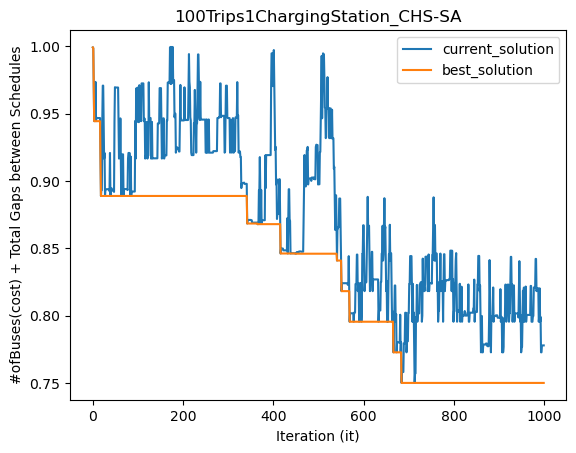

In [8]:
plt.plot(range(it_100_1), costs_100_1, label="current_solution")
plt.plot(range(it_100_1), best_costs_100_1, label="best_solution")
# plt.gca().invert_xaxis()
plt.xlabel("Iteration (it)")
# plt.ylabel("[weighted_sum] #ofBuses + Total Gap Time (cost)")
plt.ylabel("#ofBuses(cost) + Total Gaps between Schedules")
plt.title("100Trips1ChargingStation_CHS-SA")
plt.legend(loc="upper right")
#plt.savefig("100Trips1CS.png")

      name   type  duration  dep_time  arr_time    dep_term    arr_term   ID
0    DEPOT  depot         0         0      1440           -           -    0
1      AB1   trip       135       430       565  Terminal A  Terminal B    1
2      AB2   trip       135       560       695  Terminal A  Terminal B    2
3      AB3   trip       135       720       855  Terminal A  Terminal B    3
4      AB4   trip       135       740       875  Terminal A  Terminal B    4
..     ...    ...       ...       ...       ...         ...         ...  ...
97     DC7   trip        70       590       660  Terminal D  Terminal C   97
98     DC8   trip        80       780       860  Terminal D  Terminal C   98
99     DC9   trip        95       965      1060  Terminal D  Terminal C   99
100   DC10   trip        85      1005      1090  Terminal D  Terminal C  100
101    CS1     cs        50         0      1440           -           -  101

[102 rows x 8 columns]
      name   type  duration  dep_time  arr_time    d

      name   type  duration  dep_time  arr_time    dep_term    arr_term   ID
0    DEPOT  depot         0         0      1440           -           -    0
1      AB1   trip       135       430       565  Terminal A  Terminal B    1
2      AB2   trip       135       560       695  Terminal A  Terminal B    2
3      AB3   trip       135       720       855  Terminal A  Terminal B    3
4      AB4   trip       135       740       875  Terminal A  Terminal B    4
..     ...    ...       ...       ...       ...         ...         ...  ...
97     DC7   trip        70       590       660  Terminal D  Terminal C   97
98     DC8   trip        80       780       860  Terminal D  Terminal C   98
99     DC9   trip        95       965      1060  Terminal D  Terminal C   99
100   DC10   trip        85      1005      1090  Terminal D  Terminal C  100
101    CS1     cs        50         0      1440           -           -  101

[102 rows x 8 columns]
      name   type  duration  dep_time  arr_time    d

IndexError: tuple index out of range

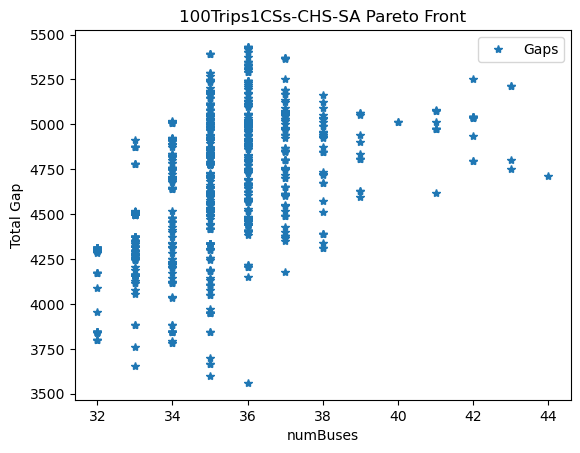

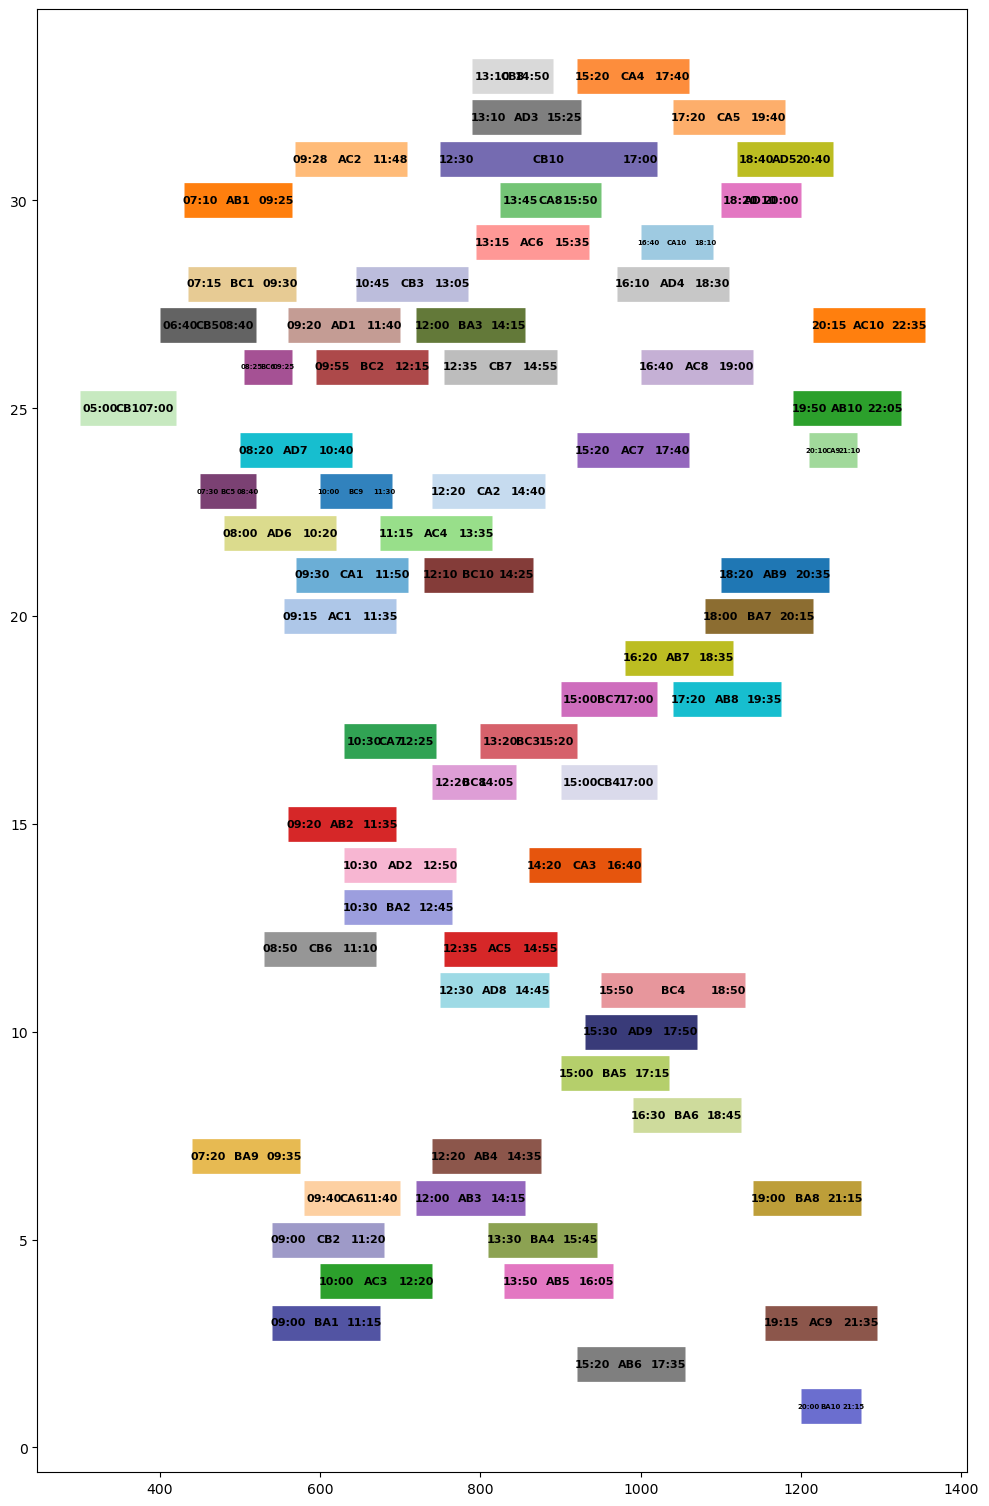

In [12]:
HundredTrips_1cs_df = visualizeSolution(solution_spaces_100_1[1:], "100Trips1CSs-CHS-SA Pareto Front", all_schs_1cs, recharge_1cs_arcs)
newdf_100_1cs = visualizeResult(new_schedule_100_1, all_schs_1cs, "CHS_100Trips-1CS")

trips100_df_1cs = newdf_100_1cs.copy(deep=True)
trips100_df_1cs['next_dep'] = trips100_df_1cs.groupby('bus_id')['dep_time'].shift(-1).fillna(0)
trips100_df_1cs['difference'] = trips100_df_1cs['next_dep'] - trips100_df_1cs['arr_time']
trips100_df_1cs['difference'] = trips100_df_1cs['difference'].apply(lambda x: 0 if x < 0 else x)
trips100_soln_1cs = trips100_df_1cs.groupby(['bus_id'])['difference'].sum()

chs_100Trips1cs_IDLE_soln = trips100_soln_1cs.groupby(['bus_id']).agg(
    trips=('trip_id', concat_str),
    numRecharge=('trip_id',countRecharge),
    numTrips=('trip_id', countTrips),
    gapTime=('difference', 'sum')
)
chs_100Trips1cs_IDLE_soln.sort_values(['gapTime'], ascending=False)

In [9]:
################################################################### 3CS #############################################################################################
## Creating Phi and Delta
recharge_3cs_arcs = feasible_recharge(trips_df, cs_deadheads, recharge=charging_stations2, terminals=terminals)
print(recharge_3cs_arcs)
cs_ids = set(list(charging_stations2.keys()))
all_schedules_3cs = {**trips, **charging_stations2}
all_schs_3cs = pd.DataFrame.from_dict(all_schedules_3cs, orient='index')
all_schs_3cs['ID'] = range(len(all_schs_3cs))
durations_3cs = {idx: {'duration': all_schs_3cs.loc[idx, 'duration']} for idx in all_schs_3cs.index if idx != 0}

###### import time
start_time = time.time()
print(f"{time.ctime()}")
test_schedules_tab, schedules_100_3 = constructiveScheduler(all_schs_3cs, arcs, recharge_3cs_arcs, set(cs_ids))
test_solution = vectorSchRepresentation(schedules_100_3)
end_time = time.time()
g_T100CS3_time = end_time - start_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {g_T100CS3_time} seconds")
print(f"number of buses = {len(schedules_100_3)}")
print(schedules_100_3)
print('-'*100)
print("starting simulated annealing....")
start_time = time.time()
new_schedule_100_3, cost_100_3, cost_diffs_100_3, temp_100_3, it_100_3, costs_100_3, solutionspaces_100_3, best_100_3 = annealing(test_solution, all_schs_3cs, arcs, recharge_3cs_arcs)


{(1, 3, 101): {'duration': 40}, (1, 4, 101): {'duration': 40}, (1, 5, 101): {'duration': 40}, (1, 6, 101): {'duration': 40}, (1, 7, 101): {'duration': 40}, (1, 8, 101): {'duration': 40}, (1, 9, 101): {'duration': 40}, (1, 10, 101): {'duration': 40}, (1, 14, 101): {'duration': 40}, (1, 15, 101): {'duration': 40}, (1, 16, 101): {'duration': 40}, (1, 17, 101): {'duration': 40}, (1, 18, 101): {'duration': 40}, (1, 19, 101): {'duration': 40}, (1, 20, 101): {'duration': 40}, (1, 23, 101): {'duration': 40}, (1, 24, 101): {'duration': 40}, (1, 25, 101): {'duration': 40}, (1, 28, 101): {'duration': 40}, (1, 29, 101): {'duration': 40}, (1, 30, 101): {'duration': 40}, (1, 33, 101): {'duration': 40}, (1, 34, 101): {'duration': 40}, (1, 35, 101): {'duration': 40}, (1, 36, 101): {'duration': 40}, (1, 37, 101): {'duration': 40}, (1, 38, 101): {'duration': 40}, (1, 40, 101): {'duration': 40}, (1, 43, 101): {'duration': 40}, (1, 44, 101): {'duration': 40}, (1, 47, 101): {'duration': 40}, (1, 48, 101): 

Fri Feb 28 15:08:55 2025
Time elapse to compute the solution = 734.2649412155151 seconds
number of buses = 30
[[(0, 61), (61, 39), (39, 87, 101), (87, 86), (86, 78), (78, 60), (60, 79), (79, 10), (10, 0)], [(0, 65), (65, 2), (2, 88, 101), (88, 47), (47, 55), (55, 20), (20, 0)], [(0, 1), (1, 77), (77, 14, 102), (14, 75), (75, 18), (18, 40), (40, 0)], [(0, 41), (41, 3), (3, 64), (64, 8, 102), (8, 59), (59, 0)], [(0, 45), (45, 11), (11, 4), (4, 7, 101), (7, 19), (19, 0)], [(0, 71), (71, 22), (22, 5, 102), (5, 36), (36, 85), (85, 0)], [(0, 76), (76, 63), (63, 34, 103), (34, 24), (24, 38), (38, 0)], [(0, 26), (26, 15), (15, 100, 101), (100, 25), (25, 0)], [(0, 27), (27, 16), (16, 44, 103), (44, 90), (90, 0)], [(0, 46), (46, 13), (13, 23), (23, 89), (89, 9, 102), (9, 0)], [(0, 66), (66, 28), (28, 6, 102), (6, 30), (30, 0)], [(0, 96), (96, 33), (33, 99, 101), (99, 37), (37, 0)], [(0, 31), (31, 48), (48, 84, 101), (84, 0)], [(0, 62), (62, 50), (50, 94, 101), (94, 0)], [(0, 72), (72, 52), (52, 

proposed solution = [[56, 98, 54, 0], [97, 43, 0], [42, 53, 0], [73, 58, 0], [49, 69, 0], [91, 74, 0], [57, 80, 0], [92, 0], [93, 0], [75, 0], [14, 0], [81, 18, 0], [87, 0], [46, 13, 23, 89, 0], [12, 68, 99, 0], [32, 83, 102, 9, 0], [61, 39, 101, 70, 37, 0], [65, 2, 101, 88, 47, 55, 20, 0], [1, 77, 101, 86, 78, 60, 79, 10, 0], [41, 3, 64, 102, 8, 59, 0], [45, 11, 4, 101, 7, 19, 0], [71, 22, 102, 5, 36, 85, 0], [76, 63, 0], [26, 15, 101, 100, 25, 0], [27, 16, 103, 44, 90, 0], [66, 28, 102, 6, 30, 0], [96, 33, 102, 29, 0], [31, 48, 101, 84, 40, 0], [62, 50, 101, 94, 38, 0], [72, 52, 101, 95, 0], [21, 67, 102, 17, 0], [51, 82, 103, 35, 0], [34, 0], [24, 0]]
----------------------------------------------------------------------------------------------------
Iteration 11...
insertion...
proposed solution = [[56, 98, 54, 0], [97, 43, 0], [42, 53, 0], [73, 58, 0], [49, 69, 0], [91, 74, 0], [57, 80, 0], [93, 0], [75, 0], [14, 0], [81, 18, 0], [87, 0], [46, 13, 23, 89, 0], [12, 68, 99, 0], [32,

----------------------------------------------------------------------------------------------------
Iteration 21...
swapping other CS...
proposed solution = [[56, 98, 54, 0], [97, 43, 0], [42, 53, 0], [73, 58, 0], [49, 69, 0], [91, 74, 0], [57, 80, 0], [14, 75, 0], [81, 18, 0], [87, 93, 59, 0], [46, 13, 23, 89, 0], [12, 68, 99, 0], [92, 24, 0], [65, 2, 0], [8, 0], [88, 0], [47, 0], [64, 0], [76, 63, 103, 34, 0], [32, 83, 101, 9, 0], [61, 39, 101, 70, 37, 0], [1, 77, 101, 86, 78, 60, 79, 10, 0], [41, 3, 101, 55, 20, 0], [45, 11, 4, 101, 7, 19, 0], [71, 22, 102, 5, 36, 85, 0], [26, 15, 101, 100, 25, 0], [27, 16, 103, 44, 90, 0], [66, 28, 102, 6, 30, 0], [96, 33, 102, 29, 0], [31, 48, 101, 84, 40, 0], [62, 50, 101, 94, 38, 0], [72, 52, 101, 95, 0], [21, 67, 102, 17, 0], [51, 82, 103, 35, 0]]
----------------------------------------------------------------------------------------------------
Iteration 22...
insertion...
proposed solution = [[56, 98, 54, 0], [97, 43, 0], [42, 53, 0], [73, 

proposed solution = [[56, 98, 54, 0], [97, 43, 0], [42, 53, 0], [73, 58, 0], [49, 69, 0], [91, 74, 0], [57, 80, 0], [14, 75, 0], [81, 18, 0], [87, 93, 59, 0], [46, 13, 23, 89, 0], [92, 24, 0], [82, 8, 0], [77, 4, 47, 0], [51, 86, 64, 0], [12, 68, 99, 103, 37, 0], [65, 2, 101, 7, 0], [11, 88, 103, 35, 0], [76, 63, 103, 34, 60, 0], [1, 32, 83, 101, 9, 0], [61, 39, 102, 5, 36, 0], [41, 3, 101, 55, 20, 0], [26, 15, 101, 100, 25, 0], [27, 16, 103, 44, 90, 0], [66, 28, 102, 6, 30, 0], [96, 33, 102, 29, 0], [31, 48, 78, 84, 103, 40, 0], [62, 50, 101, 94, 38, 0], [72, 52, 101, 95, 19, 0], [45, 21, 67, 102, 17, 79, 10, 0], [71, 70, 101, 85, 0], [22, 0]]
----------------------------------------------------------------------------------------------------
Iteration 33...
swapping other CS...
proposed solution = [[56, 98, 54, 0], [97, 43, 0], [42, 53, 0], [73, 58, 0], [49, 69, 0], [91, 74, 0], [57, 80, 0], [14, 75, 0], [81, 18, 0], [87, 93, 59, 0], [46, 13, 23, 89, 0], [92, 24, 0], [82, 8, 0], [77,

----------------------------------------------------------------------------------------------------
Iteration 43...
swapping recharging task...
proposed solution = [[56, 98, 54, 0], [73, 58, 0], [49, 69, 0], [91, 74, 0], [57, 80, 0], [14, 75, 0], [81, 18, 0], [87, 93, 37, 0], [77, 4, 47, 0], [51, 86, 64, 0], [33, 29, 0], [46, 13, 23, 89, 0], [12, 68, 99, 101, 59, 0], [96, 92, 102, 24, 0], [65, 2, 82, 102, 7, 0], [11, 88, 103, 35, 0], [76, 63, 103, 34, 60, 0], [1, 32, 83, 102, 9, 0], [61, 39, 103, 42, 5, 36, 0], [41, 97, 102, 3, 55, 20, 0], [26, 15, 101, 100, 25, 0], [27, 16, 103, 44, 90, 0], [66, 28, 102, 6, 30, 0], [31, 48, 78, 84, 103, 40, 0], [62, 50, 101, 94, 38, 0], [72, 52, 101, 95, 19, 0], [45, 21, 67, 102, 17, 79, 10, 0], [71, 70, 101, 85, 0], [22, 43, 0], [53, 0], [8, 0]]
----------------------------------------------------------------------------------------------------
Iteration 44...
insertion...
proposed solution = [[56, 98, 54, 0], [49, 69, 0], [91, 74, 0], [57, 80, 0], 

----------------------------------------------------------------------------------------------------
Iteration 54...
insertion...
proposed solution = [[56, 98, 54, 0], [49, 69, 0], [91, 74, 0], [14, 75, 0], [81, 18, 0], [87, 93, 37, 0], [77, 4, 47, 0], [51, 86, 90, 0], [33, 29, 0], [96, 92, 0], [27, 16, 0], [66, 28, 0], [22, 43, 102, 24, 0], [32, 53, 0], [83, 9, 0], [6, 0], [64, 0], [57, 80, 0], [44, 0], [46, 13, 23, 89, 102, 30, 0], [12, 68, 99, 101, 59, 0], [65, 2, 82, 101, 7, 0], [11, 88, 103, 35, 0], [76, 63, 103, 34, 60, 0], [61, 39, 103, 42, 5, 36, 0], [41, 97, 102, 3, 55, 20, 0], [26, 15, 101, 100, 25, 0], [31, 48, 78, 84, 103, 40, 0], [62, 50, 101, 94, 38, 0], [72, 52, 101, 95, 19, 0], [45, 21, 67, 102, 17, 79, 10, 0], [71, 70, 101, 85, 0], [1, 73, 101, 58, 8, 0]]
----------------------------------------------------------------------------------------------------
Iteration 55...
insertion...
proposed solution = [[56, 98, 54, 0], [91, 74, 0], [14, 75, 0], [81, 18, 0], [87, 93, 3

proposed solution = [[56, 98, 54, 0], [91, 74, 0], [14, 75, 0], [81, 18, 0], [87, 93, 37, 0], [77, 4, 47, 0], [51, 86, 90, 0], [33, 29, 0], [96, 92, 0], [27, 16, 0], [66, 28, 102, 6, 0], [32, 53, 101, 25, 0], [83, 9, 0], [64, 0], [57, 80, 0], [12, 68, 99, 0], [71, 70, 0], [49, 69, 24, 101, 59, 0], [22, 43, 103, 44, 0], [46, 13, 23, 89, 102, 30, 0], [65, 2, 82, 101, 7, 0], [11, 88, 103, 35, 0], [76, 63, 103, 34, 60, 0], [61, 39, 103, 42, 5, 36, 0], [41, 97, 102, 3, 55, 20, 0], [26, 15, 0], [31, 48, 78, 84, 103, 40, 0], [62, 50, 101, 94, 38, 0], [72, 52, 101, 95, 19, 0], [45, 21, 67, 102, 17, 79, 10, 0], [1, 73, 101, 58, 8, 85, 0], [100, 0]]
----------------------------------------------------------------------------------------------------
Iteration 66...
insertion...
proposed solution = [[56, 98, 54, 0], [91, 74, 0], [14, 75, 0], [81, 18, 0], [87, 93, 37, 0], [77, 4, 47, 0], [51, 86, 90, 0], [33, 29, 0], [27, 16, 0], [66, 28, 102, 6, 0], [32, 53, 101, 25, 0], [83, 9, 0], [64, 0], [57, 

----------------------------------------------------------------------------------------------------
Iteration 76...
insertion...
proposed solution = [[56, 98, 54, 0], [91, 74, 0], [14, 75, 0], [81, 18, 0], [87, 93, 37, 0], [77, 4, 47, 0], [51, 86, 90, 0], [33, 29, 0], [27, 16, 0], [83, 9, 0], [57, 80, 0], [12, 68, 99, 0], [71, 70, 0], [26, 15, 0], [66, 28, 0], [22, 43, 0], [41, 97, 64, 0], [44, 0], [6, 0], [3, 100, 0], [32, 53, 101, 25, 0], [49, 69, 24, 101, 59, 0], [46, 13, 23, 89, 102, 30, 0], [65, 2, 82, 101, 55, 20, 0], [11, 88, 103, 35, 0], [76, 63, 103, 34, 60, 0], [61, 39, 103, 42, 5, 36, 0], [31, 48, 78, 84, 103, 40, 0], [62, 50, 101, 94, 38, 0], [72, 52, 101, 95, 19, 0], [45, 21, 67, 102, 17, 79, 10, 0], [1, 73, 101, 58, 8, 85, 0], [96, 92, 102, 7, 0]]
----------------------------------------------------------------------------------------------------
Iteration 77...
insertion...
proposed solution = [[56, 98, 54, 0], [91, 74, 0], [14, 75, 0], [81, 18, 0], [87, 93, 37, 0], [77

----------------------------------------------------------------------------------------------------
Iteration 87...
insertion...
proposed solution = [[56, 98, 54, 0], [91, 74, 0], [14, 75, 0], [81, 18, 0], [87, 93, 37, 0], [77, 4, 47, 0], [51, 86, 90, 0], [33, 29, 0], [27, 16, 0], [83, 9, 0], [57, 80, 0], [71, 70, 0], [26, 15, 0], [41, 97, 64, 0], [69, 6, 0], [49, 3, 100, 0], [11, 88, 0], [76, 63, 0], [72, 52, 103, 35, 0], [34, 60, 0], [95, 0], [12, 68, 99, 101, 85, 0], [66, 28, 102, 24, 0], [22, 43, 103, 44, 19, 0], [46, 13, 23, 89, 102, 30, 0], [65, 2, 82, 101, 55, 20, 0], [61, 39, 103, 42, 5, 36, 0], [31, 48, 78, 84, 103, 40, 0], [62, 50, 101, 94, 38, 0], [45, 21, 67, 102, 17, 79, 10, 0], [1, 73, 101, 53, 25, 0], [96, 92, 102, 7, 59, 0], [32, 58, 101, 8, 0]]
----------------------------------------------------------------------------------------------------
Iteration 88...
swapping recharging task...
proposed solution = [[56, 98, 54, 0], [91, 74, 0], [14, 75, 0], [81, 18, 0], [87, 

----------------------------------------------------------------------------------------------------
Iteration 98...
insertion...
proposed solution = [[91, 74, 0], [14, 75, 0], [81, 18, 0], [87, 93, 37, 0], [77, 4, 47, 0], [51, 86, 30, 0], [33, 29, 0], [27, 16, 0], [83, 9, 0], [57, 80, 0], [71, 70, 0], [26, 15, 0], [41, 97, 64, 0], [69, 6, 0], [49, 3, 100, 0], [11, 88, 0], [72, 52, 101, 95, 0], [34, 60, 0], [56, 98, 38, 0], [46, 13, 23, 89, 0], [54, 0], [12, 68, 99, 101, 85, 0], [66, 28, 102, 24, 0], [22, 43, 103, 44, 19, 0], [65, 2, 82, 101, 55, 20, 0], [61, 39, 103, 42, 5, 36, 0], [31, 48, 78, 84, 103, 40, 0], [62, 50, 101, 94, 90, 0], [45, 21, 67, 102, 17, 79, 10, 0], [1, 73, 101, 53, 25, 0], [96, 92, 101, 7, 59, 0], [32, 58, 101, 8, 0], [76, 63, 101, 35, 0]]
----------------------------------------------------------------------------------------------------
Iteration 99...
insertion...
proposed solution = [[91, 74, 0], [14, 75, 0], [81, 18, 0], [87, 93, 37, 0], [77, 4, 47, 0], [51,

----------------------------------------------------------------------------------------------------
Iteration 109...
swapping other CS...
proposed solution = [[91, 74, 0], [14, 75, 0], [77, 4, 47, 0], [51, 86, 30, 0], [33, 29, 0], [27, 16, 0], [83, 9, 0], [57, 80, 0], [71, 70, 0], [26, 15, 0], [41, 97, 64, 0], [69, 6, 0], [49, 3, 100, 0], [34, 60, 0], [56, 98, 38, 0], [13, 54, 0], [62, 50, 0], [87, 93, 37, 0], [81, 18, 0], [96, 23, 59, 0], [92, 7, 0], [94, 0], [11, 88, 89, 101, 90, 0], [72, 52, 101, 95, 0], [12, 68, 99, 101, 85, 0], [66, 28, 102, 24, 0], [22, 43, 103, 44, 19, 0], [65, 2, 82, 101, 55, 20, 0], [61, 39, 103, 42, 5, 36, 0], [31, 48, 78, 84, 103, 40, 0], [45, 21, 67, 102, 17, 79, 10, 0], [1, 73, 101, 53, 25, 0], [46, 32, 58, 101, 8, 0], [76, 63, 101, 35, 0]]
----------------------------------------------------------------------------------------------------
Iteration 110...
insertion...
proposed solution = [[91, 74, 0], [14, 75, 0], [77, 4, 47, 0], [51, 86, 30, 0], [33, 29

----------------------------------------------------------------------------------------------------
Iteration 120...
insertion...
proposed solution = [[14, 75, 0], [77, 4, 47, 0], [33, 29, 0], [27, 16, 0], [83, 9, 0], [57, 80, 0], [71, 70, 0], [26, 15, 0], [69, 6, 0], [49, 3, 100, 0], [34, 60, 0], [56, 98, 38, 0], [13, 54, 0], [81, 18, 0], [96, 23, 59, 0], [92, 7, 0], [87, 93, 94, 0], [91, 74, 0], [22, 43, 0], [45, 21, 67, 0], [44, 0], [64, 37, 0], [41, 97, 101, 19, 0], [62, 50, 103, 35, 0], [11, 88, 30, 0], [72, 52, 101, 95, 90, 0], [12, 68, 99, 101, 85, 0], [66, 28, 102, 24, 0], [65, 2, 82, 102, 17, 79, 10, 0], [61, 39, 103, 42, 5, 36, 0], [31, 48, 78, 84, 103, 40, 0], [1, 73, 101, 53, 25, 0], [46, 32, 58, 101, 8, 0], [76, 63, 101, 89, 20, 0], [51, 86, 55, 0]]
----------------------------------------------------------------------------------------------------
Iteration 121...
insertion...
proposed solution = [[14, 75, 0], [77, 4, 47, 0], [33, 29, 0], [27, 16, 0], [83, 9, 0], [57, 80

----------------------------------------------------------------------------------------------------
Iteration 131...
swapping recharging task...
proposed solution = [[77, 4, 47, 0], [27, 16, 0], [83, 9, 0], [57, 80, 0], [71, 70, 0], [26, 15, 0], [69, 6, 0], [49, 3, 100, 0], [34, 60, 0], [56, 98, 38, 0], [13, 54, 0], [81, 18, 0], [92, 7, 0], [87, 93, 94, 0], [91, 74, 0], [22, 43, 0], [62, 50, 0], [12, 68, 99, 103, 37, 0], [51, 86, 30, 0], [14, 75, 59, 0], [45, 21, 67, 101, 85, 0], [96, 64, 0], [41, 97, 101, 23, 44, 19, 0], [11, 88, 0], [72, 52, 101, 95, 90, 0], [66, 28, 102, 24, 0], [65, 2, 82, 102, 17, 79, 10, 0], [61, 39, 103, 42, 5, 36, 0], [31, 48, 78, 84, 103, 40, 0], [1, 73, 101, 53, 25, 0], [46, 32, 58, 101, 8, 0], [76, 63, 101, 89, 20, 0], [33, 29, 0], [35, 0], [55, 0]]
----------------------------------------------------------------------------------------------------
Iteration 132...
insertion...
proposed solution = [[77, 4, 47, 0], [27, 16, 0], [83, 9, 0], [57, 80, 0], [71, 

proposed solution = [[77, 4, 47, 0], [83, 9, 0], [57, 80, 0], [71, 70, 0], [26, 15, 0], [69, 6, 0], [49, 3, 100, 0], [34, 60, 0], [56, 98, 38, 0], [13, 54, 0], [81, 18, 0], [87, 93, 94, 0], [91, 74, 0], [62, 50, 0], [14, 75, 59, 0], [11, 88, 64, 0], [51, 86, 37, 0], [27, 16, 0], [96, 33, 0], [35, 0], [12, 68, 99, 102, 30, 0], [45, 21, 67, 102, 29, 85, 0], [41, 97, 102, 23, 44, 19, 0], [72, 52, 101, 95, 90, 0], [66, 28, 101, 7, 0], [65, 2, 82, 102, 17, 79, 10, 0], [61, 39, 103, 42, 5, 36, 0], [31, 48, 78, 84, 103, 40, 0], [1, 73, 101, 53, 25, 0], [46, 32, 58, 101, 8, 0], [76, 63, 101, 89, 20, 0], [22, 43, 101, 55, 0], [92, 24, 0]]
----------------------------------------------------------------------------------------------------
Iteration 143...
insertion...
proposed solution = [[77, 4, 47, 0], [83, 9, 0], [57, 80, 0], [71, 70, 0], [26, 15, 0], [69, 6, 0], [49, 3, 100, 0], [34, 60, 0], [56, 98, 38, 0], [13, 54, 0], [81, 18, 0], [87, 93, 94, 0], [91, 74, 0], [62, 50, 0], [14, 75, 59, 0]

----------------------------------------------------------------------------------------------------
Iteration 153...
swapping recharging task...
proposed solution = [[77, 4, 47, 0], [57, 80, 0], [71, 70, 0], [26, 15, 0], [69, 6, 0], [49, 3, 100, 0], [34, 60, 0], [56, 98, 38, 0], [13, 54, 0], [81, 18, 0], [87, 93, 37, 0], [91, 74, 0], [14, 75, 59, 0], [11, 88, 64, 0], [51, 86, 30, 0], [27, 16, 0], [12, 68, 99, 0], [31, 48, 78, 84, 0], [62, 50, 102, 17, 0], [2, 33, 103, 35, 9, 0], [45, 21, 67, 102, 29, 85, 0], [41, 97, 102, 23, 44, 19, 0], [72, 52, 101, 95, 90, 0], [66, 28, 101, 7, 0], [61, 39, 103, 42, 5, 36, 0], [1, 73, 101, 53, 25, 0], [46, 32, 58, 0], [65, 22, 103, 43, 55, 40, 0], [96, 92, 102, 24, 0], [83, 94, 101, 10, 0], [76, 82, 101, 89, 79, 20, 0], [63, 0], [8, 0]]
----------------------------------------------------------------------------------------------------
Iteration 154...
swapping recharging task...
proposed solution = [[77, 4, 47, 0], [57, 80, 0], [71, 70, 0], [26, 15

----------------------------------------------------------------------------------------------------
Iteration 164...
swapping recharging task...
proposed solution = [[77, 4, 47, 0], [69, 6, 0], [49, 3, 100, 0], [34, 60, 0], [56, 98, 38, 0], [13, 54, 0], [81, 18, 0], [87, 93, 37, 0], [91, 74, 0], [14, 75, 59, 0], [11, 88, 64, 0], [51, 86, 30, 0], [27, 16, 0], [12, 68, 99, 0], [31, 48, 78, 84, 0], [63, 29, 0], [57, 80, 0], [45, 21, 67, 0], [62, 50, 102, 17, 0], [41, 97, 101, 23, 44, 19, 0], [72, 52, 101, 95, 90, 0], [66, 28, 102, 7, 0], [1, 73, 101, 53, 25, 0], [46, 32, 58, 101, 8, 85, 0], [65, 22, 103, 43, 55, 40, 0], [96, 92, 102, 24, 0], [26, 83, 94, 101, 10, 0], [76, 82, 101, 89, 79, 20, 0], [61, 39, 103, 42, 5, 0], [2, 33, 103, 35, 9, 0], [71, 70, 0], [15, 0], [36, 0]]
----------------------------------------------------------------------------------------------------
Iteration 165...
insertion...
proposed solution = [[77, 4, 47, 0], [69, 6, 0], [49, 3, 100, 0], [34, 60, 0], [56, 9

----------------------------------------------------------------------------------------------------
Iteration 175...
insertion...
proposed solution = [[77, 4, 47, 0], [49, 3, 100, 0], [34, 60, 0], [56, 98, 38, 0], [13, 54, 0], [81, 18, 0], [87, 93, 37, 0], [91, 74, 0], [14, 75, 59, 0], [11, 88, 64, 0], [27, 16, 0], [31, 48, 78, 84, 0], [63, 29, 0], [45, 21, 67, 0], [61, 39, 103, 32, 58, 0], [71, 70, 0], [72, 68, 90, 0], [52, 95, 0], [46, 42, 5, 0], [51, 86, 99, 102, 30, 0], [62, 50, 102, 17, 25, 0], [41, 97, 102, 23, 44, 19, 0], [66, 28, 102, 7, 0], [65, 22, 103, 43, 55, 40, 0], [96, 92, 102, 24, 0], [26, 83, 94, 102, 10, 0], [76, 82, 101, 89, 79, 20, 0], [2, 33, 103, 35, 9, 0], [12, 15, 101, 36, 85, 0], [1, 73, 101, 53, 8, 0], [57, 80, 0], [69, 6, 0]]
----------------------------------------------------------------------------------------------------
Iteration 176...
insertion...
proposed solution = [[77, 4, 47, 0], [49, 3, 100, 0], [34, 60, 0], [56, 98, 38, 0], [13, 54, 0], [81, 18,

proposed solution = [[77, 4, 47, 0], [34, 60, 0], [56, 98, 38, 0], [13, 54, 0], [81, 18, 0], [87, 93, 37, 0], [91, 74, 0], [14, 75, 59, 0], [11, 88, 64, 0], [27, 16, 0], [31, 48, 78, 84, 0], [63, 29, 0], [71, 70, 0], [72, 68, 90, 0], [46, 42, 5, 0], [62, 50, 0], [57, 80, 0], [69, 6, 0], [49, 52, 101, 95, 0], [66, 28, 101, 7, 0], [45, 21, 67, 102, 17, 25, 0], [61, 39, 103, 32, 58, 0], [51, 86, 99, 102, 30, 0], [41, 97, 101, 23, 44, 19, 0], [65, 22, 103, 43, 55, 40, 0], [96, 92, 102, 24, 0], [26, 83, 94, 101, 10, 0], [76, 82, 101, 89, 79, 20, 0], [2, 33, 103, 35, 9, 0], [12, 15, 103, 36, 85, 0], [1, 73, 101, 53, 8, 0], [3, 100, 0]]
----------------------------------------------------------------------------------------------------
Iteration 187...
swapping recharging task...
proposed solution = [[77, 4, 47, 0], [34, 60, 0], [56, 98, 38, 0], [13, 54, 0], [81, 18, 0], [87, 93, 37, 0], [91, 74, 0], [14, 75, 59, 0], [11, 88, 64, 0], [27, 16, 0], [31, 48, 78, 84, 0], [63, 29, 0], [71, 70, 0],

----------------------------------------------------------------------------------------------------
Iteration 197...
swapping other CS...
proposed solution = [[56, 98, 38, 0], [81, 18, 0], [87, 93, 37, 0], [91, 74, 0], [14, 75, 59, 0], [11, 88, 64, 0], [27, 16, 0], [63, 29, 0], [71, 70, 0], [72, 68, 90, 0], [46, 42, 5, 0], [62, 50, 0], [57, 80, 0], [96, 3, 100, 0], [34, 60, 0], [77, 4, 47, 0], [48, 78, 84, 0], [31, 69, 102, 6, 0], [13, 23, 103, 44, 0], [49, 52, 101, 95, 19, 0], [66, 28, 102, 7, 0], [45, 21, 67, 102, 17, 25, 0], [61, 39, 103, 32, 58, 24, 0], [51, 86, 99, 102, 30, 0], [41, 97, 101, 92, 54, 0], [65, 22, 103, 43, 55, 40, 0], [26, 83, 94, 101, 10, 0], [76, 82, 101, 89, 79, 20, 0], [2, 33, 103, 35, 9, 0], [12, 15, 101, 36, 85, 0], [1, 73, 101, 53, 8, 0]]
----------------------------------------------------------------------------------------------------
Iteration 198...
insertion...
proposed solution = [[56, 98, 38, 0], [87, 93, 37, 0], [91, 74, 0], [14, 75, 59, 0], [11, 88

proposed solution = [[56, 98, 38, 0], [87, 93, 37, 0], [91, 74, 0], [14, 75, 59, 0], [11, 88, 64, 0], [27, 16, 0], [63, 29, 0], [71, 70, 0], [72, 68, 90, 0], [46, 42, 5, 0], [96, 3, 100, 0], [34, 60, 0], [77, 4, 47, 0], [48, 78, 84, 0], [81, 18, 0], [57, 80, 0], [62, 50, 103, 35, 0], [31, 69, 101, 9, 0], [13, 23, 103, 44, 20, 0], [49, 52, 101, 95, 19, 0], [66, 28, 101, 7, 0], [45, 21, 67, 102, 17, 25, 0], [61, 39, 0], [51, 86, 99, 102, 30, 0], [41, 97, 101, 92, 54, 0], [65, 22, 103, 43, 55, 40, 0], [26, 83, 94, 102, 10, 0], [76, 82, 0], [12, 15, 101, 36, 85, 0], [1, 73, 101, 53, 8, 0], [58, 0], [24, 0], [2, 33, 101, 89, 0], [32, 6, 79, 0]]
----------------------------------------------------------------------------------------------------
Iteration 209...
insertion...
proposed solution = [[56, 98, 38, 0], [87, 93, 37, 0], [91, 74, 0], [14, 75, 59, 0], [11, 88, 64, 0], [27, 16, 0], [63, 29, 0], [71, 70, 0], [72, 68, 90, 0], [46, 42, 5, 0], [96, 3, 100, 0], [34, 60, 0], [77, 4, 47, 0], [

proposed solution = [[56, 98, 38, 0], [87, 93, 37, 0], [91, 74, 0], [14, 75, 59, 0], [11, 88, 64, 0], [27, 16, 0], [63, 29, 0], [71, 70, 0], [72, 68, 90, 0], [46, 42, 5, 0], [34, 60, 0], [77, 4, 47, 0], [48, 78, 84, 0], [81, 18, 0], [57, 80, 0], [32, 6, 79, 0], [96, 58, 0], [12, 15, 101, 36, 0], [61, 39, 101, 3, 24, 0], [76, 82, 101, 100, 0], [62, 50, 103, 35, 0], [31, 69, 101, 9, 0], [13, 23, 103, 44, 20, 0], [49, 52, 101, 95, 19, 0], [66, 28, 0], [45, 21, 67, 102, 17, 25, 0], [51, 86, 99, 102, 30, 0], [41, 97, 101, 92, 54, 0], [65, 22, 103, 43, 55, 40, 0], [26, 83, 94, 102, 10, 0], [1, 73, 101, 53, 8, 0], [2, 33, 101, 89, 85, 0], [7, 0]]
----------------------------------------------------------------------------------------------------
Iteration 221...
insertion...
proposed solution = [[56, 98, 38, 0], [87, 93, 37, 0], [91, 74, 0], [14, 75, 59, 0], [11, 88, 64, 0], [27, 16, 0], [63, 29, 0], [71, 70, 0], [72, 68, 90, 0], [46, 42, 5, 0], [34, 60, 0], [77, 4, 47, 0], [48, 78, 84, 0], [

----------------------------------------------------------------------------------------------------
Iteration 231...
insertion...
proposed solution = [[56, 98, 38, 0], [87, 93, 37, 0], [14, 75, 59, 0], [11, 88, 64, 0], [63, 29, 0], [71, 70, 0], [72, 68, 90, 0], [46, 42, 5, 0], [34, 60, 0], [77, 4, 47, 0], [48, 78, 84, 0], [81, 18, 0], [57, 80, 101, 19, 0], [32, 6, 79, 103, 40, 0], [96, 58, 0], [61, 39, 101, 3, 24, 0], [76, 82, 101, 100, 0], [62, 50, 0], [31, 69, 101, 9, 0], [13, 23, 103, 44, 20, 0], [49, 52, 30, 0], [66, 28, 101, 7, 0], [45, 21, 67, 102, 17, 25, 0], [51, 86, 99, 101, 10, 0], [41, 97, 101, 92, 54, 0], [65, 22, 83, 103, 36, 0], [1, 73, 101, 53, 8, 0], [2, 33, 101, 89, 85, 0], [12, 74, 101, 55, 0], [91, 35, 0], [43, 95, 0], [26, 15, 94, 0], [27, 16, 0]]
----------------------------------------------------------------------------------------------------
Iteration 232...
swapping other CS...
proposed solution = [[56, 98, 38, 0], [87, 93, 37, 0], [14, 75, 59, 0], [11, 88, 6

----------------------------------------------------------------------------------------------------
Iteration 243...
swapping recharging task...
proposed solution = [[87, 93, 37, 0], [14, 75, 59, 0], [11, 88, 64, 0], [72, 68, 90, 0], [46, 42, 5, 0], [34, 60, 0], [77, 4, 47, 0], [48, 78, 84, 0], [56, 81, 101, 18, 0], [96, 58, 0], [62, 50, 0], [49, 52, 30, 0], [91, 98, 103, 35, 0], [97, 43, 95, 0], [26, 15, 94, 0], [27, 16, 0], [92, 54, 0], [57, 80, 102, 19, 0], [32, 6, 79, 103, 40, 0], [61, 39, 102, 3, 24, 0], [31, 69, 102, 29, 9, 0], [41, 13, 102, 23, 44, 20, 0], [66, 28, 102, 7, 0], [45, 21, 67, 102, 17, 25, 0], [51, 86, 99, 101, 10, 0], [65, 22, 83, 103, 36, 0], [1, 73, 101, 53, 8, 0], [2, 33, 0], [12, 74, 101, 55, 0], [76, 82, 101, 100, 85, 0], [63, 38, 0], [71, 70, 0], [89, 0]]
----------------------------------------------------------------------------------------------------
Iteration 244...
insertion...
proposed solution = [[87, 93, 37, 0], [14, 75, 59, 0], [11, 88, 64, 0], [72

----------------------------------------------------------------------------------------------------
Iteration 254...
swapping other CS...
proposed solution = [[87, 93, 37, 0], [14, 75, 59, 0], [11, 88, 64, 0], [72, 68, 90, 0], [46, 42, 5, 0], [77, 4, 47, 0], [48, 78, 84, 0], [62, 50, 0], [49, 52, 30, 0], [26, 15, 94, 0], [27, 16, 0], [92, 54, 0], [2, 33, 0], [71, 70, 0], [91, 98, 89, 0], [96, 34, 60, 0], [97, 58, 0], [61, 39, 0], [51, 86, 99, 0], [3, 0], [24, 0], [43, 95, 102, 10, 0], [56, 81, 101, 18, 0], [57, 80, 101, 19, 0], [32, 6, 79, 103, 40, 0], [31, 69, 102, 29, 9, 0], [41, 13, 102, 23, 44, 20, 0], [45, 21, 67, 102, 17, 25, 0], [65, 22, 83, 103, 36, 0], [1, 73, 101, 53, 8, 0], [12, 74, 101, 55, 0], [76, 82, 101, 100, 85, 0], [63, 35, 101, 38, 0], [66, 28, 102, 7, 0]]
----------------------------------------------------------------------------------------------------
Iteration 255...
swapping recharging task...
proposed solution = [[87, 93, 37, 0], [14, 75, 59, 0], [11, 88, 64,

----------------------------------------------------------------------------------------------------
Iteration 265...
insertion...
proposed solution = [[87, 93, 37, 0], [14, 75, 59, 0], [11, 88, 64, 0], [72, 68, 90, 0], [46, 42, 5, 0], [77, 4, 47, 0], [48, 78, 84, 0], [49, 52, 30, 0], [26, 15, 94, 0], [92, 54, 0], [2, 33, 0], [91, 98, 89, 0], [96, 34, 60, 0], [97, 58, 0], [51, 86, 99, 0], [3, 24, 0], [62, 50, 0], [61, 39, 101, 70, 0], [66, 28, 102, 29, 9, 0], [76, 82, 102, 7, 0], [31, 43, 95, 102, 10, 0], [56, 81, 102, 18, 0], [57, 80, 100, 102, 19, 0], [32, 69, 102, 6, 79, 40, 0], [41, 13, 102, 23, 44, 20, 0], [45, 21, 67, 102, 17, 25, 0], [65, 22, 83, 103, 36, 0], [1, 73, 101, 53, 8, 0], [12, 74, 101, 55, 85, 0], [71, 63, 103, 35, 38, 0], [27, 16, 0]]
----------------------------------------------------------------------------------------------------
Iteration 266...
insertion...
proposed solution = [[87, 93, 37, 0], [14, 75, 59, 0], [11, 88, 64, 0], [72, 68, 90, 0], [46, 42, 5, 0], 

----------------------------------------------------------------------------------------------------
Iteration 276...
swapping recharging task...
proposed solution = [[87, 93, 37, 0], [14, 75, 59, 0], [11, 88, 64, 0], [46, 42, 5, 0], [77, 4, 47, 0], [48, 78, 84, 0], [49, 52, 30, 0], [26, 15, 94, 0], [92, 54, 0], [2, 33, 0], [91, 98, 89, 0], [96, 34, 60, 0], [97, 58, 0], [51, 86, 99, 101, 10, 0], [70, 0], [72, 3, 0], [62, 50, 103, 35, 0], [61, 39, 101, 68, 0], [66, 28, 102, 29, 9, 0], [76, 82, 101, 7, 0], [31, 43, 95, 0], [56, 81, 101, 18, 0], [57, 80, 100, 102, 19, 0], [32, 69, 102, 6, 79, 40, 0], [41, 13, 102, 23, 44, 20, 0], [45, 21, 67, 102, 17, 25, 0], [65, 22, 83, 103, 36, 0], [1, 73, 101, 53, 8, 0], [12, 74, 101, 55, 85, 0], [27, 16, 101, 90, 0], [71, 63, 103, 38, 0], [24, 0]]
----------------------------------------------------------------------------------------------------
Iteration 277...
swapping other CS...
proposed solution = [[87, 93, 37, 0], [14, 75, 59, 0], [11, 88, 64,

----------------------------------------------------------------------------------------------------
Iteration 287...
swapping recharging task...
proposed solution = [[87, 93, 37, 0], [14, 75, 59, 0], [11, 88, 64, 0], [77, 4, 47, 0], [48, 78, 84, 0], [49, 52, 30, 0], [26, 15, 94, 0], [2, 33, 0], [91, 98, 89, 0], [96, 34, 60, 0], [97, 58, 0], [72, 3, 0], [41, 32, 69, 101, 19, 0], [65, 22, 83, 0], [6, 0], [16, 79, 0], [54, 0], [27, 92, 101, 36, 20, 0], [31, 43, 95, 103, 40, 0], [51, 86, 99, 101, 10, 0], [62, 50, 103, 35, 0], [61, 39, 102, 13, 68, 44, 0], [66, 28, 102, 29, 9, 0], [76, 82, 102, 7, 0], [56, 81, 101, 18, 90, 0], [57, 80, 100, 0], [45, 21, 67, 102, 17, 25, 0], [1, 73, 101, 53, 8, 0], [12, 74, 101, 55, 85, 0], [71, 63, 101, 24, 38, 0], [70, 0], [42, 23, 0], [46, 5, 0]]
----------------------------------------------------------------------------------------------------
Iteration 288...
swapping recharging task...
proposed solution = [[87, 93, 37, 0], [14, 75, 59, 0], [11, 88, 6

proposed solution = [[87, 93, 37, 0], [14, 75, 59, 0], [11, 88, 64, 0], [77, 4, 47, 0], [48, 78, 84, 0], [49, 52, 30, 0], [2, 33, 0], [91, 98, 89, 0], [96, 34, 60, 0], [97, 58, 0], [65, 22, 83, 0], [6, 0], [3, 54, 0], [56, 81, 0], [57, 80, 100, 0], [72, 70, 0], [42, 23, 0], [46, 5, 0], [41, 32, 69, 101, 55, 0], [21, 67, 102, 18, 0], [26, 15, 94, 101, 85, 0], [27, 92, 103, 36, 20, 0], [31, 43, 95, 103, 40, 0], [51, 86, 99, 102, 10, 0], [62, 50, 103, 35, 25, 0], [61, 39, 102, 13, 68, 44, 0], [66, 28, 102, 29, 9, 0], [76, 82, 101, 7, 19, 0], [1, 73, 101, 53, 8, 0], [45, 12, 74, 102, 17, 90, 0], [71, 63, 102, 24, 38, 0], [16, 79, 0]]
----------------------------------------------------------------------------------------------------
Iteration 299...
swapping other CS...
proposed solution = [[87, 93, 37, 0], [14, 75, 59, 0], [11, 88, 64, 0], [77, 4, 47, 0], [48, 78, 84, 0], [49, 52, 30, 0], [2, 33, 0], [91, 98, 89, 0], [96, 34, 60, 0], [97, 58, 0], [65, 22, 83, 0], [6, 0], [3, 54, 0], [56, 

----------------------------------------------------------------------------------------------------
Iteration 309...
insertion...
proposed solution = [[87, 93, 37, 0], [11, 88, 64, 0], [77, 4, 47, 0], [48, 78, 84, 0], [49, 52, 30, 0], [91, 98, 89, 0], [96, 34, 60, 0], [97, 58, 0], [65, 22, 83, 0], [3, 54, 0], [57, 80, 100, 0], [72, 70, 0], [42, 23, 0], [46, 5, 0], [66, 16, 79, 0], [2, 33, 0], [28, 29, 0], [14, 75, 59, 0], [21, 67, 101, 18, 0], [56, 81, 102, 6, 9, 0], [41, 32, 69, 101, 55, 0], [26, 15, 94, 101, 85, 0], [27, 92, 101, 36, 20, 0], [31, 43, 95, 101, 40, 0], [51, 86, 99, 102, 10, 0], [62, 50, 103, 35, 25, 0], [61, 39, 102, 13, 68, 44, 0], [76, 82, 102, 7, 19, 0], [1, 73, 101, 53, 8, 0], [45, 12, 74, 102, 17, 90, 0], [71, 63, 101, 24, 38, 0]]
----------------------------------------------------------------------------------------------------
Iteration 310...
swapping other CS...
proposed solution = [[87, 93, 37, 0], [11, 88, 64, 0], [77, 4, 47, 0], [48, 78, 84, 0], [49, 52, 

proposed solution = [[87, 93, 37, 0], [11, 88, 64, 0], [77, 4, 47, 0], [48, 78, 84, 0], [49, 52, 30, 0], [91, 98, 89, 0], [96, 34, 60, 0], [65, 22, 83, 0], [72, 70, 0], [42, 23, 0], [46, 5, 0], [66, 16, 79, 0], [2, 33, 0], [97, 28, 29, 0], [14, 75, 59, 0], [21, 67, 0], [62, 50, 103, 35, 0], [58, 18, 0], [57, 80, 100, 102, 25, 0], [56, 81, 102, 6, 9, 0], [41, 32, 69, 101, 55, 0], [26, 15, 94, 101, 85, 0], [27, 92, 101, 36, 20, 0], [31, 43, 95, 103, 40, 0], [51, 86, 99, 102, 10, 0], [61, 39, 102, 13, 68, 44, 0], [76, 82, 101, 7, 19, 0], [1, 73, 101, 53, 8, 0], [45, 12, 74, 102, 17, 90, 0], [71, 63, 102, 24, 38, 0], [3, 54, 0]]
----------------------------------------------------------------------------------------------------
Iteration 321...
insertion...
proposed solution = [[87, 93, 37, 0], [11, 88, 64, 0], [77, 4, 47, 0], [48, 78, 84, 0], [49, 52, 30, 0], [91, 98, 89, 0], [96, 34, 60, 0], [65, 22, 83, 0], [42, 23, 0], [46, 5, 0], [66, 16, 79, 0], [2, 33, 0], [97, 28, 29, 0], [14, 75, 

----------------------------------------------------------------------------------------------------
Iteration 331...
swapping recharging task...
proposed solution = [[87, 93, 37, 0], [11, 88, 64, 0], [77, 4, 47, 0], [48, 78, 84, 0], [49, 52, 30, 0], [91, 98, 89, 0], [96, 34, 60, 0], [42, 23, 0], [46, 5, 0], [66, 16, 79, 0], [2, 33, 0], [97, 28, 29, 0], [14, 75, 59, 0], [21, 67, 0], [26, 15, 94, 103, 38, 0], [3, 54, 0], [61, 39, 0], [70, 0], [13, 0], [68, 0], [44, 0], [65, 22, 83, 101, 85, 0], [62, 50, 103, 35, 0], [72, 58, 102, 18, 0], [57, 80, 100, 102, 25, 0], [41, 32, 69, 101, 55, 0], [27, 92, 103, 36, 20, 0], [31, 43, 95, 103, 40, 0], [51, 86, 99, 102, 10, 0], [76, 82, 102, 7, 19, 0], [1, 73, 101, 53, 8, 0], [45, 12, 74, 102, 17, 90, 0], [71, 63, 0], [56, 81, 102, 6, 9, 0], [24, 0]]
----------------------------------------------------------------------------------------------------
Iteration 332...
swapping recharging task...
proposed solution = [[87, 93, 37, 0], [11, 88, 64, 0], 

----------------------------------------------------------------------------------------------------
Iteration 342...
swapping recharging task...
proposed solution = [[87, 93, 37, 0], [11, 88, 64, 0], [77, 4, 47, 0], [48, 78, 84, 0], [49, 52, 30, 0], [91, 98, 89, 0], [96, 34, 60, 0], [46, 42, 5, 0], [2, 33, 0], [97, 28, 29, 0], [21, 67, 0], [3, 54, 0], [14, 44, 0], [31, 43, 95, 0], [71, 63, 0], [41, 32, 69, 0], [75, 55, 59, 0], [23, 0], [13, 68, 102, 24, 0], [66, 16, 101, 79, 40, 0], [26, 15, 94, 103, 38, 0], [61, 39, 101, 70, 0], [65, 22, 83, 101, 85, 0], [62, 50, 103, 35, 0], [72, 58, 0], [57, 80, 100, 102, 25, 0], [27, 92, 103, 36, 20, 0], [51, 86, 99, 101, 10, 0], [76, 82, 101, 7, 19, 0], [1, 73, 101, 53, 8, 0], [45, 12, 74, 102, 17, 90, 0], [56, 81, 102, 6, 9, 0], [18, 0]]
----------------------------------------------------------------------------------------------------
Iteration 343...
insertion...
proposed solution = [[87, 93, 37, 0], [11, 88, 64, 0], [77, 4, 47, 0], [48, 78, 

----------------------------------------------------------------------------------------------------
Iteration 353...
insertion...
proposed solution = [[87, 93, 37, 0], [11, 88, 64, 0], [77, 4, 47, 0], [49, 52, 30, 0], [91, 98, 89, 0], [96, 34, 60, 0], [46, 42, 5, 0], [2, 33, 0], [97, 28, 29, 0], [21, 67, 0], [3, 54, 0], [14, 44, 0], [71, 63, 0], [41, 32, 69, 101, 19, 0], [72, 58, 0], [27, 92, 0], [23, 18, 0], [95, 0], [70, 55, 0], [75, 36, 0], [1, 73, 0], [53, 0], [22, 83, 101, 8, 0], [48, 78, 84, 102, 20, 0], [31, 43, 102, 9, 0], [13, 68, 102, 24, 0], [66, 16, 101, 79, 40, 0], [26, 15, 94, 103, 38, 0], [62, 50, 103, 35, 0], [57, 80, 100, 102, 25, 0], [51, 86, 99, 102, 10, 0], [76, 82, 0], [45, 12, 74, 102, 17, 90, 0], [65, 56, 81, 102, 6, 85, 0], [61, 39, 101, 7, 59, 0]]
----------------------------------------------------------------------------------------------------
Iteration 354...
insertion...
proposed solution = [[87, 93, 37, 0], [11, 88, 64, 0], [77, 4, 47, 0], [49, 52, 30, 0

----------------------------------------------------------------------------------------------------
Iteration 364...
swapping recharging task...
proposed solution = [[87, 93, 37, 0], [77, 4, 47, 0], [49, 52, 30, 0], [91, 98, 89, 0], [46, 42, 5, 0], [2, 33, 0], [97, 28, 29, 0], [21, 67, 0], [3, 54, 0], [14, 44, 0], [72, 58, 0], [27, 92, 0], [23, 18, 0], [96, 88, 95, 0], [70, 55, 0], [11, 75, 101, 38, 0], [56, 53, 0], [8, 0], [22, 83, 103, 36, 0], [71, 63, 103, 34, 0], [1, 73, 101, 64, 0], [41, 32, 69, 101, 60, 19, 0], [48, 78, 84, 102, 20, 0], [31, 43, 101, 9, 0], [13, 68, 102, 24, 0], [66, 16, 101, 79, 40, 0], [26, 15, 94, 102, 25, 0], [62, 50, 103, 35, 0], [57, 80, 100, 0], [65, 51, 86, 101, 99, 10, 0], [76, 82, 102, 6, 85, 0], [45, 12, 74, 102, 17, 90, 0], [61, 39, 101, 81, 7, 59, 0]]
----------------------------------------------------------------------------------------------------
Iteration 365...
insertion...
proposed solution = [[87, 93, 37, 0], [77, 4, 47, 0], [49, 52, 30, 0],

----------------------------------------------------------------------------------------------------
Iteration 375...
insertion...
proposed solution = [[87, 93, 37, 0], [77, 4, 47, 0], [49, 52, 30, 0], [91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [21, 67, 0], [3, 54, 0], [14, 44, 0], [72, 58, 0], [27, 92, 0], [96, 88, 95, 0], [65, 51, 86, 0], [70, 55, 0], [23, 0], [57, 80, 100, 102, 10, 0], [11, 75, 101, 38, 0], [56, 53, 102, 8, 0], [22, 83, 103, 36, 0], [71, 63, 103, 34, 0], [1, 73, 101, 64, 0], [41, 32, 69, 101, 60, 19, 0], [48, 78, 84, 102, 20, 0], [31, 43, 102, 9, 0], [13, 68, 102, 24, 0], [66, 16, 99, 79, 103, 40, 0], [26, 15, 94, 102, 25, 0], [62, 50, 103, 35, 0], [76, 82, 102, 6, 85, 0], [45, 12, 74, 102, 17, 90, 0], [61, 39, 101, 81, 7, 59, 0], [2, 33, 101, 18, 0]]
----------------------------------------------------------------------------------------------------
Iteration 376...
insertion...
proposed solution = [[87, 93, 37, 0], [77, 4, 47, 0], [49, 52, 30, 0], [91, 98, 

----------------------------------------------------------------------------------------------------
Iteration 386...
insertion...
proposed solution = [[87, 93, 37, 0], [77, 4, 47, 0], [49, 52, 30, 0], [91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [21, 67, 0], [3, 54, 0], [14, 44, 0], [72, 58, 0], [27, 92, 0], [96, 88, 95, 0], [13, 68, 0], [23, 0], [24, 0], [65, 51, 86, 101, 85, 0], [62, 50, 103, 35, 0], [57, 80, 100, 101, 10, 0], [11, 75, 101, 38, 0], [56, 53, 102, 8, 0], [22, 83, 103, 36, 0], [71, 63, 103, 34, 0], [1, 73, 101, 64, 0], [41, 32, 69, 101, 60, 19, 0], [48, 78, 84, 102, 20, 0], [31, 43, 101, 9, 0], [66, 16, 99, 79, 103, 40, 0], [26, 15, 94, 102, 25, 0], [76, 82, 102, 6, 0], [45, 12, 74, 102, 17, 90, 0], [61, 39, 101, 81, 7, 59, 0], [2, 33, 102, 18, 0], [70, 55, 0]]
----------------------------------------------------------------------------------------------------
Iteration 387...
swapping recharging task...
proposed solution = [[87, 93, 37, 0], [77, 4, 47, 0], [49, 5

----------------------------------------------------------------------------------------------------
Iteration 397...
swapping recharging task...
proposed solution = [[77, 4, 47, 0], [49, 52, 30, 0], [91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [21, 67, 0], [3, 54, 0], [14, 44, 0], [72, 58, 0], [96, 88, 95, 0], [65, 51, 86, 101, 59, 0], [56, 53, 0], [48, 78, 84, 0], [70, 55, 0], [23, 8, 0], [87, 93, 37, 0], [27, 92, 102, 20, 0], [13, 68, 101, 85, 0], [62, 50, 103, 35, 0], [57, 80, 100, 102, 10, 0], [11, 75, 101, 38, 0], [71, 63, 103, 34, 24, 0], [1, 73, 101, 64, 0], [41, 32, 69, 101, 60, 19, 0], [31, 43, 102, 9, 0], [66, 16, 99, 79, 103, 40, 0], [26, 15, 94, 102, 25, 0], [76, 82, 102, 6, 0], [45, 12, 74, 102, 17, 90, 0], [61, 39, 0], [2, 33, 102, 18, 0], [22, 83, 103, 36, 0], [81, 0], [7, 0]]
----------------------------------------------------------------------------------------------------
Iteration 398...
swapping other CS...
proposed solution = [[77, 4, 47, 0], [49, 52, 30, 0]

----------------------------------------------------------------------------------------------------
Iteration 408...
insertion...
proposed solution = [[77, 4, 47, 0], [49, 52, 30, 0], [91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [21, 67, 0], [14, 44, 0], [72, 58, 0], [96, 88, 95, 0], [56, 53, 0], [48, 78, 9, 0], [70, 55, 0], [23, 8, 0], [87, 93, 37, 0], [61, 39, 0], [81, 54, 0], [62, 50, 0], [3, 35, 0], [13, 68, 101, 84, 0], [65, 51, 86, 101, 59, 0], [27, 92, 102, 20, 0], [57, 80, 100, 0], [11, 75, 101, 38, 0], [71, 63, 103, 34, 24, 0], [1, 73, 101, 64, 0], [41, 32, 69, 101, 60, 19, 0], [31, 43, 102, 7, 0], [66, 16, 99, 79, 103, 40, 0], [26, 15, 94, 102, 25, 0], [76, 82, 102, 6, 0], [45, 12, 74, 102, 17, 90, 0], [2, 33, 101, 18, 0], [22, 83, 101, 10, 0], [36, 85, 0]]
----------------------------------------------------------------------------------------------------
Iteration 409...
swapping recharging task...
proposed solution = [[77, 4, 47, 0], [49, 52, 30, 0], [91, 98, 89, 0],

----------------------------------------------------------------------------------------------------
Iteration 420...
swapping recharging task...
proposed solution = [[77, 4, 47, 0], [49, 52, 30, 0], [91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [21, 67, 0], [14, 44, 0], [72, 58, 0], [96, 88, 95, 0], [56, 53, 0], [48, 78, 9, 0], [70, 55, 0], [23, 8, 0], [87, 93, 37, 0], [61, 39, 0], [81, 54, 0], [62, 50, 0], [65, 51, 86, 0], [11, 75, 0], [31, 43, 0], [7, 0], [45, 12, 74, 103, 38, 0], [3, 35, 101, 90, 0], [13, 68, 0], [27, 92, 102, 17, 20, 0], [57, 80, 100, 101, 59, 0], [71, 63, 103, 34, 24, 0], [1, 73, 101, 64, 0], [41, 32, 69, 101, 60, 19, 0], [66, 16, 99, 79, 103, 40, 0], [26, 15, 94, 102, 25, 0], [76, 82, 102, 6, 0], [2, 33, 101, 18, 85, 0], [22, 83, 103, 36, 10, 0], [84, 0]]
----------------------------------------------------------------------------------------------------
Iteration 421...
insertion...
proposed solution = [[77, 4, 47, 0], [91, 98, 89, 0], [46, 42, 5, 0], [97, 

----------------------------------------------------------------------------------------------------
Iteration 431...
insertion...
proposed solution = [[77, 4, 47, 0], [91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [21, 67, 0], [14, 44, 0], [72, 58, 0], [96, 88, 95, 0], [56, 53, 0], [70, 55, 0], [23, 8, 0], [87, 93, 37, 0], [61, 39, 101, 15, 0], [81, 54, 0], [11, 75, 0], [31, 43, 0], [48, 78, 60, 0], [13, 68, 0], [65, 51, 86, 102, 19, 0], [45, 12, 74, 94, 103, 38, 0], [26, 3, 103, 35, 90, 0], [27, 92, 102, 17, 20, 0], [57, 80, 100, 101, 59, 0], [71, 63, 103, 34, 24, 0], [1, 73, 101, 64, 25, 0], [41, 32, 69, 102, 9, 0], [66, 16, 99, 79, 103, 40, 0], [76, 82, 102, 6, 30, 0], [2, 33, 102, 18, 85, 0], [22, 83, 103, 36, 10, 0], [49, 52, 101, 84, 0], [62, 50, 101, 7, 0]]
----------------------------------------------------------------------------------------------------
Iteration 432...
insertion...
proposed solution = [[91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [21, 67, 0], [14, 4

----------------------------------------------------------------------------------------------------
Iteration 442...
insertion...
proposed solution = [[91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [72, 58, 0], [96, 88, 95, 0], [56, 53, 0], [70, 55, 0], [23, 8, 0], [81, 54, 0], [11, 75, 0], [31, 43, 0], [48, 78, 60, 0], [13, 68, 0], [77, 4, 47, 0], [21, 67, 101, 38, 0], [14, 0], [61, 39, 101, 15, 0], [65, 51, 86, 103, 44, 19, 0], [45, 12, 74, 94, 0], [26, 3, 103, 35, 90, 0], [27, 92, 102, 17, 20, 0], [57, 80, 100, 101, 59, 0], [71, 63, 103, 34, 24, 0], [1, 73, 101, 64, 25, 0], [41, 32, 69, 102, 9, 0], [66, 16, 99, 79, 103, 40, 0], [76, 82, 102, 6, 30, 0], [2, 33, 101, 18, 85, 0], [22, 83, 103, 36, 10, 0], [49, 52, 101, 37, 0], [62, 50, 102, 7, 0], [87, 93, 84, 0]]
----------------------------------------------------------------------------------------------------
Iteration 443...
swapping recharging task...
proposed solution = [[91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [72,

----------------------------------------------------------------------------------------------------
Iteration 453...
insertion...
proposed solution = [[91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [72, 58, 0], [96, 88, 95, 0], [56, 53, 0], [70, 55, 0], [23, 8, 0], [81, 54, 0], [11, 75, 0], [31, 43, 40, 0], [48, 78, 60, 0], [13, 68, 0], [77, 4, 47, 0], [14, 0], [76, 82, 0], [87, 93, 25, 0], [6, 0], [79, 0], [66, 16, 99, 0], [22, 83, 0], [64, 0], [21, 35, 0], [67, 94, 0], [45, 12, 74, 103, 37, 0], [61, 39, 102, 15, 0], [65, 51, 86, 103, 44, 19, 0], [27, 92, 102, 17, 20, 0], [57, 80, 100, 101, 59, 0], [71, 63, 103, 34, 24, 0], [1, 73, 102, 30, 0], [41, 32, 69, 102, 9, 0], [2, 33, 102, 18, 85, 0], [49, 52, 101, 36, 10, 0], [62, 50, 101, 7, 38, 0], [26, 3, 101, 84, 90, 0]]
----------------------------------------------------------------------------------------------------
Iteration 454...
insertion...
proposed solution = [[91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [72, 58, 0], [

----------------------------------------------------------------------------------------------------
Iteration 464...
insertion...
proposed solution = [[91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [96, 88, 95, 0], [56, 53, 0], [70, 55, 0], [81, 54, 0], [11, 75, 0], [31, 43, 40, 0], [48, 78, 60, 0], [13, 68, 0], [77, 4, 47, 0], [76, 82, 0], [87, 93, 25, 0], [14, 79, 0], [66, 16, 99, 101, 59, 0], [2, 64, 0], [27, 92, 0], [71, 63, 0], [26, 3, 0], [24, 0], [34, 84, 0], [17, 0], [72, 23, 101, 8, 0], [22, 83, 101, 90, 0], [67, 94, 101, 20, 0], [21, 33, 103, 35, 85, 0], [45, 12, 74, 103, 37, 0], [61, 39, 102, 15, 18, 0], [65, 51, 86, 101, 44, 19, 0], [57, 80, 100, 0], [1, 73, 101, 58, 30, 0], [41, 32, 69, 102, 6, 9, 0], [49, 52, 103, 36, 10, 0], [62, 50, 101, 7, 38, 0]]
----------------------------------------------------------------------------------------------------
Iteration 465...
swapping recharging task...
proposed solution = [[91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [96,

----------------------------------------------------------------------------------------------------
Iteration 475...
swapping other CS...
proposed solution = [[91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [96, 88, 95, 0], [81, 54, 0], [11, 75, 0], [31, 43, 40, 0], [48, 78, 60, 0], [13, 68, 0], [77, 4, 47, 0], [76, 82, 0], [87, 93, 25, 0], [14, 53, 79, 0], [27, 92, 0], [67, 94, 0], [57, 80, 100, 0], [70, 55, 0], [2, 0], [71, 63, 101, 64, 0], [56, 3, 102, 17, 0], [66, 16, 99, 101, 59, 0], [26, 34, 84, 102, 20, 0], [72, 23, 101, 8, 0], [22, 83, 102, 24, 90, 0], [21, 33, 103, 35, 85, 0], [45, 12, 74, 101, 37, 0], [61, 39, 102, 15, 18, 0], [65, 51, 86, 101, 44, 19, 0], [1, 73, 101, 58, 30, 0], [41, 32, 69, 102, 6, 9, 0], [49, 52, 101, 36, 10, 0], [62, 50, 101, 7, 38, 0]]
----------------------------------------------------------------------------------------------------
Iteration 476...
swapping other CS...
proposed solution = [[91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [96, 88,

----------------------------------------------------------------------------------------------------
Iteration 486...
insertion...
proposed solution = [[91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [96, 88, 95, 0], [81, 54, 0], [11, 75, 0], [48, 78, 60, 0], [13, 68, 0], [77, 4, 47, 0], [76, 82, 0], [87, 93, 25, 0], [14, 53, 79, 0], [27, 92, 0], [67, 94, 0], [57, 80, 100, 0], [70, 55, 0], [2, 43, 0], [71, 63, 101, 64, 0], [56, 3, 102, 17, 0], [66, 16, 99, 101, 59, 0], [26, 34, 84, 102, 20, 0], [72, 23, 101, 8, 0], [22, 83, 102, 24, 90, 0], [21, 33, 103, 35, 85, 0], [45, 12, 74, 103, 37, 0], [61, 39, 102, 15, 18, 40, 0], [65, 51, 86, 103, 44, 19, 0], [1, 73, 101, 58, 30, 0], [41, 32, 69, 102, 6, 9, 0], [49, 52, 103, 36, 10, 0], [62, 50, 102, 7, 38, 0], [31, 0]]
----------------------------------------------------------------------------------------------------
Iteration 487...
insertion...
proposed solution = [[91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [96, 88, 95, 0], [81, 54

----------------------------------------------------------------------------------------------------
Iteration 497...
insertion...
proposed solution = [[91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [96, 88, 95, 0], [48, 78, 60, 0], [87, 93, 25, 0], [27, 14, 53, 101, 79, 0], [67, 94, 0], [57, 80, 100, 0], [77, 70, 55, 0], [2, 43, 0], [72, 23, 0], [81, 54, 0], [11, 75, 101, 19, 0], [71, 63, 101, 64, 0], [56, 3, 102, 17, 0], [66, 16, 99, 101, 59, 0], [26, 34, 84, 102, 20, 0], [22, 83, 102, 24, 90, 0], [21, 33, 103, 35, 85, 0], [45, 12, 74, 101, 37, 0], [61, 39, 101, 15, 18, 40, 0], [65, 51, 86, 101, 44, 0], [1, 73, 101, 58, 30, 0], [41, 32, 69, 102, 6, 9, 0], [49, 52, 103, 36, 10, 0], [62, 50, 102, 7, 38, 0], [31, 4, 103, 47, 8, 0], [13, 68, 0], [76, 82, 0], [92, 0]]
----------------------------------------------------------------------------------------------------
Iteration 498...
insertion...
proposed solution = [[91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [96, 88, 95, 0], [4

----------------------------------------------------------------------------------------------------
Iteration 508...
swapping recharging task...
proposed solution = [[91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [96, 88, 95, 0], [87, 93, 25, 0], [57, 80, 100, 0], [77, 70, 55, 0], [72, 23, 0], [49, 52, 0], [13, 68, 0], [76, 82, 0], [92, 78, 60, 0], [2, 48, 101, 44, 0], [81, 54, 0], [67, 94, 0], [27, 14, 53, 101, 79, 40, 0], [11, 75, 102, 19, 0], [71, 63, 101, 64, 0], [56, 3, 102, 17, 0], [66, 16, 99, 101, 59, 0], [26, 34, 84, 102, 20, 0], [22, 83, 102, 24, 90, 0], [21, 33, 103, 35, 85, 0], [61, 39, 0], [65, 51, 86, 101, 36, 10, 0], [1, 73, 101, 58, 30, 0], [41, 32, 69, 102, 6, 9, 0], [62, 50, 101, 7, 38, 0], [31, 4, 103, 47, 8, 0], [45, 12, 74, 103, 37, 0], [43, 0], [15, 0], [18, 0]]
----------------------------------------------------------------------------------------------------
Iteration 509...
insertion...
proposed solution = [[91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0],

----------------------------------------------------------------------------------------------------
Iteration 520...
insertion...
proposed solution = [[91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [96, 88, 95, 0], [87, 93, 25, 0], [77, 70, 55, 0], [49, 52, 0], [13, 68, 0], [92, 78, 60, 0], [81, 54, 0], [67, 94, 0], [2, 48, 0], [65, 51, 86, 0], [72, 15, 103, 44, 0], [57, 80, 100, 103, 38, 0], [76, 82, 101, 36, 10, 0], [61, 39, 102, 16, 0], [66, 43, 102, 18, 0], [27, 14, 53, 101, 79, 40, 0], [11, 75, 101, 19, 0], [71, 63, 101, 64, 0], [56, 3, 102, 17, 0], [26, 34, 84, 102, 20, 0], [22, 83, 102, 24, 90, 0], [21, 33, 103, 35, 85, 0], [1, 73, 101, 58, 30, 0], [41, 32, 69, 102, 6, 9, 0], [62, 50, 101, 7, 0], [31, 4, 103, 47, 8, 59, 0], [45, 12, 74, 99, 103, 37, 0], [23, 0]]
----------------------------------------------------------------------------------------------------
Iteration 521...
insertion...
proposed solution = [[91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [96, 88, 95, 0

----------------------------------------------------------------------------------------------------
Iteration 531...
swapping recharging task...
proposed solution = [[91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0], [87, 93, 25, 0], [77, 70, 55, 0], [13, 68, 0], [92, 78, 60, 0], [81, 54, 0], [2, 48, 0], [65, 51, 86, 0], [67, 94, 0], [96, 23, 0], [88, 95, 0], [52, 0], [72, 15, 103, 44, 0], [57, 80, 100, 103, 38, 0], [76, 82, 103, 36, 10, 0], [61, 39, 103, 49, 16, 0], [66, 43, 0], [27, 14, 53, 101, 79, 40, 0], [11, 75, 101, 19, 0], [71, 63, 101, 64, 0], [56, 3, 102, 17, 0], [26, 34, 84, 102, 20, 0], [22, 83, 102, 24, 90, 0], [21, 33, 103, 35, 85, 0], [1, 73, 101, 58, 30, 0], [41, 32, 69, 102, 6, 9, 0], [62, 50, 101, 7, 0], [31, 4, 103, 47, 8, 59, 0], [45, 12, 74, 99, 103, 37, 0], [18, 0]]
----------------------------------------------------------------------------------------------------
Iteration 532...
insertion...
proposed solution = [[91, 98, 89, 0], [46, 42, 5, 0], [97, 28, 29, 0],

----------------------------------------------------------------------------------------------------
Iteration 542...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [97, 28, 29, 0], [92, 78, 60, 0], [2, 48, 0], [65, 51, 86, 0], [67, 94, 0], [96, 23, 0], [88, 95, 0], [72, 15, 0], [66, 43, 0], [87, 93, 0], [13, 68, 89, 0], [70, 55, 0], [81, 54, 0], [91, 98, 0], [44, 0], [57, 80, 100, 103, 38, 0], [76, 82, 101, 36, 10, 0], [61, 39, 103, 49, 16, 0], [27, 14, 53, 101, 79, 40, 0], [11, 75, 102, 19, 0], [71, 63, 101, 64, 0], [56, 3, 102, 17, 25, 0], [26, 34, 84, 102, 20, 0], [22, 83, 102, 24, 90, 0], [21, 33, 103, 35, 85, 0], [1, 73, 101, 58, 30, 0], [41, 32, 69, 102, 6, 9, 0], [62, 50, 101, 7, 0], [31, 4, 103, 47, 8, 59, 0], [45, 12, 74, 99, 103, 37, 0], [77, 52, 101, 18, 0]]
----------------------------------------------------------------------------------------------------
Iteration 543...
insertion...
proposed solution = [[46, 42, 5, 0], [97, 28, 29, 0], [92, 78, 60, 0], [2, 48

----------------------------------------------------------------------------------------------------
Iteration 554...
swapping recharging task...
proposed solution = [[46, 42, 5, 0], [97, 28, 29, 0], [92, 78, 60, 0], [67, 94, 0], [96, 23, 0], [72, 15, 0], [66, 43, 0], [87, 93, 0], [13, 68, 89, 101, 85, 0], [70, 55, 0], [81, 54, 0], [91, 98, 0], [51, 88, 101, 95, 19, 0], [57, 80, 100, 103, 38, 0], [61, 39, 103, 49, 16, 0], [27, 14, 53, 101, 79, 40, 0], [11, 75, 101, 20, 0], [71, 63, 101, 64, 0], [56, 3, 102, 17, 25, 0], [26, 34, 84, 0], [22, 83, 102, 24, 90, 0], [1, 73, 101, 58, 30, 0], [41, 32, 69, 102, 6, 9, 0], [65, 62, 103, 50, 7, 0], [31, 4, 103, 47, 8, 59, 0], [45, 12, 74, 99, 103, 37, 0], [77, 52, 101, 18, 10, 0], [76, 82, 103, 44, 0], [86, 35, 0], [21, 33, 0], [2, 48, 0], [36, 0]]
----------------------------------------------------------------------------------------------------
Iteration 555...
swapping recharging task...
proposed solution = [[46, 42, 5, 0], [97, 28, 29, 0], [

----------------------------------------------------------------------------------------------------
Iteration 565...
insertion...
proposed solution = [[46, 42, 5, 0], [97, 28, 29, 0], [92, 78, 60, 0], [67, 94, 0], [96, 36, 101, 20, 0], [66, 43, 0], [70, 55, 0], [81, 54, 0], [91, 98, 0], [26, 34, 84, 0], [77, 52, 0], [72, 86, 35, 0], [21, 33, 0], [87, 93, 38, 0], [13, 68, 89, 101, 85, 0], [51, 88, 101, 95, 19, 0], [57, 80, 100, 0], [61, 39, 103, 49, 16, 0], [27, 14, 53, 101, 79, 40, 0], [11, 75, 0], [71, 63, 101, 64, 0], [56, 3, 102, 17, 25, 0], [22, 83, 102, 24, 90, 0], [1, 73, 101, 58, 30, 0], [41, 32, 69, 102, 6, 9, 0], [65, 62, 103, 50, 7, 0], [45, 12, 74, 99, 103, 37, 0], [76, 82, 0], [2, 48, 102, 18, 10, 0], [31, 4, 103, 47, 8, 59, 0], [23, 0], [15, 44, 0]]
----------------------------------------------------------------------------------------------------
Iteration 566...
insertion...
proposed solution = [[46, 42, 5, 0], [97, 28, 29, 0], [92, 78, 60, 0], [67, 94, 0], [96, 23, 10

----------------------------------------------------------------------------------------------------
Iteration 576...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [97, 28, 29, 0], [92, 78, 60, 0], [70, 55, 0], [81, 54, 0], [91, 98, 0], [26, 34, 84, 0], [77, 52, 0], [72, 86, 35, 0], [21, 33, 0], [87, 93, 38, 0], [11, 75, 0], [51, 88, 0], [45, 12, 74, 99, 0], [67, 94, 0], [43, 0], [76, 82, 101, 37, 0], [66, 15, 103, 44, 0], [57, 80, 100, 102, 19, 0], [96, 23, 103, 36, 20, 0], [13, 68, 89, 101, 85, 0], [61, 39, 103, 49, 16, 95, 0], [27, 14, 53, 101, 79, 40, 0], [71, 63, 101, 64, 0], [56, 3, 102, 17, 25, 0], [22, 83, 102, 24, 90, 0], [1, 73, 101, 58, 30, 0], [41, 32, 69, 102, 6, 9, 0], [65, 62, 103, 50, 7, 0], [2, 48, 101, 18, 10, 0], [31, 4, 103, 47, 8, 59, 0]]
----------------------------------------------------------------------------------------------------
Iteration 577...
insertion...
proposed solution = [[46, 42, 5, 0], [97, 28, 29, 0], [92, 78, 60, 0], [70, 55, 0], [81

proposed solution = [[46, 42, 5, 0], [97, 28, 29, 0], [92, 78, 60, 0], [81, 54, 0], [91, 98, 0], [26, 34, 84, 0], [77, 52, 0], [72, 86, 35, 0], [21, 33, 0], [87, 93, 38, 0], [51, 88, 0], [45, 12, 74, 99, 101, 59, 0], [67, 94, 0], [11, 43, 0], [61, 39, 101, 70, 0], [49, 75, 0], [22, 16, 102, 24, 0], [83, 95, 0], [76, 82, 103, 37, 0], [66, 15, 103, 44, 0], [57, 80, 100, 102, 19, 0], [96, 23, 103, 36, 20, 0], [13, 68, 89, 101, 85, 0], [27, 14, 53, 101, 79, 40, 0], [71, 63, 101, 64, 55, 0], [56, 3, 102, 17, 25, 0], [1, 73, 101, 58, 30, 0], [41, 32, 69, 102, 6, 9, 0], [65, 62, 103, 50, 7, 90, 0], [2, 48, 101, 18, 10, 0], [31, 4, 0], [47, 0], [8, 0]]
----------------------------------------------------------------------------------------------------
Iteration 589...
insertion...
proposed solution = [[46, 42, 5, 0], [97, 28, 29, 0], [92, 78, 60, 0], [81, 54, 0], [91, 98, 0], [26, 34, 84, 0], [77, 52, 0], [72, 86, 35, 0], [21, 33, 0], [87, 93, 38, 0], [45, 12, 74, 99, 101, 59, 0], [67, 94, 0],

proposed solution = [[46, 42, 5, 0], [97, 28, 29, 0], [92, 78, 60, 0], [91, 98, 0], [26, 34, 84, 0], [77, 52, 0], [72, 86, 35, 0], [21, 33, 0], [87, 93, 38, 0], [67, 94, 0], [11, 43, 0], [49, 75, 0], [83, 95, 0], [51, 88, 0], [45, 12, 74, 99, 101, 59, 0], [61, 39, 101, 70, 8, 0], [22, 16, 102, 24, 0], [76, 82, 103, 37, 0], [66, 15, 103, 44, 0], [57, 80, 100, 102, 19, 0], [96, 23, 103, 36, 20, 0], [13, 68, 89, 101, 85, 0], [27, 14, 53, 101, 79, 40, 0], [71, 63, 101, 64, 55, 0], [1, 73, 101, 58, 30, 0], [41, 32, 69, 102, 6, 9, 0], [65, 62, 103, 50, 7, 90, 0], [2, 48, 102, 18, 10, 0], [31, 4, 102, 17, 0], [56, 3, 103, 47, 25, 0], [81, 54, 0]]
----------------------------------------------------------------------------------------------------
Iteration 600...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [97, 28, 29, 0], [92, 78, 60, 0], [91, 98, 0], [26, 34, 84, 0], [77, 52, 0], [72, 86, 35, 0], [21, 33, 0], [87, 93, 38, 0], [67, 94, 0], [11, 43, 0], [49, 75, 0], [83, 95, 0], 

----------------------------------------------------------------------------------------------------
Iteration 610...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [97, 28, 29, 0], [92, 78, 60, 0], [26, 34, 84, 0], [77, 52, 0], [72, 86, 35, 0], [21, 33, 0], [87, 93, 38, 0], [67, 94, 0], [11, 43, 0], [49, 75, 0], [83, 95, 0], [51, 88, 0], [81, 54, 0], [65, 62, 98, 0], [50, 7, 0], [39, 70, 59, 0], [45, 12, 74, 99, 0], [22, 16, 102, 24, 90, 0], [76, 82, 101, 37, 0], [66, 15, 103, 44, 0], [57, 80, 100, 102, 19, 0], [96, 23, 103, 36, 20, 0], [13, 68, 89, 101, 85, 0], [27, 14, 53, 101, 79, 40, 0], [71, 63, 101, 64, 55, 0], [1, 73, 101, 58, 30, 0], [41, 32, 69, 102, 6, 9, 0], [2, 48, 101, 18, 10, 0], [31, 4, 102, 17, 0], [56, 3, 103, 47, 25, 0], [61, 91, 102, 8, 0]]
----------------------------------------------------------------------------------------------------
Iteration 611...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [97, 28, 29, 0], [92, 78, 60, 0], [26, 34,

proposed solution = [[46, 42, 5, 0], [97, 28, 29, 0], [92, 78, 60, 0], [26, 34, 84, 0], [72, 86, 35, 0], [87, 93, 38, 0], [67, 94, 0], [11, 43, 0], [49, 75, 0], [83, 95, 0], [51, 88, 0], [81, 54, 0], [57, 80, 100, 101, 40, 0], [77, 52, 0], [96, 50, 101, 7, 0], [65, 62, 101, 98, 36, 19, 0], [22, 16, 102, 24, 90, 0], [76, 82, 101, 37, 0], [66, 15, 103, 44, 0], [13, 68, 89, 101, 85, 0], [27, 14, 53, 0], [71, 63, 101, 64, 55, 0], [1, 73, 101, 58, 30, 0], [41, 32, 69, 102, 6, 9, 0], [31, 4, 102, 17, 0], [56, 3, 103, 47, 25, 0], [61, 39, 91, 102, 23, 8, 20, 0], [74, 99, 0], [45, 12, 70, 0], [21, 33, 101, 18, 59, 0], [2, 48, 101, 79, 10, 0]]
----------------------------------------------------------------------------------------------------
Iteration 622...
swapping recharging task...
proposed solution = [[46, 42, 5, 0], [97, 28, 29, 0], [92, 78, 60, 0], [26, 34, 84, 0], [72, 86, 35, 0], [87, 93, 38, 0], [67, 94, 0], [11, 43, 0], [49, 75, 0], [83, 95, 0], [51, 88, 0], [81, 54, 0], [57, 80, 10

----------------------------------------------------------------------------------------------------
Iteration 632...
insertion...
proposed solution = [[46, 42, 5, 0], [97, 28, 29, 0], [92, 78, 60, 0], [72, 86, 35, 0], [87, 93, 38, 0], [49, 75, 0], [83, 95, 0], [51, 88, 0], [81, 54, 0], [77, 52, 64, 0], [13, 68, 89, 0], [27, 14, 53, 101, 30, 0], [67, 94, 0], [31, 4, 0], [26, 63, 103, 34, 84, 0], [57, 80, 100, 103, 40, 0], [96, 50, 102, 7, 0], [65, 62, 101, 98, 36, 19, 0], [22, 16, 102, 24, 90, 0], [76, 82, 102, 17, 37, 0], [66, 15, 103, 44, 0], [1, 73, 101, 58, 55, 0], [41, 32, 69, 102, 6, 9, 0], [56, 3, 103, 47, 25, 0], [61, 39, 91, 102, 23, 0], [71, 74, 99, 101, 85, 0], [45, 12, 70, 102, 8, 20, 0], [21, 33, 102, 18, 59, 0], [2, 48, 101, 79, 10, 0], [11, 43, 0]]
----------------------------------------------------------------------------------------------------
Iteration 633...
insertion...
proposed solution = [[46, 42, 5, 0], [97, 28, 29, 0], [92, 78, 60, 0], [72, 86, 35, 0], [87, 93

----------------------------------------------------------------------------------------------------
Iteration 643...
insertion...
proposed solution = [[46, 42, 5, 0], [97, 28, 29, 0], [92, 78, 60, 0], [72, 86, 35, 0], [87, 93, 38, 0], [77, 52, 64, 0], [13, 68, 89, 0], [31, 4, 0], [11, 43, 0], [49, 75, 0], [83, 95, 0], [51, 88, 0], [81, 54, 0], [67, 94, 0], [57, 80, 100, 0], [27, 14, 53, 102, 30, 0], [26, 63, 103, 34, 84, 0], [96, 50, 102, 7, 0], [65, 62, 101, 98, 36, 19, 0], [22, 16, 102, 24, 90, 0], [76, 82, 102, 17, 37, 0], [66, 15, 103, 44, 0], [41, 32, 69, 102, 6, 9, 0], [61, 39, 91, 102, 23, 0], [71, 74, 99, 101, 85, 0], [45, 12, 70, 102, 8, 20, 0], [21, 33, 102, 18, 59, 0], [2, 48, 101, 79, 10, 0], [1, 73, 101, 58, 55, 40, 0], [56, 3, 103, 47, 25, 0]]
----------------------------------------------------------------------------------------------------
Iteration 644...
insertion...
proposed solution = [[46, 42, 5, 0], [97, 28, 29, 0], [92, 78, 60, 0], [72, 86, 35, 0], [87, 93, 38,

----------------------------------------------------------------------------------------------------
Iteration 655...
insertion...
proposed solution = [[46, 42, 5, 0], [97, 28, 29, 0], [92, 78, 60, 0], [72, 86, 35, 0], [87, 93, 38, 0], [77, 52, 64, 0], [13, 68, 89, 0], [11, 43, 0], [49, 75, 0], [83, 95, 0], [81, 54, 0], [67, 94, 0], [57, 80, 100, 0], [76, 82, 101, 9, 0], [31, 4, 0], [41, 73, 101, 17, 0], [51, 88, 101, 37, 0], [27, 14, 53, 102, 8, 20, 0], [26, 63, 103, 34, 84, 90, 0], [96, 50, 102, 7, 0], [65, 62, 101, 98, 36, 19, 0], [1, 22, 0], [66, 15, 103, 44, 0], [61, 39, 91, 102, 23, 55, 40, 0], [45, 12, 70, 102, 30, 0], [21, 33, 101, 18, 59, 0], [2, 48, 102, 6, 79, 10, 0], [56, 3, 103, 47, 25, 0], [16, 99, 0], [71, 74, 102, 24, 85, 0], [32, 58, 0], [69, 0]]
----------------------------------------------------------------------------------------------------
Iteration 656...
insertion...
proposed solution = [[46, 42, 5, 0], [97, 28, 29, 0], [92, 78, 60, 0], [72, 86, 35, 0], [87, 93

----------------------------------------------------------------------------------------------------
Iteration 666...
insertion...
proposed solution = [[46, 42, 5, 0], [92, 78, 60, 0], [72, 86, 35, 0], [87, 93, 38, 0], [77, 52, 64, 0], [13, 68, 89, 0], [83, 95, 0], [81, 54, 0], [67, 94, 0], [57, 80, 100, 0], [31, 4, 0], [66, 15, 0], [49, 16, 99, 0], [32, 58, 0], [97, 69, 25, 0], [41, 73, 103, 43, 0], [11, 28, 102, 29, 0], [76, 82, 101, 9, 0], [27, 14, 53, 102, 8, 20, 0], [26, 63, 103, 34, 84, 90, 0], [96, 50, 101, 7, 0], [65, 62, 101, 98, 36, 19, 0], [1, 22, 103, 47, 0], [61, 39, 91, 102, 23, 55, 40, 0], [45, 12, 70, 102, 30, 0], [21, 33, 101, 18, 59, 0], [2, 48, 102, 6, 79, 10, 0], [71, 74, 102, 24, 85, 0], [56, 3, 103, 44, 0], [51, 88, 102, 17, 37, 0], [75, 0]]
----------------------------------------------------------------------------------------------------
Iteration 667...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [92, 78, 60, 0], [72, 86, 35, 0], [87, 93, 38, 0],

----------------------------------------------------------------------------------------------------
Iteration 677...
insertion...
proposed solution = [[46, 42, 5, 0], [92, 78, 60, 0], [72, 86, 35, 0], [87, 93, 38, 0], [13, 68, 89, 0], [83, 95, 0], [81, 54, 0], [67, 94, 0], [57, 80, 100, 101, 40, 0], [31, 4, 0], [66, 15, 0], [32, 58, 0], [97, 69, 25, 0], [51, 88, 64, 0], [52, 17, 0], [77, 75, 0], [49, 16, 99, 103, 37, 0], [41, 73, 103, 43, 0], [11, 28, 102, 29, 0], [76, 82, 101, 9, 0], [27, 14, 53, 102, 8, 20, 0], [26, 63, 103, 34, 84, 90, 0], [96, 50, 102, 7, 0], [65, 62, 101, 98, 36, 19, 0], [1, 22, 103, 47, 0], [61, 39, 91, 0], [45, 12, 70, 102, 30, 0], [21, 33, 101, 18, 59, 0], [2, 48, 102, 6, 79, 10, 0], [71, 74, 102, 24, 85, 0], [56, 3, 101, 44, 0], [23, 55, 0]]
----------------------------------------------------------------------------------------------------
Iteration 678...
swapping recharging task...
proposed solution = [[46, 42, 5, 0], [92, 78, 60, 0], [72, 86, 35, 0], [87,

----------------------------------------------------------------------------------------------------
Iteration 688...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [13, 68, 89, 0], [83, 95, 0], [67, 94, 0], [31, 4, 0], [66, 15, 0], [32, 58, 0], [97, 69, 25, 0], [51, 88, 64, 0], [52, 17, 0], [77, 75, 0], [2, 48, 0], [23, 55, 0], [34, 0], [63, 54, 0], [26, 81, 101, 84, 0], [57, 80, 100, 103, 40, 0], [49, 16, 99, 103, 37, 0], [41, 73, 103, 43, 60, 0], [11, 28, 102, 29, 0], [76, 82, 78, 101, 9, 0], [27, 14, 53, 102, 8, 20, 0], [96, 50, 101, 7, 0], [65, 62, 98, 102, 6, 79, 10, 0], [1, 22, 101, 47, 90, 0], [61, 39, 91, 92, 103, 36, 19, 0], [45, 12, 70, 102, 30, 0], [21, 33, 102, 18, 59, 0], [71, 74, 102, 24, 85, 0], [56, 3, 103, 44, 0]]
----------------------------------------------------------------------------------------------------
Iteration 689...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [13

----------------------------------------------------------------------------------------------------
Iteration 699...
insertion...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [13, 68, 89, 0], [66, 15, 0], [32, 58, 0], [97, 69, 25, 0], [51, 88, 64, 0], [52, 17, 0], [77, 75, 0], [2, 48, 0], [23, 55, 0], [63, 54, 0], [91, 34, 103, 36, 0], [26, 81, 101, 84, 0], [57, 80, 100, 101, 40, 0], [39, 49, 101, 16, 99, 37, 0], [41, 73, 103, 43, 60, 0], [11, 28, 102, 29, 0], [76, 82, 78, 101, 9, 0], [27, 14, 53, 102, 8, 20, 0], [96, 50, 102, 7, 0], [65, 62, 98, 102, 6, 79, 10, 0], [1, 22, 101, 47, 90, 0], [45, 12, 70, 102, 30, 0], [21, 33, 101, 18, 59, 0], [71, 74, 102, 24, 85, 0], [56, 3, 101, 44, 19, 0], [61, 92, 0], [83, 95, 0], [67, 94, 0], [31, 4, 0]]
----------------------------------------------------------------------------------------------------
Iteration 700...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [13, 68, 89

----------------------------------------------------------------------------------------------------
Iteration 710...
insertion...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [13, 68, 89, 0], [32, 58, 0], [97, 69, 25, 0], [51, 88, 64, 0], [52, 17, 0], [77, 75, 0], [2, 48, 0], [23, 55, 0], [63, 54, 0], [83, 95, 0], [67, 94, 0], [31, 4, 78, 0], [11, 15, 0], [61, 66, 101, 92, 9, 0], [91, 34, 103, 36, 0], [26, 81, 101, 84, 0], [57, 80, 100, 101, 40, 0], [39, 49, 101, 16, 99, 37, 0], [41, 73, 103, 43, 60, 0], [76, 82, 102, 6, 79, 10, 0], [27, 14, 53, 102, 8, 20, 0], [96, 50, 101, 7, 0], [65, 62, 101, 98, 24, 0], [1, 22, 103, 47, 90, 0], [45, 12, 70, 102, 30, 0], [21, 33, 102, 18, 59, 0], [56, 3, 101, 44, 19, 0], [71, 74, 101, 85, 0], [28, 29, 0]]
----------------------------------------------------------------------------------------------------
Iteration 711...
swapping recharging task...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [13,

----------------------------------------------------------------------------------------------------
Iteration 721...
swapping recharging task...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [51, 88, 64, 0], [52, 17, 0], [2, 48, 0], [63, 54, 0], [67, 94, 0], [11, 15, 0], [57, 80, 30, 0], [28, 29, 0], [45, 12, 70, 0], [83, 95, 0], [77, 75, 0], [58, 0], [13, 68, 89, 0], [32, 23, 101, 55, 0], [31, 4, 78, 101, 40, 0], [61, 66, 101, 92, 9, 0], [26, 81, 101, 84, 0], [39, 49, 101, 16, 99, 37, 0], [41, 73, 103, 43, 60, 0], [76, 82, 102, 6, 79, 10, 0], [27, 14, 53, 102, 8, 20, 0], [96, 50, 101, 7, 0], [65, 62, 101, 98, 24, 0], [1, 22, 101, 47, 90, 0], [21, 33, 101, 18, 59, 0], [56, 3, 101, 44, 19, 0], [71, 74, 101, 85, 0], [91, 34, 103, 36, 0], [100, 0]]
----------------------------------------------------------------------------------------------------
Iteration 722...
swapping recharging task...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [

----------------------------------------------------------------------------------------------------
Iteration 732...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [51, 88, 64, 0], [67, 94, 0], [11, 15, 0], [57, 80, 30, 0], [28, 29, 0], [45, 12, 70, 0], [77, 75, 0], [58, 95, 0], [32, 23, 0], [83, 100, 0], [71, 74, 0], [63, 89, 0], [13, 68, 0], [2, 48, 0], [84, 0], [31, 4, 78, 103, 40, 0], [61, 66, 101, 92, 17, 9, 0], [39, 49, 101, 16, 99, 37, 0], [41, 73, 103, 43, 60, 0], [76, 82, 102, 6, 79, 10, 0], [27, 14, 53, 102, 8, 20, 0], [96, 50, 101, 7, 0], [65, 62, 101, 98, 24, 0], [1, 22, 103, 47, 90, 0], [21, 33, 102, 18, 59, 0], [56, 3, 101, 44, 19, 0], [91, 34, 103, 36, 0], [26, 81, 101, 55, 0], [52, 54, 101, 85, 0]]
----------------------------------------------------------------------------------------------------
Iteration 733...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97

----------------------------------------------------------------------------------------------------
Iteration 743...
swapping recharging task...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [51, 88, 64, 0], [57, 80, 30, 0], [28, 29, 0], [45, 12, 70, 0], [77, 75, 0], [58, 95, 0], [32, 23, 0], [83, 100, 0], [71, 74, 0], [63, 89, 0], [13, 68, 0], [41, 73, 0], [76, 82, 0], [67, 94, 0], [43, 0], [60, 0], [15, 55, 0], [56, 48, 0], [31, 4, 78, 103, 40, 0], [61, 66, 101, 92, 17, 9, 0], [39, 49, 101, 16, 99, 37, 0], [27, 14, 53, 102, 8, 20, 0], [96, 50, 102, 7, 0], [65, 62, 101, 98, 24, 0], [1, 22, 101, 47, 90, 0], [21, 33, 102, 18, 59, 0], [91, 34, 103, 36, 19, 0], [26, 81, 102, 6, 79, 10, 0], [2, 52, 54, 101, 85, 0], [11, 3, 103, 44, 0], [84, 0]]
----------------------------------------------------------------------------------------------------
Iteration 744...
swapping recharging task...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 9

----------------------------------------------------------------------------------------------------
Iteration 755...
insertion...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [51, 88, 64, 0], [57, 80, 30, 0], [28, 29, 0], [77, 75, 0], [32, 23, 0], [83, 100, 0], [71, 74, 0], [63, 89, 0], [13, 68, 0], [41, 73, 0], [76, 82, 0], [67, 94, 0], [15, 55, 0], [56, 48, 0], [39, 49, 60, 0], [91, 34, 0], [58, 84, 0], [16, 95, 0], [99, 0], [2, 52, 54, 0], [43, 24, 0], [45, 12, 70, 102, 19, 0], [31, 4, 78, 101, 37, 0], [61, 66, 101, 92, 17, 9, 0], [27, 14, 53, 102, 8, 20, 0], [96, 50, 102, 7, 0], [65, 62, 98, 102, 6, 79, 10, 0], [1, 22, 101, 47, 90, 0], [21, 33, 102, 18, 59, 0], [26, 81, 103, 36, 85, 0], [11, 3, 103, 44, 40, 0]]
----------------------------------------------------------------------------------------------------
Iteration 756...
swapping recharging task...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0

----------------------------------------------------------------------------------------------------
Iteration 766...
insertion...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [51, 88, 64, 0], [57, 80, 30, 0], [63, 89, 0], [13, 68, 0], [41, 73, 101, 75, 0], [76, 82, 0], [67, 94, 0], [15, 55, 0], [56, 48, 102, 29, 0], [39, 49, 0], [91, 34, 0], [58, 84, 0], [16, 95, 0], [92, 99, 0], [77, 43, 24, 0], [2, 52, 54, 102, 9, 0], [45, 12, 70, 102, 19, 0], [31, 4, 78, 103, 37, 0], [61, 66, 101, 53, 0], [96, 50, 101, 7, 0], [65, 62, 98, 102, 6, 79, 10, 0], [1, 22, 101, 47, 8, 90, 0], [21, 33, 102, 18, 59, 0], [26, 81, 103, 36, 85, 0], [11, 3, 101, 44, 40, 0], [27, 14, 102, 17, 20, 0], [32, 23, 0], [83, 100, 0], [71, 74, 0], [28, 60, 0]]
----------------------------------------------------------------------------------------------------
Iteration 767...
insertion...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [5

----------------------------------------------------------------------------------------------------
Iteration 777...
swapping recharging task...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [51, 88, 64, 0], [57, 80, 30, 0], [13, 68, 0], [67, 94, 0], [27, 15, 101, 55, 0], [91, 34, 0], [58, 84, 0], [16, 95, 0], [92, 99, 0], [77, 43, 24, 0], [32, 23, 0], [83, 100, 0], [71, 74, 0], [63, 17, 0], [41, 73, 101, 75, 9, 0], [56, 48, 102, 29, 0], [39, 49, 103, 33, 89, 85, 0], [2, 52, 54, 0], [45, 12, 70, 101, 19, 0], [31, 4, 78, 103, 37, 0], [61, 66, 101, 53, 0], [96, 50, 101, 7, 0], [65, 62, 98, 102, 6, 79, 10, 0], [1, 22, 103, 47, 8, 90, 0], [26, 81, 0], [11, 3, 101, 44, 40, 0], [21, 28, 101, 60, 20, 0], [76, 82, 102, 18, 59, 0], [14, 0], [36, 0]]
----------------------------------------------------------------------------------------------------
Iteration 778...
insertion...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97,

----------------------------------------------------------------------------------------------------
Iteration 788...
swapping recharging task...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [51, 88, 64, 0], [57, 80, 30, 0], [91, 34, 0], [58, 84, 0], [16, 95, 0], [92, 99, 0], [77, 43, 24, 0], [32, 23, 0], [83, 100, 0], [71, 74, 0], [63, 17, 0], [26, 81, 0], [76, 14, 101, 36, 0], [82, 54, 0], [41, 73, 101, 75, 37, 0], [2, 52, 101, 9, 0], [27, 15, 101, 55, 85, 0], [56, 48, 102, 29, 0], [39, 49, 0], [45, 12, 70, 101, 19, 0], [31, 4, 78, 0], [61, 66, 101, 53, 0], [96, 50, 101, 7, 59, 0], [65, 62, 98, 102, 6, 79, 10, 0], [1, 22, 101, 47, 8, 90, 0], [11, 3, 103, 44, 40, 0], [21, 28, 101, 60, 20, 0], [13, 68, 101, 18, 0], [67, 94, 0], [33, 0], [89, 0]]
----------------------------------------------------------------------------------------------------
Iteration 789...
insertion...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0],

----------------------------------------------------------------------------------------------------
Iteration 799...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [51, 88, 64, 0], [57, 80, 30, 0], [58, 84, 0], [16, 95, 0], [92, 99, 0], [77, 43, 24, 0], [32, 23, 0], [83, 100, 0], [71, 74, 0], [63, 17, 0], [26, 81, 0], [82, 54, 0], [31, 4, 78, 0], [33, 89, 0], [67, 94, 0], [61, 66, 0], [91, 0], [53, 0], [39, 49, 103, 34, 0], [76, 14, 101, 36, 0], [2, 52, 101, 9, 0], [27, 15, 101, 55, 85, 0], [56, 48, 102, 29, 0], [45, 12, 70, 102, 19, 0], [96, 50, 102, 7, 59, 0], [65, 62, 98, 102, 6, 79, 10, 0], [1, 22, 101, 47, 8, 90, 0], [11, 3, 103, 44, 40, 0], [21, 28, 101, 60, 20, 0], [13, 68, 102, 18, 0], [41, 73, 101, 75, 37, 0]]
----------------------------------------------------------------------------------------------------
Iteration 800...
insertion...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 6

----------------------------------------------------------------------------------------------------
Iteration 810...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [51, 88, 64, 0], [57, 80, 30, 0], [32, 23, 0], [83, 100, 0], [71, 74, 0], [63, 17, 0], [26, 81, 0], [82, 54, 0], [33, 89, 0], [67, 94, 0], [91, 43, 0], [77, 53, 0], [16, 95, 0], [12, 92, 0], [21, 28, 0], [70, 0], [60, 0], [31, 4, 78, 102, 20, 0], [61, 66, 101, 58, 84, 0], [39, 49, 101, 34, 24, 0], [76, 14, 103, 36, 0], [2, 52, 99, 102, 9, 0], [27, 15, 101, 55, 85, 0], [56, 48, 102, 29, 19, 0], [96, 50, 102, 7, 59, 0], [65, 62, 98, 102, 6, 79, 10, 0], [1, 22, 103, 47, 8, 90, 0], [11, 3, 101, 44, 40, 0], [45, 13, 68, 102, 18, 0], [41, 73, 101, 75, 37, 0]]
----------------------------------------------------------------------------------------------------
Iteration 811...
insertion...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25

----------------------------------------------------------------------------------------------------
Iteration 821...
insertion...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [51, 88, 64, 0], [57, 80, 30, 0], [32, 23, 0], [83, 100, 0], [71, 74, 0], [63, 17, 0], [26, 81, 0], [33, 89, 40, 0], [67, 94, 0], [91, 43, 0], [77, 53, 0], [16, 95, 0], [12, 92, 0], [41, 73, 0], [3, 44, 0], [21, 28, 102, 24, 0], [39, 49, 103, 34, 60, 0], [31, 4, 78, 102, 20, 0], [61, 66, 101, 58, 84, 0], [76, 14, 103, 36, 0], [2, 52, 99, 102, 9, 0], [27, 15, 101, 55, 85, 0], [56, 48, 102, 29, 19, 0], [96, 50, 102, 7, 59, 0], [65, 62, 98, 102, 6, 79, 10, 0], [1, 22, 103, 47, 8, 90, 0], [45, 13, 68, 101, 18, 0], [11, 75, 101, 37, 0], [82, 54, 0], [70, 0]]
----------------------------------------------------------------------------------------------------
Iteration 822...
insertion...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [5

----------------------------------------------------------------------------------------------------
Iteration 833...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [57, 80, 30, 0], [32, 23, 0], [83, 100, 0], [71, 74, 0], [63, 17, 0], [26, 81, 0], [33, 89, 40, 0], [67, 94, 0], [91, 43, 0], [77, 53, 0], [16, 95, 0], [3, 44, 0], [2, 52, 99, 0], [82, 54, 0], [51, 70, 0], [58, 0], [41, 73, 101, 64, 0], [61, 66, 101, 34, 0], [39, 49, 101, 88, 84, 0], [12, 92, 101, 9, 0], [21, 28, 102, 24, 0], [31, 4, 78, 60, 102, 20, 0], [76, 14, 103, 36, 0], [27, 15, 101, 55, 85, 0], [96, 50, 101, 7, 59, 0], [65, 62, 98, 102, 6, 79, 10, 0], [1, 22, 103, 47, 8, 90, 0], [45, 13, 68, 102, 18, 0], [11, 75, 103, 37, 0], [56, 48, 102, 29, 19, 0]]
----------------------------------------------------------------------------------------------------
Iteration 834...
swapping recharging task...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93,

----------------------------------------------------------------------------------------------------
Iteration 844...
swapping recharging task...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [57, 80, 30, 0], [32, 23, 0], [71, 74, 0], [63, 17, 0], [26, 81, 0], [33, 89, 40, 0], [67, 94, 0], [91, 43, 0], [77, 53, 0], [16, 95, 0], [3, 44, 102, 19, 0], [2, 52, 99, 0], [82, 54, 0], [51, 70, 0], [76, 14, 0], [58, 36, 0], [41, 73, 101, 64, 0], [61, 66, 101, 34, 0], [39, 49, 101, 88, 84, 0], [12, 92, 101, 9, 0], [31, 4, 78, 60, 102, 20, 0], [27, 15, 101, 55, 85, 0], [96, 50, 102, 7, 59, 0], [65, 62, 98, 102, 6, 79, 10, 0], [1, 22, 103, 47, 8, 90, 0], [45, 13, 68, 102, 24, 0], [11, 75, 103, 37, 0], [56, 48, 102, 29, 0], [21, 28, 101, 18, 0], [83, 100, 0]]
----------------------------------------------------------------------------------------------------
Iteration 845...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93,

proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [57, 80, 30, 0], [32, 23, 0], [71, 74, 0], [63, 17, 0], [26, 81, 0], [33, 89, 40, 0], [67, 94, 0], [91, 43, 0], [77, 53, 0], [16, 95, 59, 0], [82, 54, 0], [51, 70, 0], [76, 14, 0], [58, 36, 0], [83, 100, 0], [96, 50, 0], [52, 7, 0], [2, 3, 103, 44, 19, 0], [41, 73, 101, 64, 0], [61, 66, 103, 34, 0], [39, 49, 101, 88, 84, 0], [12, 92, 99, 102, 9, 0], [31, 4, 78, 60, 101, 20, 0], [27, 15, 101, 55, 85, 0], [65, 62, 98, 102, 6, 79, 10, 0], [1, 22, 101, 47, 8, 90, 0], [45, 13, 68, 102, 24, 0], [11, 75, 101, 37, 0], [21, 28, 101, 18, 0], [56, 48, 102, 29, 0]]
----------------------------------------------------------------------------------------------------
Iteration 856...
swapping recharging task...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [57, 80, 30, 0], [32, 23, 0], [71, 74, 0], [63, 17, 0], [26, 81, 0], [33, 89, 40, 0], [67, 94, 0], [91, 43, 0], [77, 5

----------------------------------------------------------------------------------------------------
Iteration 866...
insertion...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [57, 80, 30, 0], [63, 17, 0], [26, 81, 0], [33, 89, 40, 0], [67, 94, 0], [91, 43, 0], [77, 53, 0], [16, 95, 59, 0], [82, 54, 0], [51, 70, 102, 9, 0], [76, 14, 0], [32, 58, 103, 36, 0], [83, 100, 0], [96, 50, 0], [52, 7, 0], [2, 3, 103, 44, 19, 0], [41, 73, 101, 64, 0], [39, 49, 101, 88, 84, 0], [12, 92, 99, 0], [31, 4, 78, 60, 101, 20, 0], [27, 15, 101, 55, 85, 0], [65, 62, 98, 102, 6, 79, 10, 0], [1, 22, 101, 47, 8, 90, 0], [45, 13, 68, 102, 24, 0], [21, 28, 101, 18, 0], [56, 48, 102, 29, 0], [11, 23, 0], [71, 34, 101, 37, 0], [61, 66, 101, 75, 0], [74, 0]]
----------------------------------------------------------------------------------------------------
Iteration 867...
insertion...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0

----------------------------------------------------------------------------------------------------
Iteration 877...
swapping recharging task...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [57, 80, 30, 0], [63, 17, 0], [26, 81, 0], [33, 89, 40, 0], [67, 94, 0], [91, 43, 0], [77, 53, 0], [16, 95, 59, 0], [82, 54, 0], [76, 14, 0], [83, 100, 0], [96, 50, 0], [52, 7, 0], [12, 92, 99, 0], [11, 23, 101, 9, 0], [51, 70, 0], [32, 58, 103, 36, 0], [2, 3, 103, 44, 19, 0], [39, 49, 101, 88, 84, 0], [31, 4, 78, 60, 101, 20, 0], [65, 62, 98, 102, 6, 79, 10, 0], [1, 22, 101, 47, 8, 90, 0], [45, 13, 68, 102, 24, 0], [21, 28, 102, 18, 0], [56, 48, 102, 29, 0], [71, 34, 103, 37, 0], [61, 66, 0], [27, 74, 101, 55, 85, 0], [15, 0], [41, 73, 101, 64, 0], [75, 0]]
----------------------------------------------------------------------------------------------------
Iteration 878...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93,

----------------------------------------------------------------------------------------------------
Iteration 888...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [57, 80, 30, 0], [63, 17, 0], [26, 81, 0], [33, 89, 40, 0], [91, 43, 0], [77, 53, 0], [16, 95, 59, 0], [82, 54, 0], [83, 100, 0], [52, 7, 0], [51, 70, 0], [75, 0], [45, 13, 68, 0], [67, 94, 0], [96, 50, 103, 47, 0], [12, 92, 99, 103, 37, 0], [11, 23, 101, 9, 0], [1, 32, 58, 103, 36, 0], [2, 3, 103, 44, 19, 0], [39, 49, 101, 88, 84, 0], [31, 4, 78, 60, 101, 20, 0], [65, 62, 98, 102, 6, 79, 10, 0], [21, 28, 102, 18, 0], [56, 48, 102, 29, 0], [71, 22, 103, 34, 0], [27, 74, 101, 55, 85, 0], [41, 73, 101, 64, 8, 90, 0], [61, 66, 102, 15, 0], [76, 14, 102, 24, 0]]
----------------------------------------------------------------------------------------------------
Iteration 889...
insertion...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 6

----------------------------------------------------------------------------------------------------
Iteration 899...
insertion...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [57, 80, 30, 0], [63, 17, 0], [33, 89, 40, 0], [91, 43, 0], [77, 53, 0], [16, 95, 59, 0], [82, 54, 0], [83, 100, 0], [52, 7, 0], [51, 70, 0], [67, 94, 0], [11, 23, 0], [31, 4, 78, 60, 0], [13, 68, 0], [12, 75, 0], [26, 81, 101, 9, 0], [96, 50, 103, 47, 0], [1, 32, 58, 103, 36, 0], [2, 3, 103, 44, 19, 0], [39, 49, 101, 88, 84, 0], [65, 62, 98, 102, 6, 79, 10, 0], [21, 28, 101, 18, 0], [45, 56, 48, 102, 29, 0], [71, 22, 103, 34, 0], [41, 73, 101, 64, 8, 90, 0], [61, 66, 102, 15, 99, 37, 0], [76, 14, 101, 24, 20, 0], [27, 74, 101, 55, 85, 0], [92, 0]]
----------------------------------------------------------------------------------------------------
Iteration 900...
insertion...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [57, 80

----------------------------------------------------------------------------------------------------
Iteration 910...
swapping recharging task...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [57, 80, 30, 0], [63, 17, 0], [33, 89, 40, 0], [91, 43, 0], [77, 53, 0], [16, 95, 59, 0], [82, 54, 0], [52, 7, 0], [51, 70, 0], [67, 94, 0], [11, 23, 0], [31, 4, 78, 60, 0], [13, 68, 0], [12, 75, 0], [26, 81, 101, 9, 0], [96, 50, 103, 47, 0], [2, 3, 103, 44, 19, 0], [39, 49, 88, 102, 6, 79, 10, 0], [65, 62, 98, 0], [21, 28, 102, 18, 0], [45, 56, 48, 0], [71, 22, 0], [41, 73, 101, 64, 8, 90, 0], [61, 66, 102, 15, 99, 37, 0], [76, 14, 102, 24, 20, 0], [27, 74, 101, 55, 85, 0], [1, 32, 103, 34, 84, 0], [58, 36, 0], [92, 0], [83, 100, 0], [29, 0]]
----------------------------------------------------------------------------------------------------
Iteration 911...
swapping recharging task...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0],

proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [63, 17, 0], [33, 89, 40, 0], [91, 43, 0], [77, 53, 0], [16, 95, 59, 0], [82, 54, 0], [52, 7, 0], [51, 70, 0], [67, 94, 0], [11, 23, 0], [31, 4, 78, 60, 0], [13, 68, 30, 0], [12, 75, 0], [26, 81, 0], [96, 50, 0], [45, 56, 48, 0], [58, 36, 0], [83, 100, 0], [92, 24, 101, 20, 0], [57, 80, 101, 19, 0], [2, 3, 0], [39, 49, 88, 102, 6, 79, 10, 0], [65, 62, 101, 98, 9, 0], [21, 28, 101, 18, 0], [71, 22, 101, 47, 0], [41, 73, 101, 64, 8, 90, 0], [61, 66, 102, 15, 99, 37, 0], [76, 14, 101, 44, 0], [27, 74, 101, 55, 85, 0], [1, 32, 0], [29, 0], [34, 0], [84, 0]]
----------------------------------------------------------------------------------------------------
Iteration 922...
swapping recharging task...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [63, 17, 0], [33, 89, 40, 0], [91, 43, 0], [77, 53, 0], [16, 95, 59, 0], [82, 54, 0], [52, 7, 0], [51, 70, 0], [67, 94

----------------------------------------------------------------------------------------------------
Iteration 932...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [33, 89, 40, 0], [91, 43, 0], [77, 53, 0], [16, 95, 59, 0], [82, 54, 0], [52, 7, 0], [51, 70, 0], [67, 94, 0], [11, 23, 0], [13, 68, 30, 0], [12, 75, 0], [26, 81, 0], [96, 50, 0], [45, 56, 48, 0], [2, 3, 0], [4, 55, 0], [63, 58, 103, 36, 0], [27, 74, 102, 17, 0], [83, 100, 101, 85, 0], [31, 92, 102, 24, 20, 0], [57, 80, 60, 102, 19, 0], [39, 49, 88, 102, 6, 79, 10, 0], [65, 62, 101, 98, 29, 9, 0], [21, 28, 78, 102, 18, 0], [71, 22, 101, 47, 0], [41, 73, 101, 64, 8, 90, 0], [61, 66, 102, 15, 99, 37, 0], [76, 14, 101, 44, 0], [1, 32, 103, 34, 84, 0]]
----------------------------------------------------------------------------------------------------
Iteration 933...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69,

----------------------------------------------------------------------------------------------------
Iteration 943...
insertion...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [33, 89, 40, 0], [91, 43, 0], [77, 53, 0], [16, 95, 59, 0], [82, 54, 0], [52, 7, 0], [51, 70, 0], [67, 94, 0], [11, 23, 0], [13, 68, 30, 0], [12, 75, 0], [26, 81, 0], [96, 50, 0], [45, 56, 9, 0], [2, 3, 101, 24, 0], [31, 4, 101, 55, 0], [71, 22, 101, 47, 0], [34, 84, 0], [63, 58, 103, 36, 0], [27, 74, 102, 17, 0], [32, 83, 100, 101, 85, 0], [1, 57, 101, 80, 60, 19, 0], [39, 49, 88, 102, 6, 79, 10, 0], [65, 62, 0], [21, 28, 78, 102, 18, 0], [41, 73, 101, 64, 8, 90, 0], [61, 66, 102, 15, 99, 37, 0], [76, 14, 101, 44, 20, 0], [98, 0], [92, 29, 0], [48, 0]]
----------------------------------------------------------------------------------------------------
Iteration 944...
swapping recharging task...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97,

----------------------------------------------------------------------------------------------------
Iteration 955...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [33, 89, 40, 0], [52, 7, 0], [51, 70, 0], [67, 94, 0], [11, 23, 0], [13, 68, 30, 0], [12, 75, 0], [26, 81, 0], [96, 50, 0], [34, 84, 0], [32, 83, 100, 0], [92, 29, 0], [77, 48, 95, 0], [82, 54, 0], [45, 56, 53, 101, 9, 0], [31, 4, 103, 47, 55, 0], [63, 58, 103, 36, 0], [27, 74, 102, 17, 0], [1, 57, 101, 80, 60, 19, 0], [39, 49, 88, 102, 6, 79, 10, 0], [65, 62, 101, 16, 0], [21, 28, 78, 101, 85, 0], [41, 73, 101, 64, 8, 90, 0], [61, 66, 102, 15, 99, 37, 0], [76, 14, 103, 44, 20, 0], [91, 98, 102, 18, 59, 0], [71, 22, 103, 43, 0], [2, 3, 102, 24, 0]]
----------------------------------------------------------------------------------------------------
Iteration 956...
insertion...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0],

----------------------------------------------------------------------------------------------------
Iteration 966...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [33, 89, 40, 0], [67, 94, 0], [11, 23, 0], [13, 68, 30, 0], [12, 75, 0], [96, 50, 0], [34, 84, 0], [32, 83, 100, 0], [92, 29, 0], [77, 48, 95, 0], [82, 54, 0], [91, 98, 0], [26, 81, 0], [18, 0], [70, 0], [45, 56, 53, 102, 9, 0], [31, 4, 103, 47, 55, 59, 0], [63, 58, 103, 36, 0], [27, 74, 102, 17, 0], [1, 57, 101, 80, 60, 19, 0], [39, 49, 88, 102, 6, 79, 10, 0], [65, 62, 102, 16, 0], [21, 28, 78, 101, 85, 0], [41, 73, 101, 64, 8, 90, 0], [61, 66, 102, 15, 99, 37, 0], [76, 14, 103, 44, 20, 0], [71, 22, 103, 43, 0], [2, 3, 102, 24, 0], [51, 52, 102, 7, 0]]
----------------------------------------------------------------------------------------------------
Iteration 967...
insertion...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25

proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [33, 89, 40, 0], [11, 23, 0], [13, 68, 30, 0], [12, 75, 0], [96, 50, 0], [34, 84, 0], [32, 83, 100, 0], [92, 29, 0], [82, 54, 0], [91, 98, 0], [26, 81, 0], [1, 70, 0], [57, 80, 60, 0], [77, 48, 95, 102, 19, 0], [45, 56, 53, 102, 9, 0], [31, 4, 103, 47, 55, 59, 0], [63, 58, 0], [27, 74, 102, 17, 0], [39, 49, 101, 88, 6, 0], [65, 62, 0], [21, 28, 78, 101, 79, 85, 0], [41, 73, 101, 64, 8, 90, 0], [61, 66, 102, 15, 99, 37, 0], [76, 14, 103, 44, 20, 0], [71, 22, 103, 43, 18, 0], [2, 3, 101, 24, 0], [51, 52, 101, 7, 10, 0], [16, 36, 0], [67, 94, 0]]
----------------------------------------------------------------------------------------------------
Iteration 978...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [33, 89, 40, 0], [11, 23, 0], [13, 68, 30, 0], [12, 75, 0], [96, 50, 0], [34, 84, 0], [32, 83, 100, 0], [92, 29, 0], [82, 54, 0], [91, 

----------------------------------------------------------------------------------------------------
Iteration 988...
swapping other CS...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25, 0], [13, 68, 30, 0], [96, 50, 0], [34, 84, 0], [32, 83, 100, 0], [82, 54, 0], [91, 98, 0], [26, 81, 0], [1, 70, 0], [63, 58, 0], [67, 94, 0], [77, 48, 95, 0], [75, 60, 0], [45, 53, 0], [11, 33, 101, 89, 40, 0], [12, 92, 102, 29, 0], [57, 80, 101, 19, 0], [65, 62, 101, 16, 36, 0], [31, 4, 103, 47, 55, 59, 0], [27, 74, 102, 17, 0], [39, 49, 101, 88, 6, 0], [21, 28, 78, 101, 79, 85, 0], [41, 73, 101, 64, 8, 90, 0], [61, 66, 102, 15, 99, 37, 0], [76, 14, 101, 44, 20, 0], [71, 22, 103, 43, 18, 0], [2, 3, 101, 24, 0], [51, 52, 101, 7, 10, 0], [56, 23, 101, 9, 0]]
----------------------------------------------------------------------------------------------------
Iteration 989...
insertion...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [87, 93, 38, 0], [97, 69, 25

----------------------------------------------------------------------------------------------------
Iteration 999...
insertion...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [96, 87, 93, 101, 38, 0], [97, 69, 25, 0], [32, 83, 100, 0], [82, 54, 0], [91, 98, 0], [26, 81, 0], [1, 70, 0], [67, 94, 0], [77, 48, 95, 0], [45, 53, 0], [21, 28, 78, 101, 59, 0], [2, 3, 79, 0], [63, 58, 102, 24, 0], [11, 33, 101, 89, 40, 0], [12, 92, 102, 29, 0], [57, 80, 102, 19, 0], [65, 62, 101, 16, 36, 0], [31, 4, 0], [27, 74, 102, 17, 0], [39, 49, 101, 88, 6, 0], [41, 73, 101, 64, 8, 90, 0], [61, 66, 102, 15, 99, 37, 0], [76, 14, 101, 44, 20, 0], [71, 22, 103, 43, 18, 0], [51, 52, 101, 7, 10, 0], [56, 23, 101, 9, 0], [75, 60, 101, 85, 0], [34, 84, 0], [50, 0], [47, 30, 0], [13, 68, 101, 55, 0]]
----------------------------------------------------------------------------------------------------
Iteration 1000...
insertion...
proposed solution = [[46, 42, 5, 0], [72, 86, 35, 0], [96, 87, 93, 101, 38

NameError: name 'g_T100CS2_time' is not defined

In [10]:
end_time = time.time()
T100CS3_time = (end_time - start_time) + g_T100CS3_time
print(f"{time.ctime()}\nTime elapse to compute the solution = {(T100CS3_time)} seconds")
print(f"prev_schedule = {test_solution} with number of buses = {len(test_solution)}... \nnext_schedule = {new_schedule_100_3} with number of buses = {len(new_schedule_100_3)}")

Fri Feb 28 16:20:58 2025
Time elapse to compute the solution = 5056.582371473312 seconds
prev_schedule = [[61, 39, 101, 87, 86, 78, 60, 79, 10, 0], [65, 2, 101, 88, 47, 55, 20, 0], [1, 77, 102, 14, 75, 18, 40, 0], [41, 3, 64, 102, 8, 59, 0], [45, 11, 4, 101, 7, 19, 0], [71, 22, 102, 5, 36, 85, 0], [76, 63, 103, 34, 24, 38, 0], [26, 15, 101, 100, 25, 0], [27, 16, 103, 44, 90, 0], [46, 13, 23, 89, 102, 9, 0], [66, 28, 102, 6, 30, 0], [96, 33, 101, 99, 37, 0], [31, 48, 101, 84, 0], [62, 50, 101, 94, 0], [72, 52, 101, 95, 0], [21, 67, 102, 17, 0], [12, 68, 102, 29, 0], [51, 82, 103, 35, 0], [56, 98, 54, 0], [97, 43, 0], [42, 53, 0], [73, 58, 0], [49, 69, 0], [91, 74, 0], [57, 80, 0], [32, 83, 0], [81, 0], [70, 0], [92, 0], [93, 0]] with number of buses = 30... 
next_schedule = [[46, 42, 5, 0], [97, 28, 29, 0], [92, 78, 60, 0], [72, 86, 35, 0], [87, 93, 38, 0], [77, 52, 64, 0], [13, 68, 89, 0], [31, 4, 0], [11, 43, 0], [49, 75, 0], [83, 95, 0], [51, 88, 0], [81, 54, 0], [27, 14, 53, 102, 30

      name   type  duration  dep_time  arr_time    dep_term    arr_term   ID
0    DEPOT  depot         0         0      1440           -           -    0
1      AB1   trip       135       430       565  Terminal A  Terminal B    1
2      AB2   trip       135       560       695  Terminal A  Terminal B    2
3      AB3   trip       135       720       855  Terminal A  Terminal B    3
4      AB4   trip       135       740       875  Terminal A  Terminal B    4
..     ...    ...       ...       ...       ...         ...         ...  ...
99     DC9   trip        95       965      1060  Terminal D  Terminal C   99
100   DC10   trip        85      1005      1090  Terminal D  Terminal C  100
101    CS1     cs        50         0      1440           -           -  101
102   CS1a     cs        50         0      1440  Terminal A  Terminal A  102
103   CS2b     cs        50         0      1440  Terminal B  Terminal B  103

[104 rows x 8 columns]
      name   type  duration  dep_time  arr_time    d

      name   type  duration  dep_time  arr_time    dep_term    arr_term   ID
0    DEPOT  depot         0         0      1440           -           -    0
1      AB1   trip       135       430       565  Terminal A  Terminal B    1
2      AB2   trip       135       560       695  Terminal A  Terminal B    2
3      AB3   trip       135       720       855  Terminal A  Terminal B    3
4      AB4   trip       135       740       875  Terminal A  Terminal B    4
..     ...    ...       ...       ...       ...         ...         ...  ...
99     DC9   trip        95       965      1060  Terminal D  Terminal C   99
100   DC10   trip        85      1005      1090  Terminal D  Terminal C  100
101    CS1     cs        50         0      1440           -           -  101
102   CS1a     cs        50         0      1440  Terminal A  Terminal A  102
103   CS2b     cs        50         0      1440  Terminal B  Terminal B  103

[104 rows x 8 columns]
      name   type  duration  dep_time  arr_time    d

IndexError: tuple index out of range

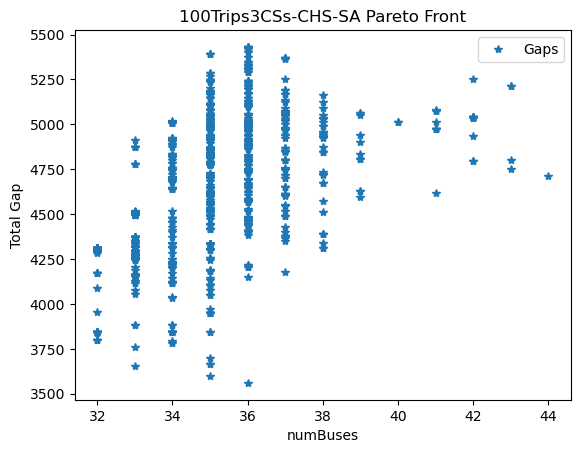

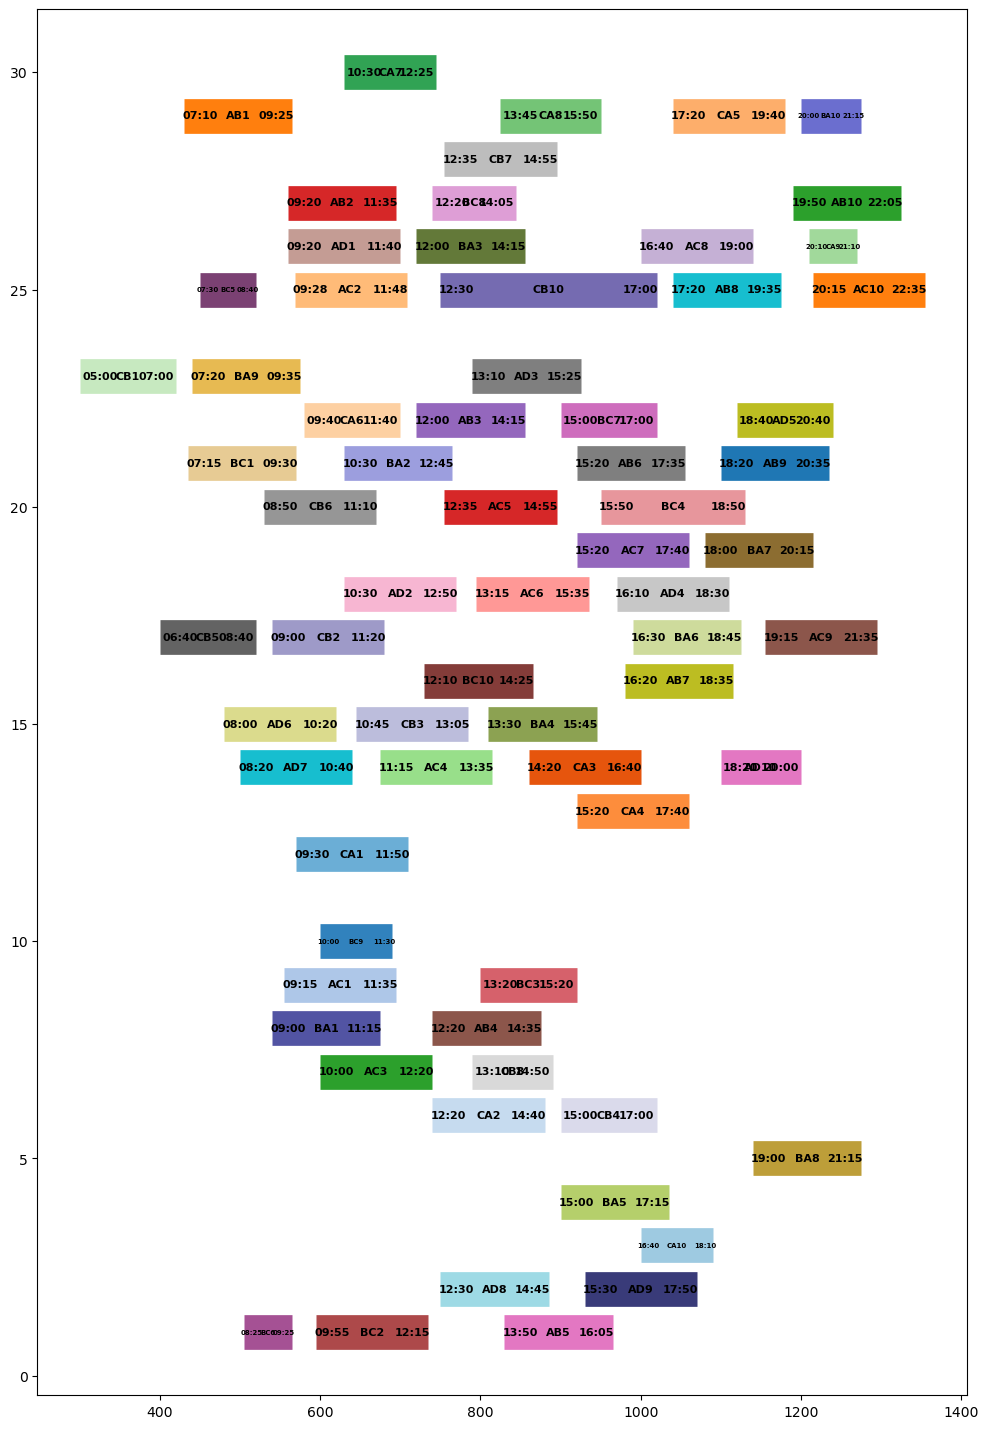

In [13]:
HundredTrips_3cs_df = visualizeSolution(solution_spaces_100_1[1:], "100Trips3CSs-CHS-SA Pareto Front", all_schs_3cs, recharge_3cs_arcs)
newdf_100_3cs = visualizeResult(new_schedule_100_3, all_schs_3cs, "CHS_100Trips-3CS")

trips100_df_3cs = newdf_100_3cs.copy(deep=True)
trips100_df_3cs['next_dep'] = trips100_df_3cs.groupby('bus_id')['dep_time'].shift(-1).fillna(0)
trips100_df_3cs['difference'] = trips100_df_3cs['next_dep'] - trips100_df_3cs['arr_time']
trips100_df_3cs['difference'] = trips100_df_3cs['difference'].apply(lambda x: 0 if x < 0 else x)
trips100_soln_3cs = trips100_df_3cs.groupby(['bus_id'])['difference'].sum()

chs_100Trips3cs_IDLE_soln = trips100_soln_3cs.groupby(['bus_id']).agg(
    trips=('trip_id', concat_str),
    numRecharge=('trip_id',countRecharge),
    numTrips=('trip_id', countTrips),
    gapTime=('difference', 'sum')
)
chs_100Trips3cs_IDLE_soln.sort_values(['gapTime'], ascending=False)